
ANALYZING: The Fellowship of the Ring
1. Loading and Tokenizing text...
   Loaded 179,151 tokens from ..\data\Fellowship.txt
2. Building Descriptive Profiles...
3. Calculating Similarity...
4. Generating Graph...


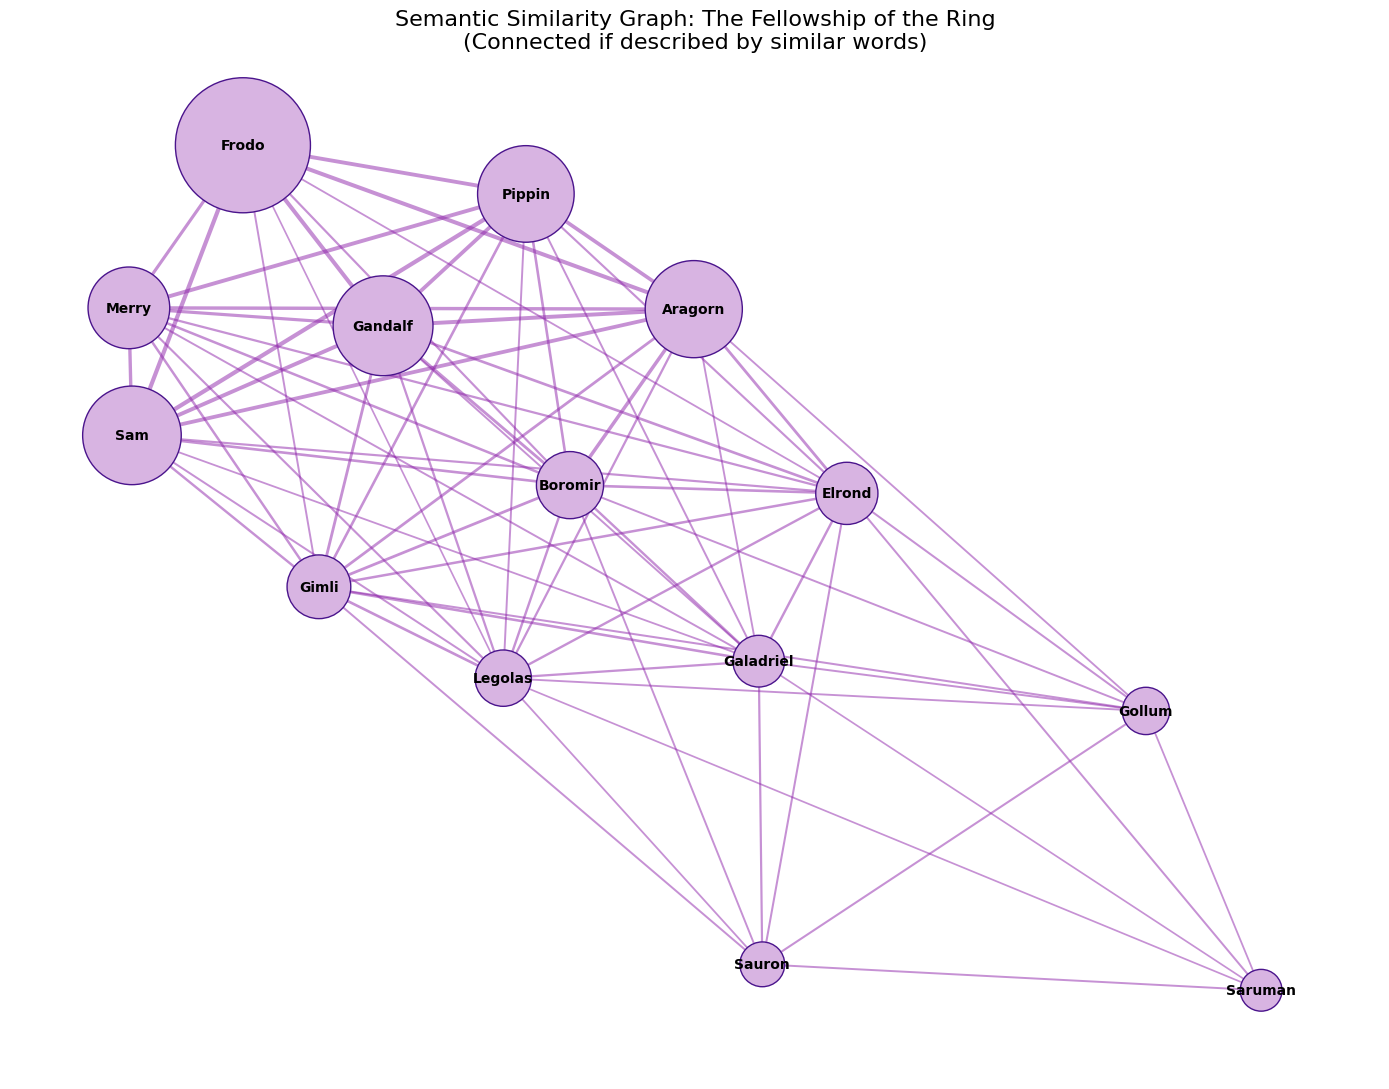

   Top Semantic Pair: ('Pippin', 'Sam') (Score: 0.30)

ANALYZING: The Two Towers
1. Loading and Tokenizing text...
   Loaded 155,328 tokens from ..\data\TwoTowers.txt
2. Building Descriptive Profiles...
3. Calculating Similarity...
4. Generating Graph...


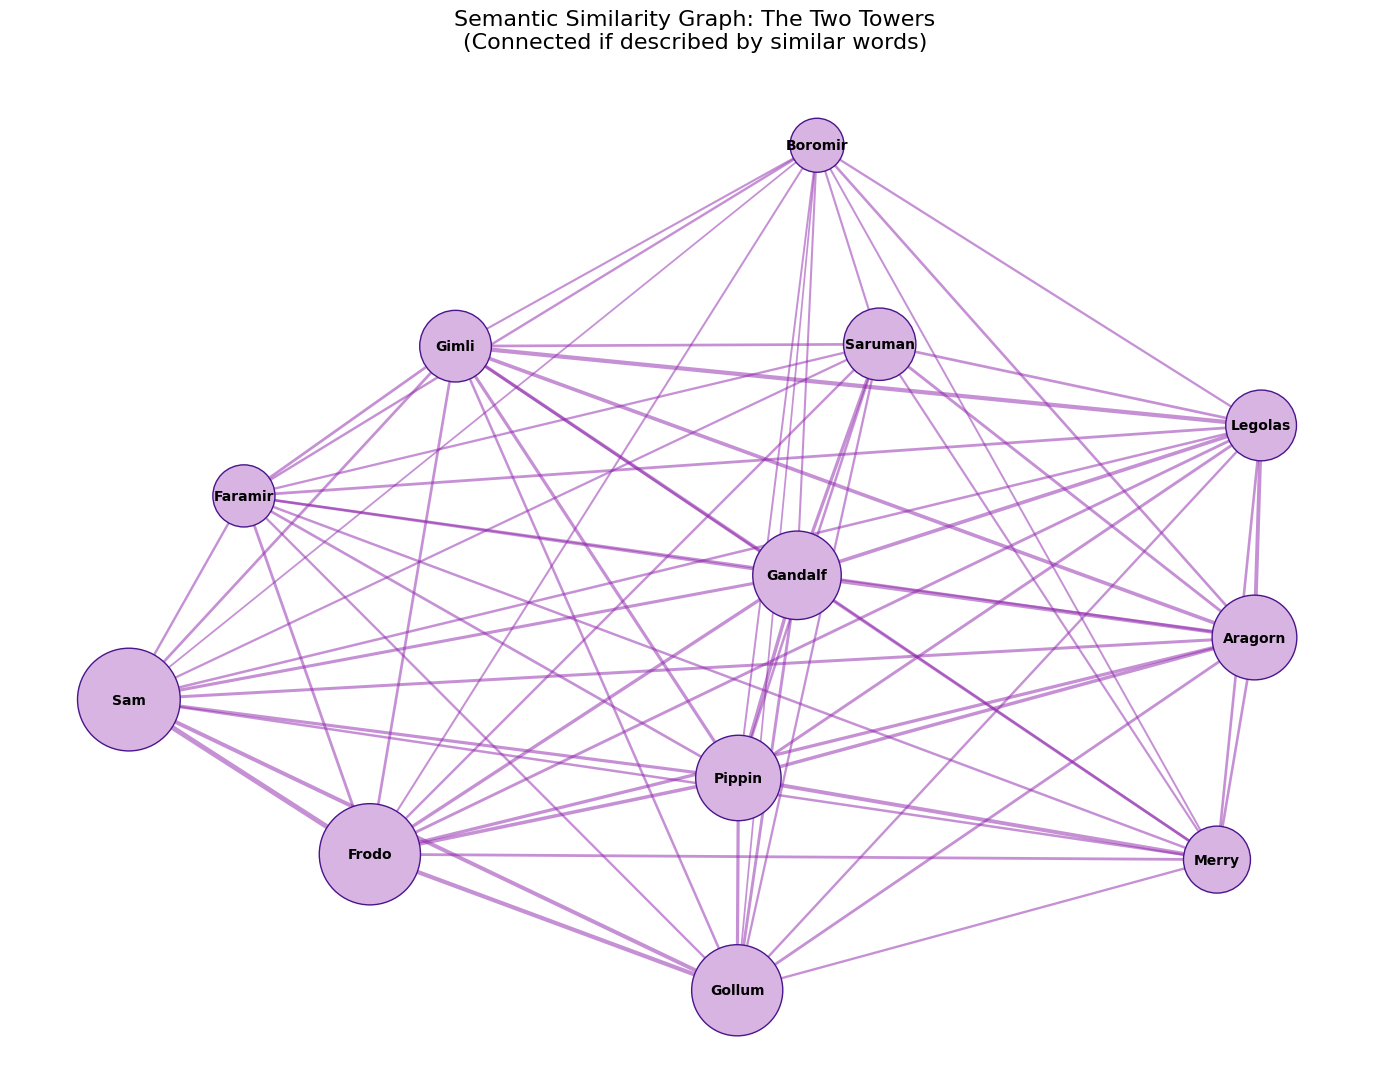

   Top Semantic Pair: ('Frodo', 'Sam') (Score: 0.36)

ANALYZING: The Return of the King
1. Loading and Tokenizing text...
   Loaded 71,437 tokens from ..\data\TheKing.txt
2. Building Descriptive Profiles...
3. Calculating Similarity...
4. Generating Graph...


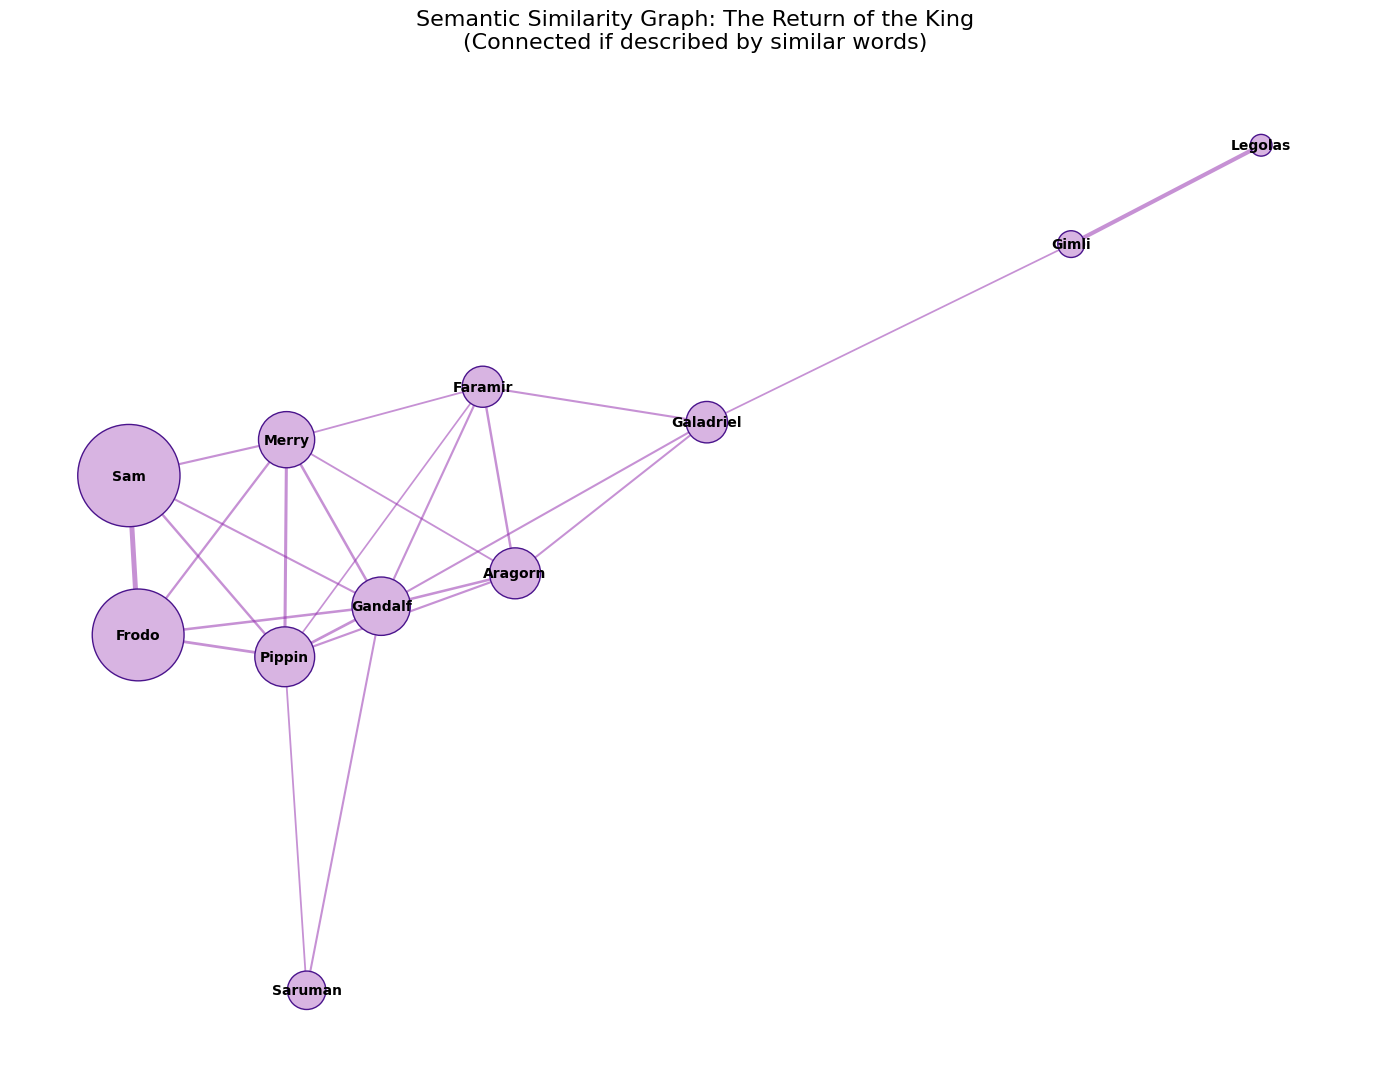

   Top Semantic Pair: ('Frodo', 'Sam') (Score: 0.36)


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import re
from pathlib import Path
from collections import defaultdict
import itertools

# --- CONFIG ---
# Paths to your data files
CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
}

# Character Mapping
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel", "lady"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"]
}

# Create alias lookup map
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# Common "stop words" to ignore (non-descriptive words)
STOPWORDS = set([
    "the", "and", "to", "of", "a", "in", "was", "he", "she", "it", "his", "her",
    "that", "with", "as", "for", "on", "at", "but", "had", "is", "him", "not",
    "they", "be", "from", "by", "or", "up", "out", "so", "said", "then", "now",
    "one", "there", "all", "were", "when", "into", "if", "no", "just", "very",
    "could", "would", "what", "which", "do", "will", "see", "go", "come", "came",
    "went", "looked", "asked", "down", "over", "back", "mr", "mrs", "don't", "did"
])

# --- DATA LOADING FUNCTIONS ---

def clean_and_tokenize(filepath):
    """Loads a file, cleans headers, and returns a list of lowercase words."""
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
        
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    # Simple heuristic to strip Project Gutenberg headers
    # Expanded markers to catch Book 1 (Prologue), Book 2 (Book III), and Book 3 (Book V)
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    
    start_idx = 0
    end_idx = len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: 
            start_idx = idx
            break
            
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: 
            end_idx = idx
            break
            
    clean_text = text[start_idx:end_idx].lower()
    
    # Tokenize: keep only alphabetic words
    tokens = re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)
    return tokens

# --- ANALYSIS FUNCTIONS ---

def get_character_descriptors(tokens, alias_map, window_size=6):
    """
    Builds a set of descriptive words found near each character.
    """
    char_descriptors = defaultdict(set)
    
    # Identify character positions
    char_positions = []
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_positions.append((alias_map[word], i))
            
    # For each mention, grab context words
    for char_name, pos in char_positions:
        start = max(0, pos - window_size)
        end = min(len(tokens), pos + window_size + 1)
        
        context_window = tokens[start:end]
        
        for word in context_window:
            # Only keep words that are NOT the name itself and NOT a stopword
            # We also filter short words to reduce noise
            if word not in alias_map and word not in STOPWORDS and len(word) > 3:
                char_descriptors[char_name].add(word)
                
    return char_descriptors

def calculate_similarity_edges(char_descriptors):
    """
    Calculates Jaccard Similarity between every pair of characters.
    Jaccard = (Intersection of words) / (Union of words)
    """
    edges = {}
    
    pairs = itertools.combinations(char_descriptors.keys(), 2)
    
    for char_a, char_b in pairs:
        words_a = char_descriptors[char_a]
        words_b = char_descriptors[char_b]
        
        if not words_a or not words_b:
            continue
            
        # Jaccard Index Formula
        intersection = len(words_a.intersection(words_b))
        union = len(words_a.union(words_b))
        
        similarity = intersection / union if union > 0 else 0
        
        # Only keep significant connections (e.g., > 10% overlap)
        if similarity > 0.12: 
            edges[(char_a, char_b)] = similarity
            
    return edges

# --- VISUALIZATION FUNCTION ---
def plot_similarity_graph(edge_data, title, descriptors):
    G = nx.Graph() # Undirected graph (Similarity is mutual)
    
    # Add edges
    for (u, v), weight in edge_data.items():
        # Scale weight up for better visualization (0.15 -> 1.5)
        G.add_edge(u, v, weight=weight * 10) 

    plt.figure(figsize=(14, 11))
    
    # Layout - Fruchterman Reingold usually groups similar clusters well
    pos = nx.spring_layout(G, k=0.8, iterations=100, seed=42)
    
    # Node Size based on how "describable" they are (how many unique words)
    node_sizes = [len(descriptors[n]) * 5 for n in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='#d8b4e2', edgecolors='#4a148c')
    
    # Edge Width based on similarity score
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=weights, edge_color='#8e24aa', alpha=0.5)
    
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title(f"Semantic Similarity Graph: {title}\n(Connected if described by similar words)", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- MAIN EXECUTION ---

books_to_analyze = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

for title, path in books_to_analyze:
    print(f"\n{'='*60}")
    print(f"ANALYZING: {title}")
    print(f"{'='*60}")
    
    print("1. Loading and Tokenizing text...")
    tokens = clean_and_tokenize(path)
    print(f"   Loaded {len(tokens):,} tokens from {path}")

    if tokens:
        print("2. Building Descriptive Profiles...")
        descriptors = get_character_descriptors(tokens, ALIAS_MAP) 

        print("3. Calculating Similarity...")
        similarity_edges = calculate_similarity_edges(descriptors)

        print("4. Generating Graph...")
        plot_similarity_graph(similarity_edges, title, descriptors)
        
        # Optional debug: Print the strongest link for this book
        if similarity_edges:
            top_pair = max(similarity_edges.items(), key=lambda x: x[1])
            print(f"   Top Semantic Pair: {top_pair[0]} (Score: {top_pair[1]:.2f})")
    else:
        print("   Error: No tokens loaded. Check file path.")

In [ ]:
CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
}



ANALYZING: The Fellowship of the Ring
1. Loading and Tokenizing text...
   Loaded 179,151 tokens from ..\data\Fellowship.txt
2. Building Descriptive Profiles...
3. Calculating Similarity...
4. Generating Graph...


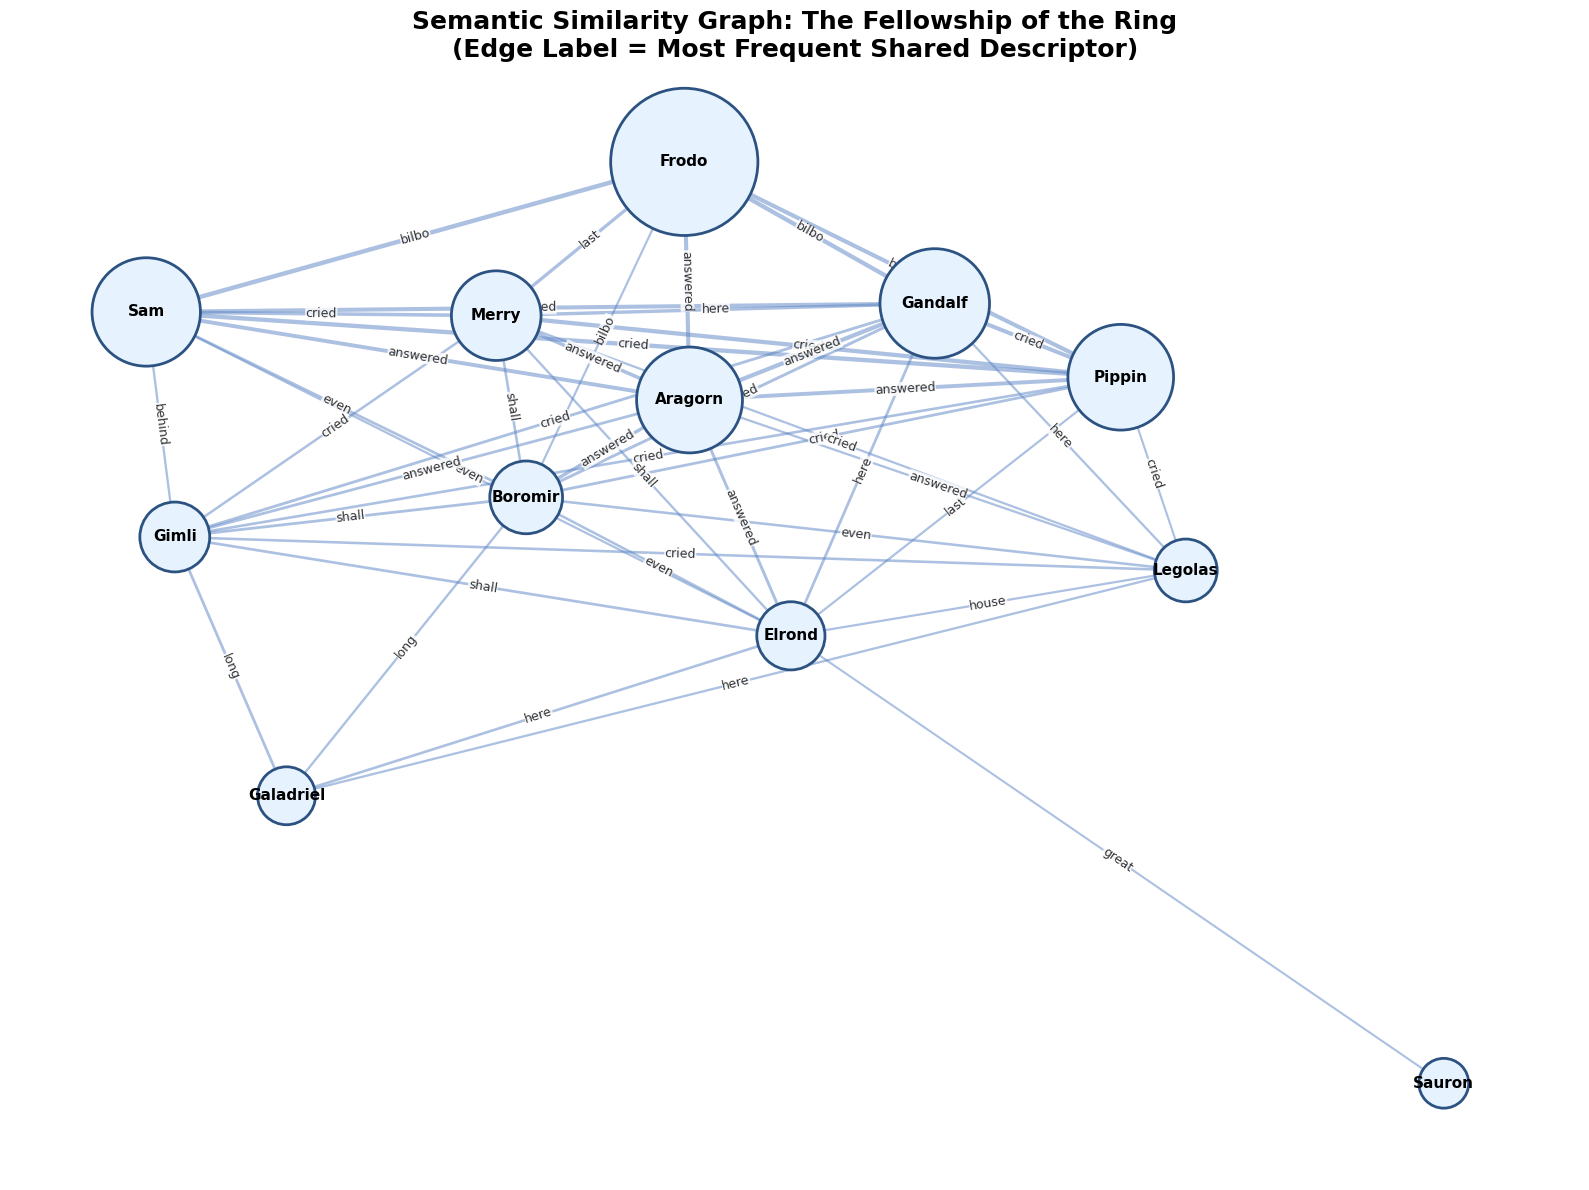

   Top Semantic Pair: ('Frodo', 'Sam') (Score: 0.32, Word: bilbo)

ANALYZING: The Two Towers
1. Loading and Tokenizing text...
   Loaded 155,328 tokens from ..\data\TwoTowers.txt
2. Building Descriptive Profiles...
3. Calculating Similarity...
4. Generating Graph...


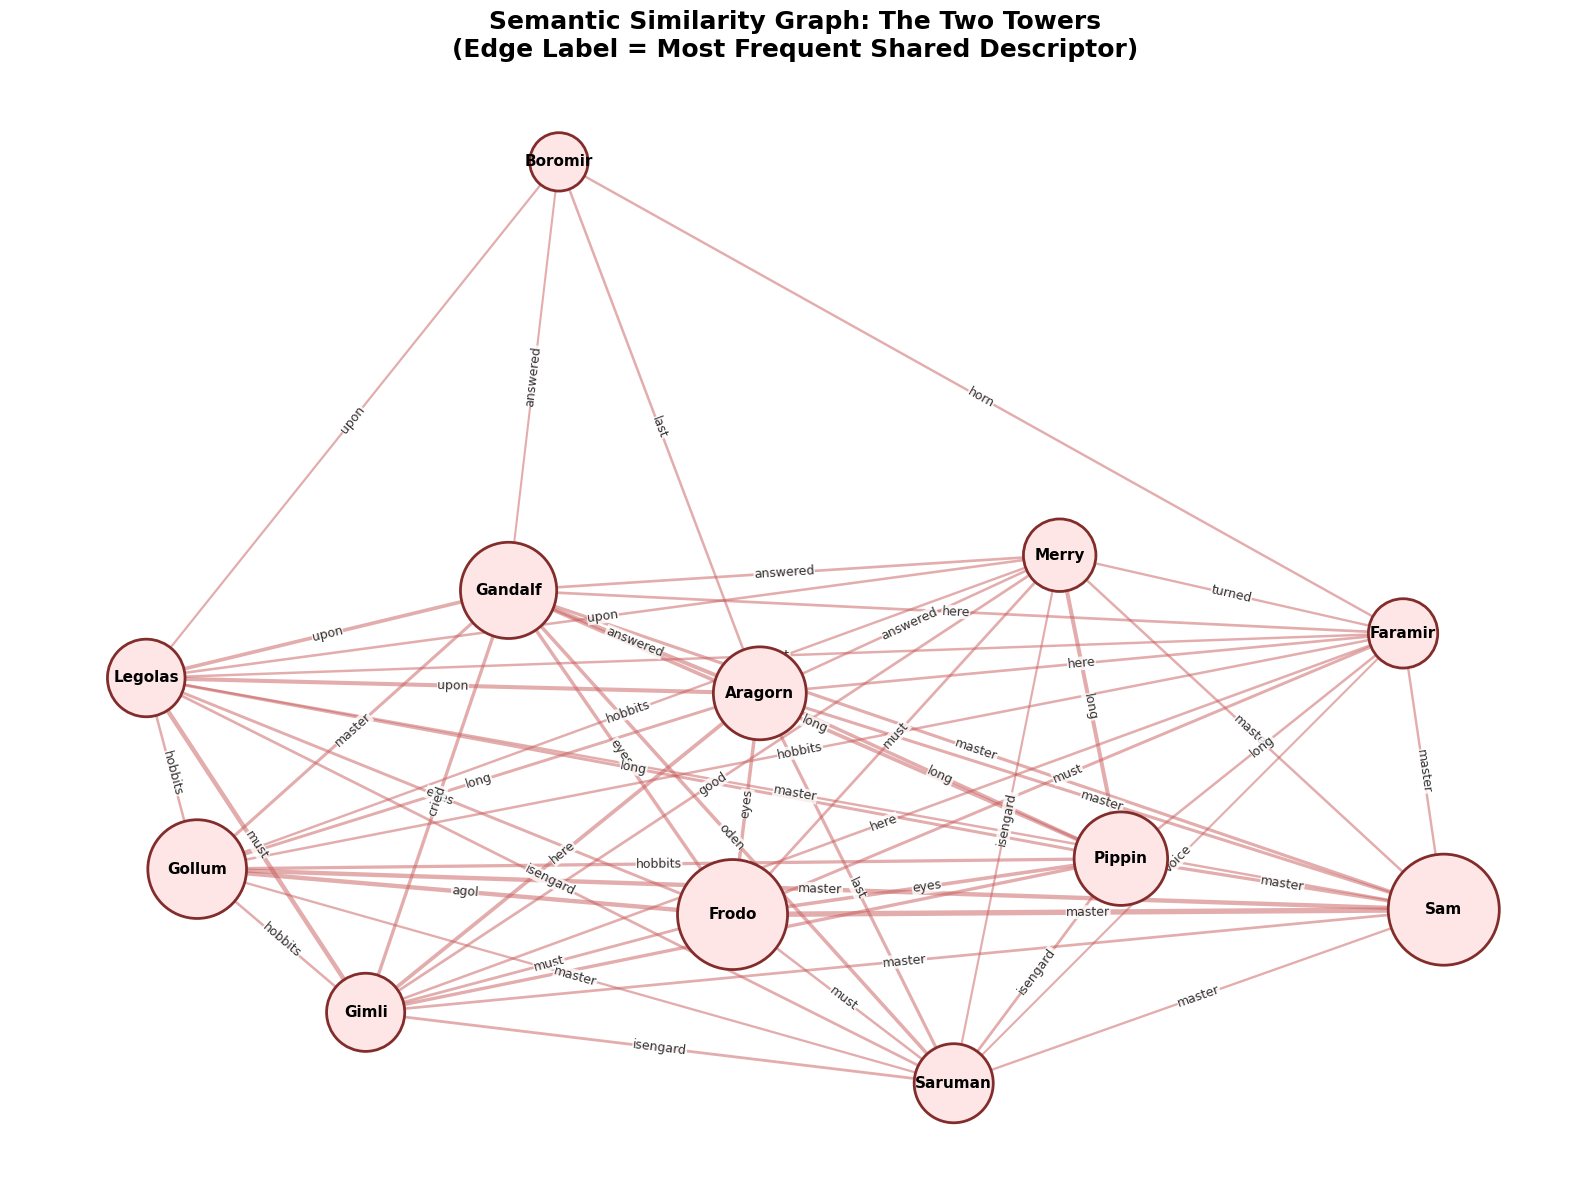

   Top Semantic Pair: ('Frodo', 'Sam') (Score: 0.39, Word: master)

ANALYZING: The Return of the King
1. Loading and Tokenizing text...
   Loaded 71,437 tokens from ..\data\TheKing.txt
2. Building Descriptive Profiles...
3. Calculating Similarity...
4. Generating Graph...


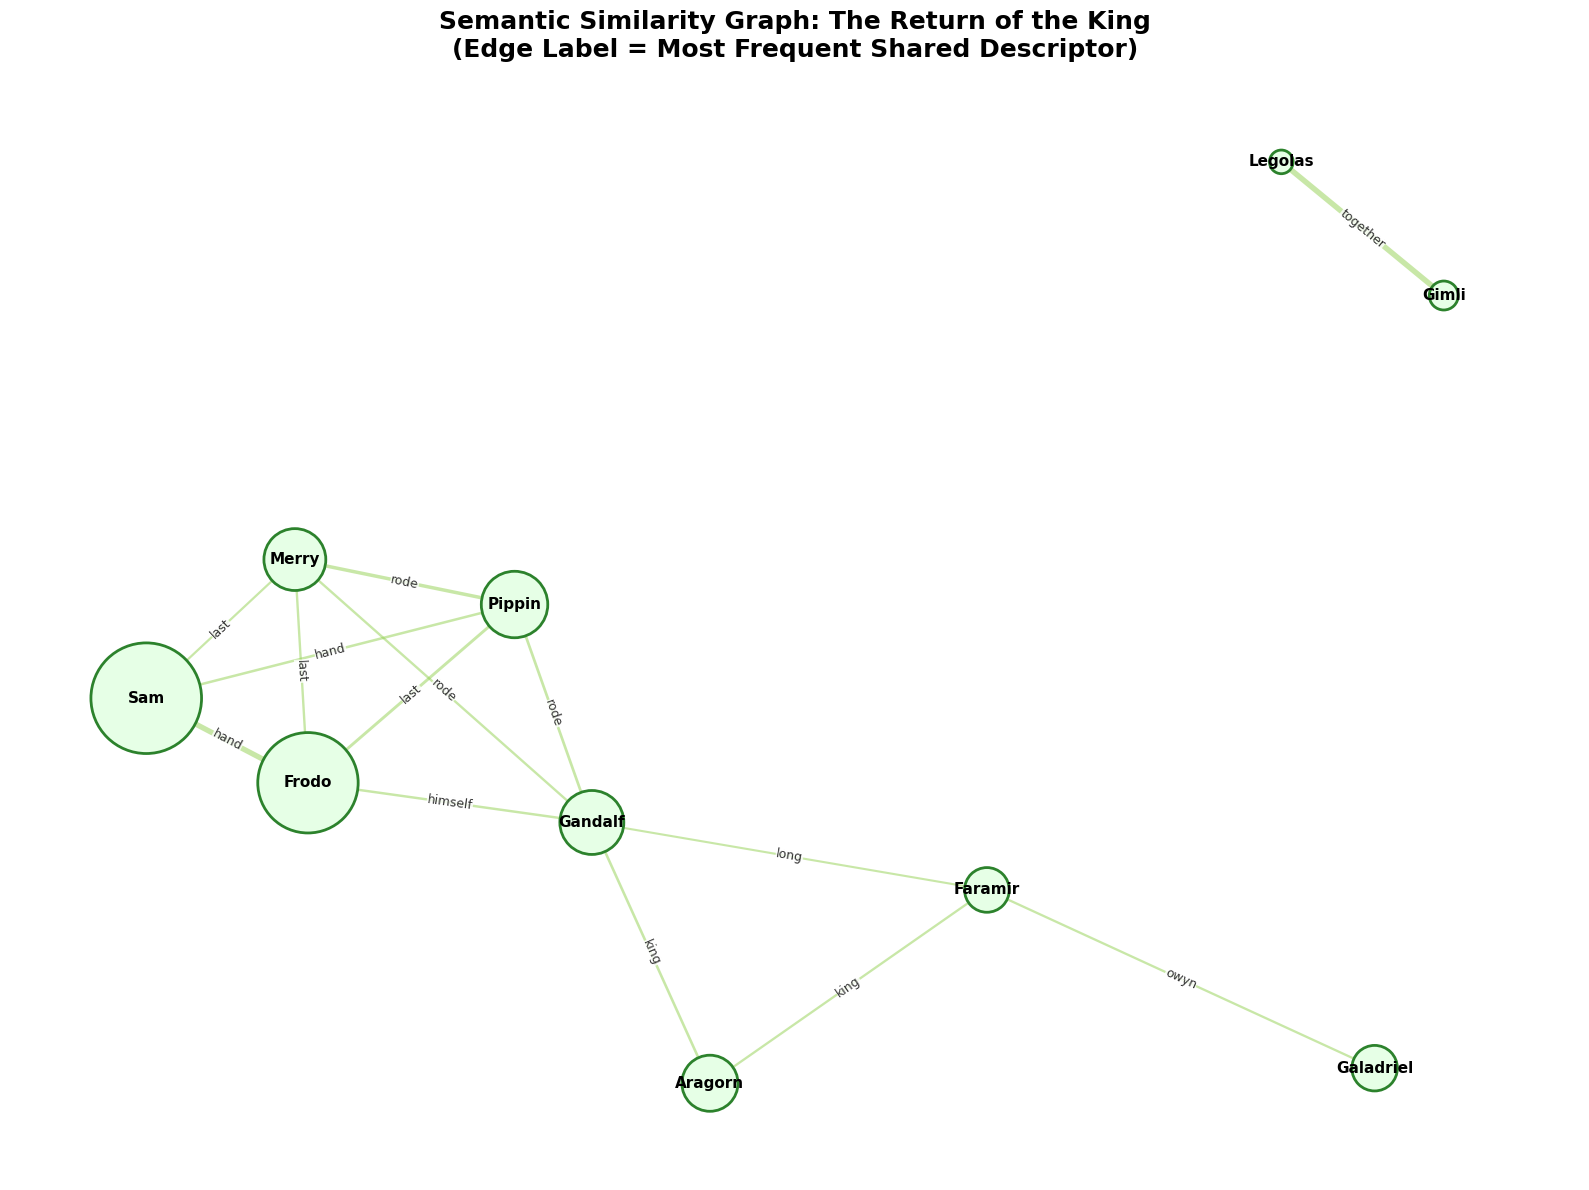

   Top Semantic Pair: ('Legolas', 'Gimli') (Score: 0.39, Word: together)


In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import re
from pathlib import Path
from collections import defaultdict
import itertools

# --- CONFIG ---
# Paths to your data files (Updated paths)
CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
}

# Character Mapping
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel", "lady"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"]
}

# Create alias lookup map
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# Common "stop words" to ignore (non-descriptive words)
# Expanded list to filter out words that don't add semantic value
STOPWORDS = set([
    "the", "and", "to", "of", "a", "in", "was", "he", "she", "it", "his", "her",
    "that", "with", "as", "for", "on", "at", "but", "had", "is", "him", "not",
    "they", "be", "from", "by", "or", "up", "out", "so", "said", "then", "now",
    "one", "there", "all", "were", "when", "into", "if", "no", "just", "very",
    "could", "would", "what", "which", "do", "will", "see", "go", "come", "came",
    "went", "looked", "asked", "down", "over", "back", "mr", "mrs", "don't", "did",
    # Added based on request:
    "have", "this", "other", "some", "more", "like", "time", "about", "than",
    "them", "their", "been", "are", "has", "only", "where", "how", "know",
    "think", "make", "well", "much", "before", "after", "again", "away", "off",
    "your" # Added 'your' to filter
])

# --- DATA LOADING FUNCTIONS ---

def clean_and_tokenize(filepath):
    """Loads a file, cleans headers, and returns a list of lowercase words."""
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
        
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    # Simple heuristic to strip Project Gutenberg headers
    # Expanded markers to catch Book 1 (Prologue), Book 2 (Book III), and Book 3 (Book V)
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    
    start_idx = 0
    end_idx = len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: 
            start_idx = idx
            break
            
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: 
            end_idx = idx
            break
            
    clean_text = text[start_idx:end_idx].lower()
    
    # Tokenize: keep only alphabetic words
    tokens = re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)
    return tokens

# --- ANALYSIS FUNCTIONS ---

def get_character_descriptors(tokens, alias_map, window_size=8):
    """
    Builds a dictionary of descriptive words and their counts found near each character.
    Increased window_size to 8 to capture more adjectives.
    Returns: { 'Frodo': {'weary': 5, 'ring': 2...}, ... }
    """
    # Nested defaultdict to store counts for each character
    char_descriptors = defaultdict(lambda: defaultdict(int))
    
    # Identify character positions
    char_positions = []
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_positions.append((alias_map[word], i))
            
    # For each mention, grab context words
    for char_name, pos in char_positions:
        start = max(0, pos - window_size)
        end = min(len(tokens), pos + window_size + 1)
        
        context_window = tokens[start:end]
        
        for word in context_window:
            # Only keep words that are NOT the name itself and NOT a stopword
            # We also filter short words to reduce noise
            if word not in alias_map and word not in STOPWORDS and len(word) > 3:
                char_descriptors[char_name][word] += 1
                
    return char_descriptors

def calculate_similarity_edges(char_descriptors):
    """
    Calculates Jaccard Similarity between every pair of characters.
    Also finds the 'top shared word' (highest combined frequency).
    """
    edges = {}
    
    pairs = itertools.combinations(char_descriptors.keys(), 2)
    
    for char_a, char_b in pairs:
        # Get set of words for Jaccard calculation
        words_a = set(char_descriptors[char_a].keys())
        words_b = set(char_descriptors[char_b].keys())
        
        if not words_a or not words_b:
            continue
            
        # Jaccard Index Formula
        intersection = words_a.intersection(words_b)
        union = words_a.union(words_b)
        
        similarity = len(intersection) / len(union) if union else 0
        
        # Only keep significant connections 
        # Bumped threshold to 0.15 for better accuracy/less noise
        if similarity > 0.15 and intersection: 
            # Find the word with the highest combined count in the intersection
            top_word = max(intersection, key=lambda w: char_descriptors[char_a][w] + char_descriptors[char_b][w])
            
            # Store both similarity score AND the top word
            edges[(char_a, char_b)] = (similarity, top_word)
            
    return edges

# --- VISUALIZATION FUNCTION ---
def plot_similarity_graph(edge_data, title, descriptors, color_theme):
    """
    Plots the graph with a specific color theme.
    color_theme = (node_fill, node_border, edge_color)
    """
    node_fill, node_border, edge_base_color = color_theme

    G = nx.Graph() # Undirected graph (Similarity is mutual)
    
    # Store labels for the edges (the top shared word)
    edge_labels = {}
    
    # Add edges
    for (u, v), (weight, word) in edge_data.items():
        # Scale weight up for better visualization (0.15 -> 1.5)
        G.add_edge(u, v, weight=weight * 10)
        edge_labels[(u, v)] = word

    plt.figure(figsize=(16, 12)) # Larger canvas
    
    # Layout - Fruchterman Reingold usually groups similar clusters well
    # Increased k to 2.0 to spread nodes apart and prevent overlap
    pos = nx.spring_layout(G, k=2.0, iterations=100, seed=42)
    
    # Node Size based on how "describable" they are (how many unique words)
    # Reduced multiplier from 10 to 5 to make nodes smaller
    node_sizes = [len(descriptors[n]) * 5 for n in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_fill, edgecolors=node_border, linewidths=2)
    
    # Edge Width based on similarity score
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=weights, edge_color=edge_base_color, alpha=0.5)
    
    # Draw Edge Labels (The Top Shared Word)
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=9,
        font_color='#333333',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.3)
    )
    
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')
    
    plt.title(f"Semantic Similarity Graph: {title}\n(Edge Label = Most Frequent Shared Descriptor)", fontsize=18, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- MAIN EXECUTION ---

# Define Color Themes per Book to match previous graphs
# Format: (Node Fill, Node Border, Edge Color)
BOOK_THEMES = {
    "The Fellowship of the Ring": ('#e6f3ff', '#2c5282', '#5b84c4'), # Blue
    "The Two Towers": ('#ffe6e6', '#822c2c', '#c85c5c'),             # Red
    "The Return of the King": ('#e6ffe6', '#2c822c', '#92d050')      # Green
}

books_to_analyze = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

for title, path in books_to_analyze:
    print(f"\n{'='*60}")
    print(f"ANALYZING: {title}")
    print(f"{'='*60}")
    
    print("1. Loading and Tokenizing text...")
    tokens = clean_and_tokenize(path)
    print(f"   Loaded {len(tokens):,} tokens from {path}")

    if tokens:
        print("2. Building Descriptive Profiles...")
        descriptors = get_character_descriptors(tokens, ALIAS_MAP) 

        print("3. Calculating Similarity...")
        similarity_edges = calculate_similarity_edges(descriptors)

        print("4. Generating Graph...")
        # Get theme for current book, default to blue if not found
        current_theme = BOOK_THEMES.get(title, ('#e6f3ff', '#2c5282', '#5b84c4'))
        plot_similarity_graph(similarity_edges, title, descriptors, current_theme)
        
        # Optional debug: Print the strongest link for this book
        if similarity_edges:
            top_pair = max(similarity_edges.items(), key=lambda x: x[1][0])
            print(f"   Top Semantic Pair: {top_pair[0]} (Score: {top_pair[1][0]:.2f}, Word: {top_pair[1][1]})")
    else:
        print("   Error: No tokens loaded. Check file path.")

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import re
from pathlib import Path
from collections import defaultdict, Counter
import itertools

# --- CONFIG ---
# Paths to your data files (Updated paths)
CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
}

# Character Mapping
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel", "lady"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"]
}

# Create alias lookup map
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# Common "stop words" to ignore (non-descriptive words)
# MASIVE EXPANSION: Filters out generic verbs, functional words, and common narrative nouns
STOPWORDS = set([
    # Standard functional words
    "the", "and", "to", "of", "a", "in", "was", "he", "she", "it", "his", "her",
    "that", "with", "as", "for", "on", "at", "but", "had", "is", "him", "not",
    "they", "be", "from", "by", "or", "up", "out", "so", "said", "then", "now",
    "one", "there", "all", "were", "when", "into", "if", "no", "just", "very",
    "could", "would", "what", "which", "do", "will", "see", "go", "come", "came",
    "went", "looked", "asked", "down", "over", "back", "mr", "mrs", "don't", "did",
    "have", "this", "other", "some", "more", "like", "time", "about", "than",
    "them", "their", "been", "are", "has", "only", "where", "how", "know",
    "think", "make", "well", "much", "before", "after", "again", "away", "off",
    "your", "upon", "even", "ever", "never", "under", "through", "still", "while",
    
    # Narrative verbs/actions that aren't descriptors
    "stood", "turned", "heard", "spoke", "told", "took", "gave", "saw", "sat",
    "lay", "left", "felt", "seemed", "found", "passed", "began", "cried",
    "answered", "thought", "knew", "made", "set", "put", "let", "get", "got",
    "going", "long", "must", "might", "can", "should", "here", "head", "face",
    "hand", "eyes", "voice", "way", "day", "night", "side", "place", "part",
    "thing", "things", "words", "nothing", "something", "anything", "moment"
])

# --- DATA LOADING FUNCTIONS ---

def clean_and_tokenize(filepath):
    """Loads a file, cleans headers, and returns a list of lowercase words."""
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
        
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    # Simple heuristic to strip Project Gutenberg headers
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    
    start_idx = 0
    end_idx = len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: 
            start_idx = idx
            break
            
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: 
            end_idx = idx
            break
            
    clean_text = text[start_idx:end_idx].lower()
    
    # Tokenize: keep only alphabetic words
    tokens = re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)
    return tokens

# --- ANALYSIS FUNCTIONS ---

def refine_descriptors(raw_descriptors, threshold_percentage=0.35):
    """
    ALGORITHM UPGRADE: Inverse Document Frequency (IDF) Logic
    If a word appears in the profiles of more than X% of characters,
    it is too generic (e.g., 'hobbit', 'friend', 'good') and should be removed.
    """
    word_character_count = Counter()
    total_chars = len(raw_descriptors)
    
    # Count how many characters use each word
    for char, words in raw_descriptors.items():
        for word in words:
            word_character_count[word] += 1
            
    # Identify generic words
    generic_words = set()
    for word, count in word_character_count.items():
        if count / total_chars > threshold_percentage:
            generic_words.add(word)
            
    # Create new refined dictionary
    refined = defaultdict(lambda: defaultdict(int))
    for char, words in raw_descriptors.items():
        for word, count in words.items():
            # Filter generic words AND rare noise (must appear at least twice)
            if word not in generic_words and count >= 2:
                refined[char][word] = count
                
    return refined

def get_character_descriptors(tokens, alias_map, window_size=8):
    """
    Builds a dictionary of descriptive words and their counts found near each character.
    Returns: { 'Frodo': {'weary': 5, 'ring': 2...}, ... }
    """
    # Temporary raw storage
    raw_descriptors = defaultdict(lambda: defaultdict(int))
    
    # Identify character positions
    char_positions = []
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_positions.append((alias_map[word], i))
            
    # For each mention, grab context words
    for char_name, pos in char_positions:
        start = max(0, pos - window_size)
        end = min(len(tokens), pos + window_size + 1)
        
        context_window = tokens[start:end]
        
        for word in context_window:
            # Only keep words that are NOT the name itself and NOT a stopword
            # We also filter short words to reduce noise
            if word not in alias_map and word not in STOPWORDS and len(word) > 3:
                raw_descriptors[char_name][word] += 1
                
    # Apply the "Specificity Filter"
    return refine_descriptors(raw_descriptors)

def calculate_similarity_edges(char_descriptors):
    """
    Calculates Jaccard Similarity between every pair of characters.
    Also finds the 'top shared word' (highest combined frequency).
    """
    edges = {}
    
    pairs = itertools.combinations(char_descriptors.keys(), 2)
    
    for char_a, char_b in pairs:
        # Get set of words for Jaccard calculation
        words_a = set(char_descriptors[char_a].keys())
        words_b = set(char_descriptors[char_b].keys())
        
        if not words_a or not words_b:
            continue
            
        # Jaccard Index Formula
        intersection = words_a.intersection(words_b)
        union = words_a.union(words_b)
        
        similarity = len(intersection) / len(union) if union else 0
        
        # Only keep significant connections 
        # Bumped threshold to 0.15 for better accuracy/less noise
        if similarity > 0.12 and intersection: 
            # Find the word with the highest combined count in the intersection
            top_word = max(intersection, key=lambda w: char_descriptors[char_a][w] + char_descriptors[char_b][w])
            
            # Store both similarity score AND the top word
            edges[(char_a, char_b)] = (similarity, top_word)
            
    return edges

# --- VISUALIZATION FUNCTION ---
def plot_similarity_graph(edge_data, title, descriptors, color_theme):
    """
    Plots the graph with a specific color theme.
    color_theme = (node_fill, node_border, edge_color)
    """
    node_fill, node_border, edge_base_color = color_theme

    G = nx.Graph() # Undirected graph (Similarity is mutual)
    
    # Store labels for the edges (the top shared word)
    edge_labels = {}
    
    # Add edges
    for (u, v), (weight, word) in edge_data.items():
        # Scale weight up for better visualization (0.15 -> 1.5)
        G.add_edge(u, v, weight=weight * 10)
        edge_labels[(u, v)] = word

    plt.figure(figsize=(16, 12)) # Larger canvas
    
    # Layout - Fruchterman Reingold usually groups similar clusters well
    # Increased k to 2.0 to spread nodes apart and prevent overlap
    pos = nx.spring_layout(G, k=2.0, iterations=100, seed=42)
    
    # Node Size based on how "describable" they are (how many unique words)
    # Reduced multiplier from 10 to 5 to make nodes smaller
    node_sizes = [len(descriptors[n]) * 5 for n in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_fill, edgecolors=node_border, linewidths=2)
    
    # Edge Width based on similarity score
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=weights, edge_color=edge_base_color, alpha=0.5)
    
    # Draw Edge Labels (The Top Shared Word)
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=9,
        font_color='#333333',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.3)
    )
    
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')
    
    plt.title(f"Semantic Similarity Graph: {title}\n(Edge Label = Most Frequent Shared Descriptor)", fontsize=18, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- MAIN EXECUTION ---

# Define Color Themes per Book to match previous graphs
# Format: (Node Fill, Node Border, Edge Color)
BOOK_THEMES = {
    "The Fellowship of the Ring": ('#e6f3ff', '#2c5282', '#5b84c4'), # Blue
    "The Two Towers": ('#ffe6e6', '#822c2c', '#c85c5c'),             # Red
    "The Return of the King": ('#e6ffe6', '#2c822c', '#92d050')      # Green
}

books_to_analyze = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

for title, path in books_to_analyze:
    print(f"\n{'='*60}")
    print(f"ANALYZING: {title}")
    print(f"{'='*60}")
    
    print("1. Loading and Tokenizing text...")
    tokens = clean_and_tokenize(path)
    print(f"   Loaded {len(tokens):,} tokens from {path}")

    if tokens:
        print("2. Building Descriptive Profiles...")
        descriptors = get_character_descriptors(tokens, ALIAS_MAP) 

        print("3. Calculating Similarity...")
        similarity_edges = calculate_similarity_edges(descriptors)

        print("4. Generating Graph...")
        # Get theme for current book, default to blue if not found
        current_theme = BOOK_THEMES.get(title, ('#e6f3ff', '#2c5282', '#5b84c4'))
        plot_similarity_graph(similarity_edges, title, descriptors, current_theme)
        
        # Optional debug: Print the strongest link for this book
        if similarity_edges:
            top_pair = max(similarity_edges.items(), key=lambda x: x[1][0])
            print(f"   Top Semantic Pair: {top_pair[0]} (Score: {top_pair[1][0]:.2f}, Word: {top_pair[1][1]})")
    else:
        print("   Error: No tokens loaded. Check file path.")


ANALYZING: The Fellowship of the Ring
1. Loading and Tokenizing text...
   Loaded 179,151 tokens from ../data/Fellowship.txt
2. Building Descriptive Profiles...
   Found 3698 character mentions
   Characters with profiles: 14

   Top 5 Character Profiles:
   - Frodo: 659 descriptors | Top: quite(18), it's(17), gildor(16), bilbo's(15), really(15)
   - Sam: 180 descriptors | Top: that's(17), it's(16), grass(14), bill(14), pony(12)
   - Gandalf: 139 descriptors | Top: staff(14), safe(9), really(8), dear(7), party(6)
   - Aragorn: 128 descriptors | Top: ranger(11), call(11), bree(10), arathorn(10), butterbur(7)
   - Pippin: 123 descriptors | Top: peregrin(9), notice(8), lane(8), farmer(8), bolger(7)

3. Calculating Similarity...
   Found 16 semantic connections
4. Generating Graph...


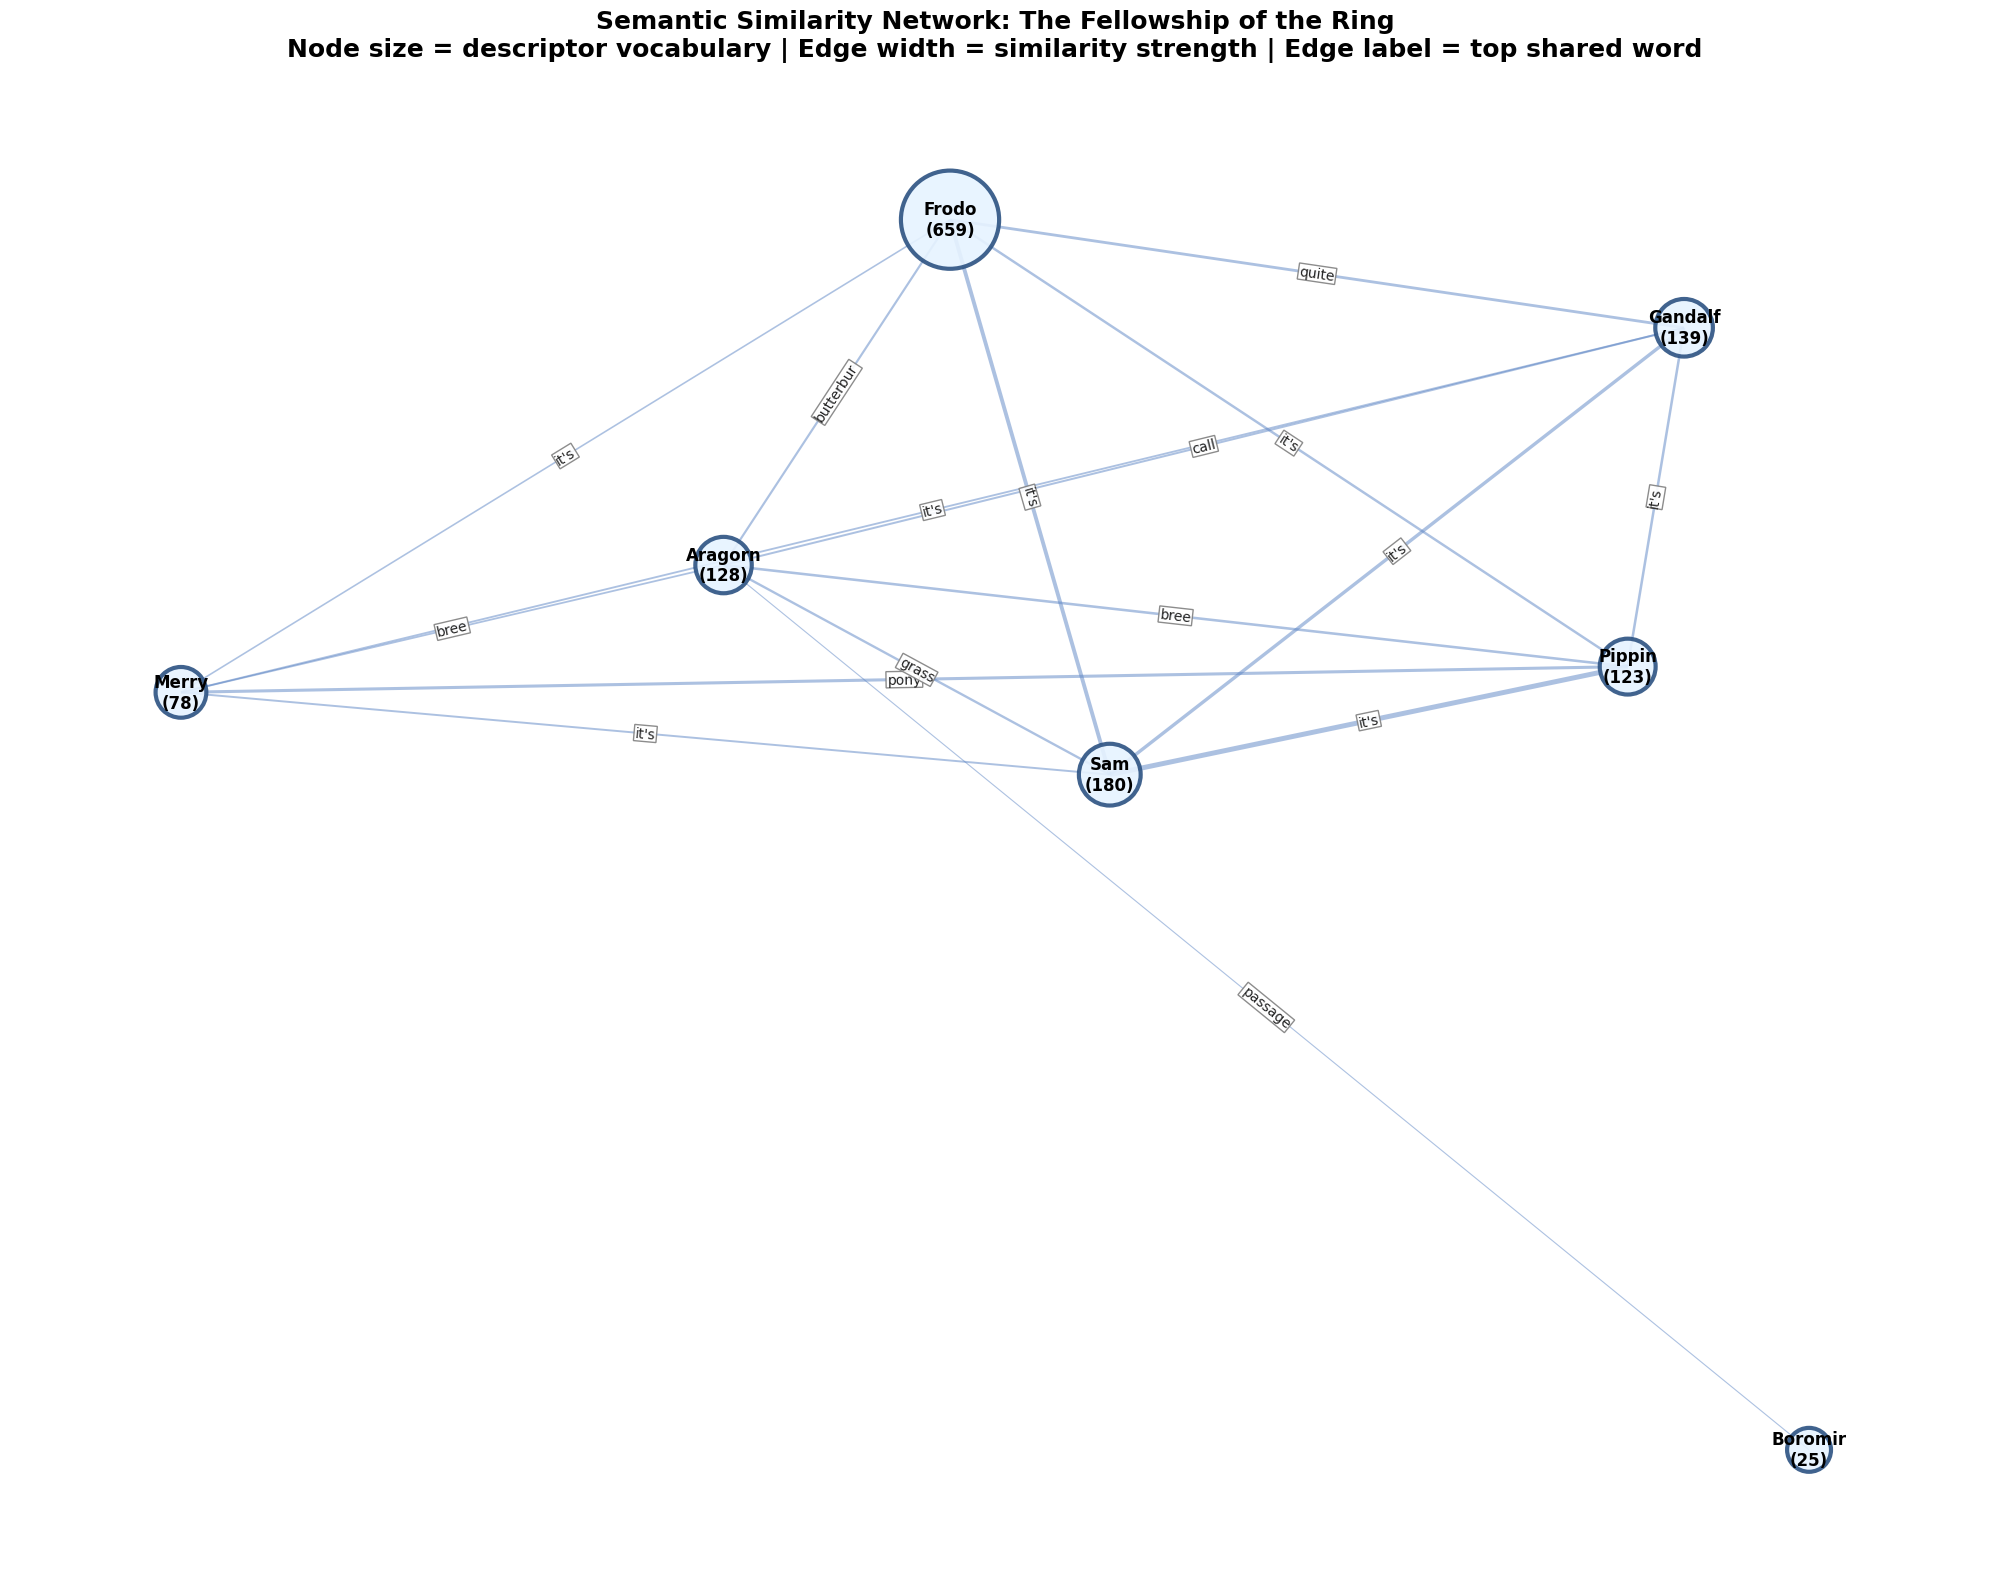


   Network Statistics:
   - Nodes: 7
   - Edges: 16
   - Avg degree: 4.57
   - Network density: 0.762
   Top Semantic Pair: ('Pippin', 'Sam') (Score: 0.18, Word: 'it's')

ANALYZING: The Two Towers
1. Loading and Tokenizing text...
   Loaded 155,328 tokens from ../data/TwoTowers.txt
2. Building Descriptive Profiles...
   Found 3128 character mentions
   Characters with profiles: 15

   Top 5 Character Profiles:
   - Frodo: 266 descriptors | Top: agol(36), he's(22), precious(22), it's(21), wake(19)
   - Sam: 263 descriptors | Top: agol(30), it's(24), he's(18), nice(18), that's(17)
   - Gollum: 190 descriptors | Top: agol(47), precious(28), nice(19), hissed(13), hungry(12)
   - Gandalf: 120 descriptors | Top: isengard(21), ride(17), treebeard(17), shadowfax(16), rode(15)
   - Aragorn: 114 descriptors | Top: arathorn(11), heir(10), ride(10), isengard(9), tirith(8)

3. Calculating Similarity...
   Found 36 semantic connections
4. Generating Graph...


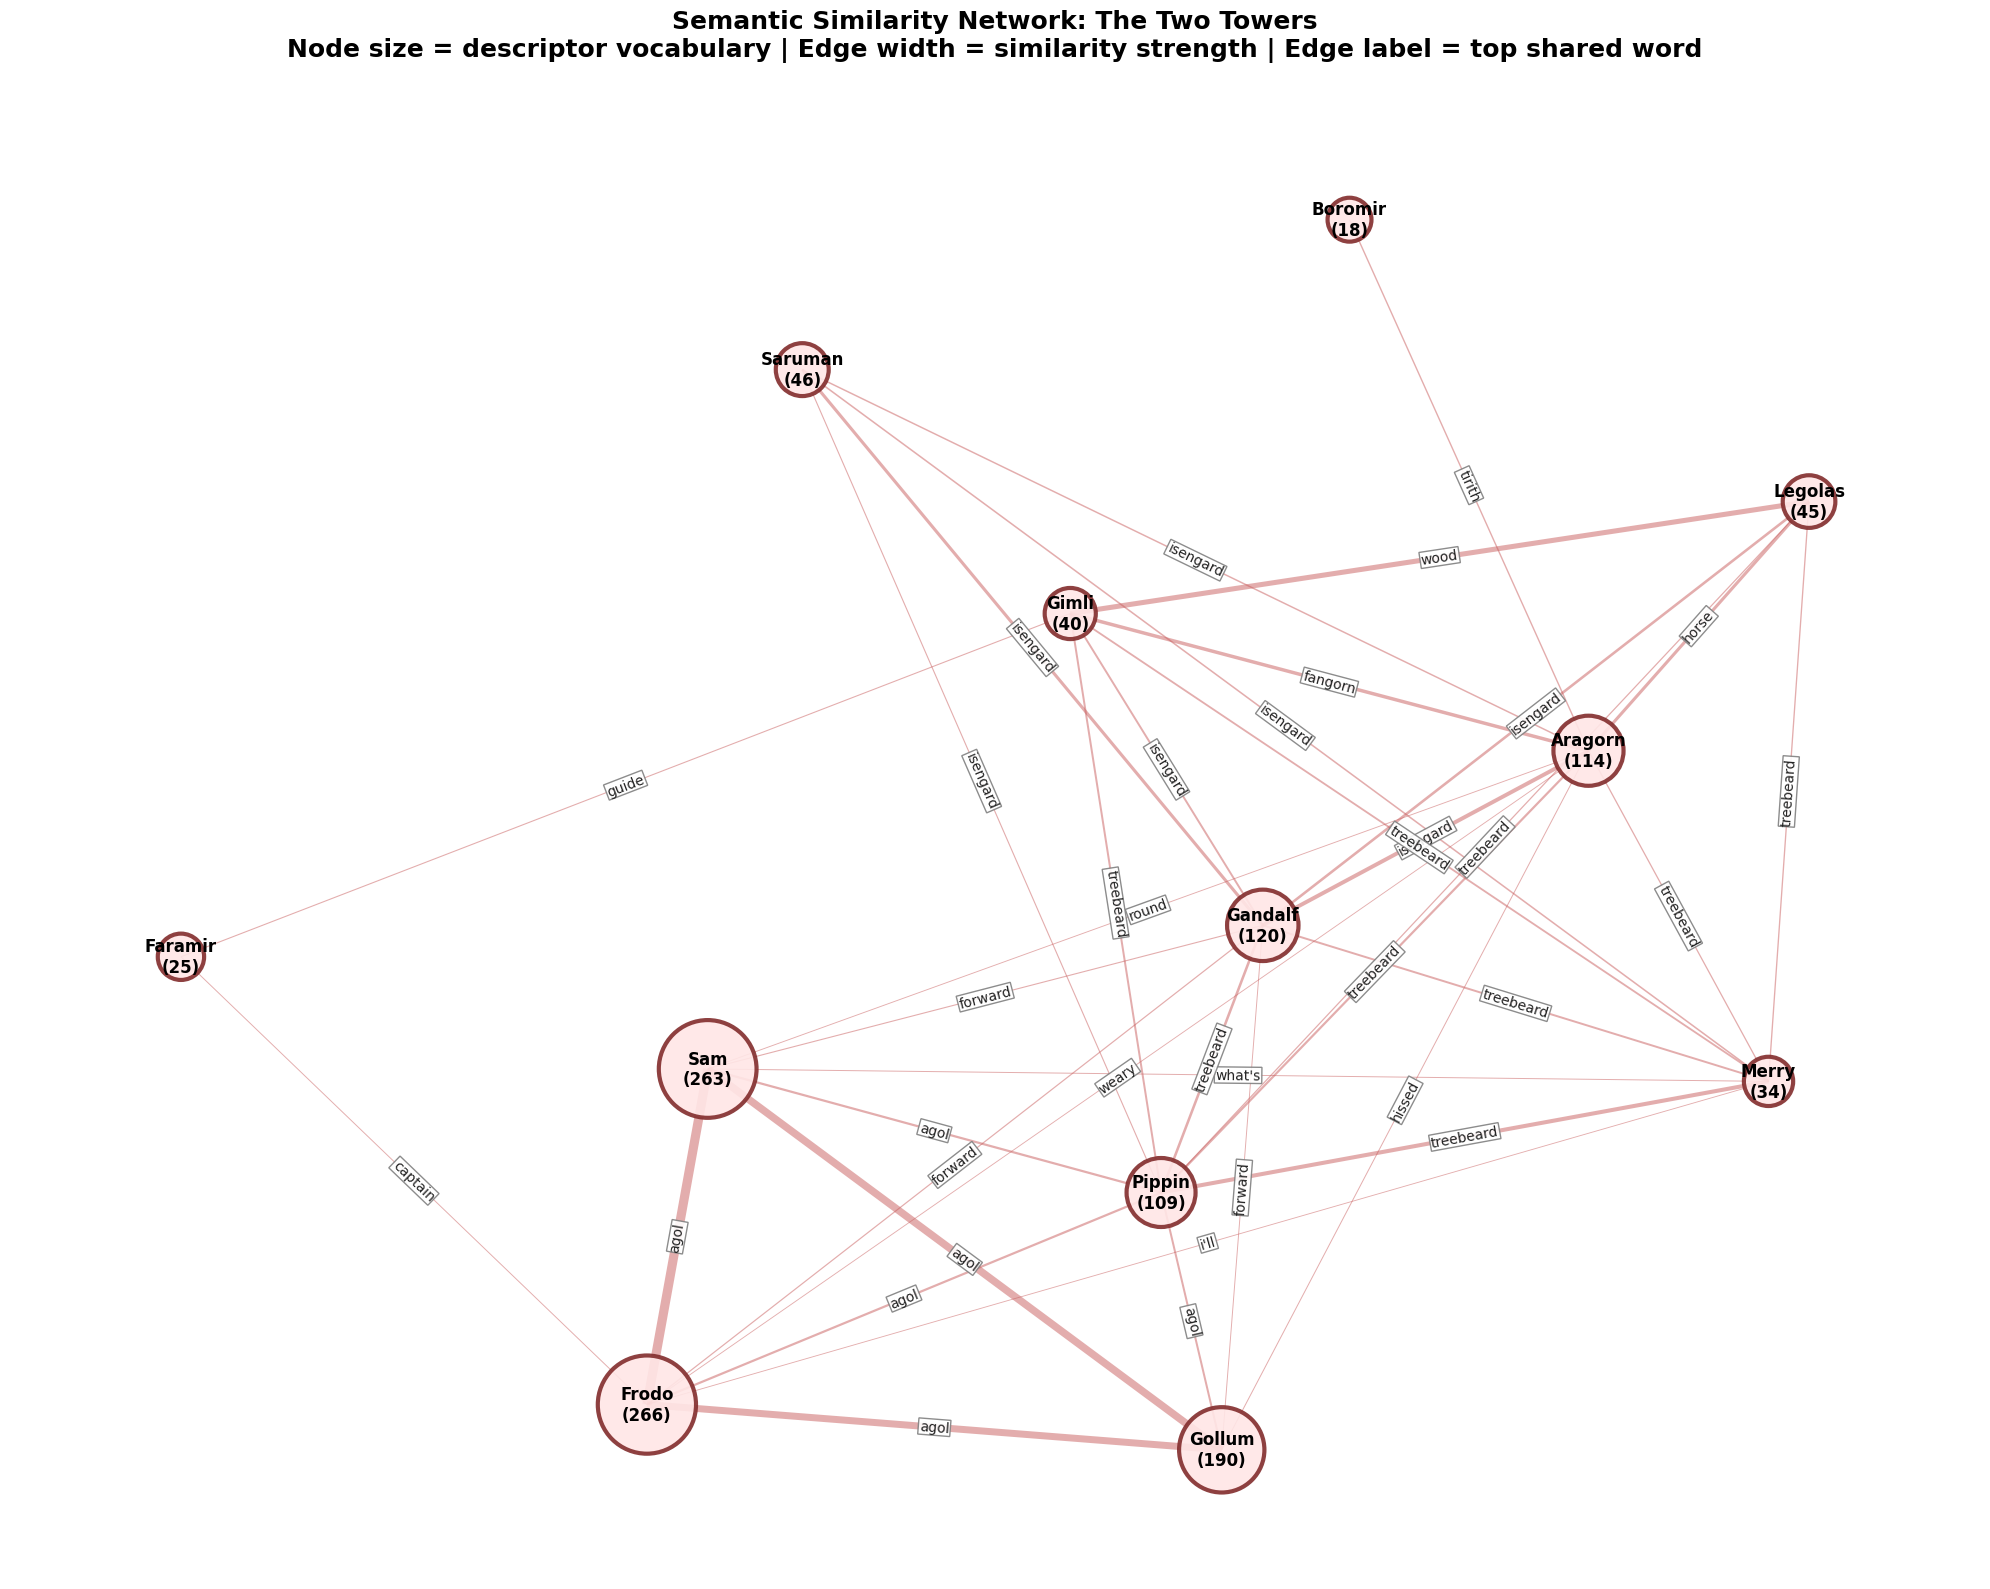


   Network Statistics:
   - Nodes: 12
   - Edges: 36
   - Avg degree: 6.00
   - Network density: 0.545
   Top Semantic Pair: ('Frodo', 'Sam') (Score: 0.33, Word: 'agol')

ANALYZING: The Return of the King
1. Loading and Tokenizing text...
   Loaded 71,437 tokens from ../data/TheKing.txt
2. Building Descriptive Profiles...
   Found 1526 character mentions
   Characters with profiles: 13

   Top 5 Character Profiles:
   - Sam: 425 descriptors | Top: almost(18), door(17), cotton(17), suddenly(15), tower(14)
   - Frodo: 303 descriptors | Top: bilbo(13), everything(12), almost(11), slowly(11), another(11)
   - Merry: 43 descriptors | Top: ruffians(12), horn(9), another(8), done(6), good(6)
   - Pippin: 39 descriptors | Top: good(7), bilbo(6), cloak(5), beat(5), ruffians(5)
   - Gandalf: 29 descriptors | Top: gone(5), realm(5), crown(5), terms(4), cold(4)

3. Calculating Similarity...
   Found 11 semantic connections
4. Generating Graph...


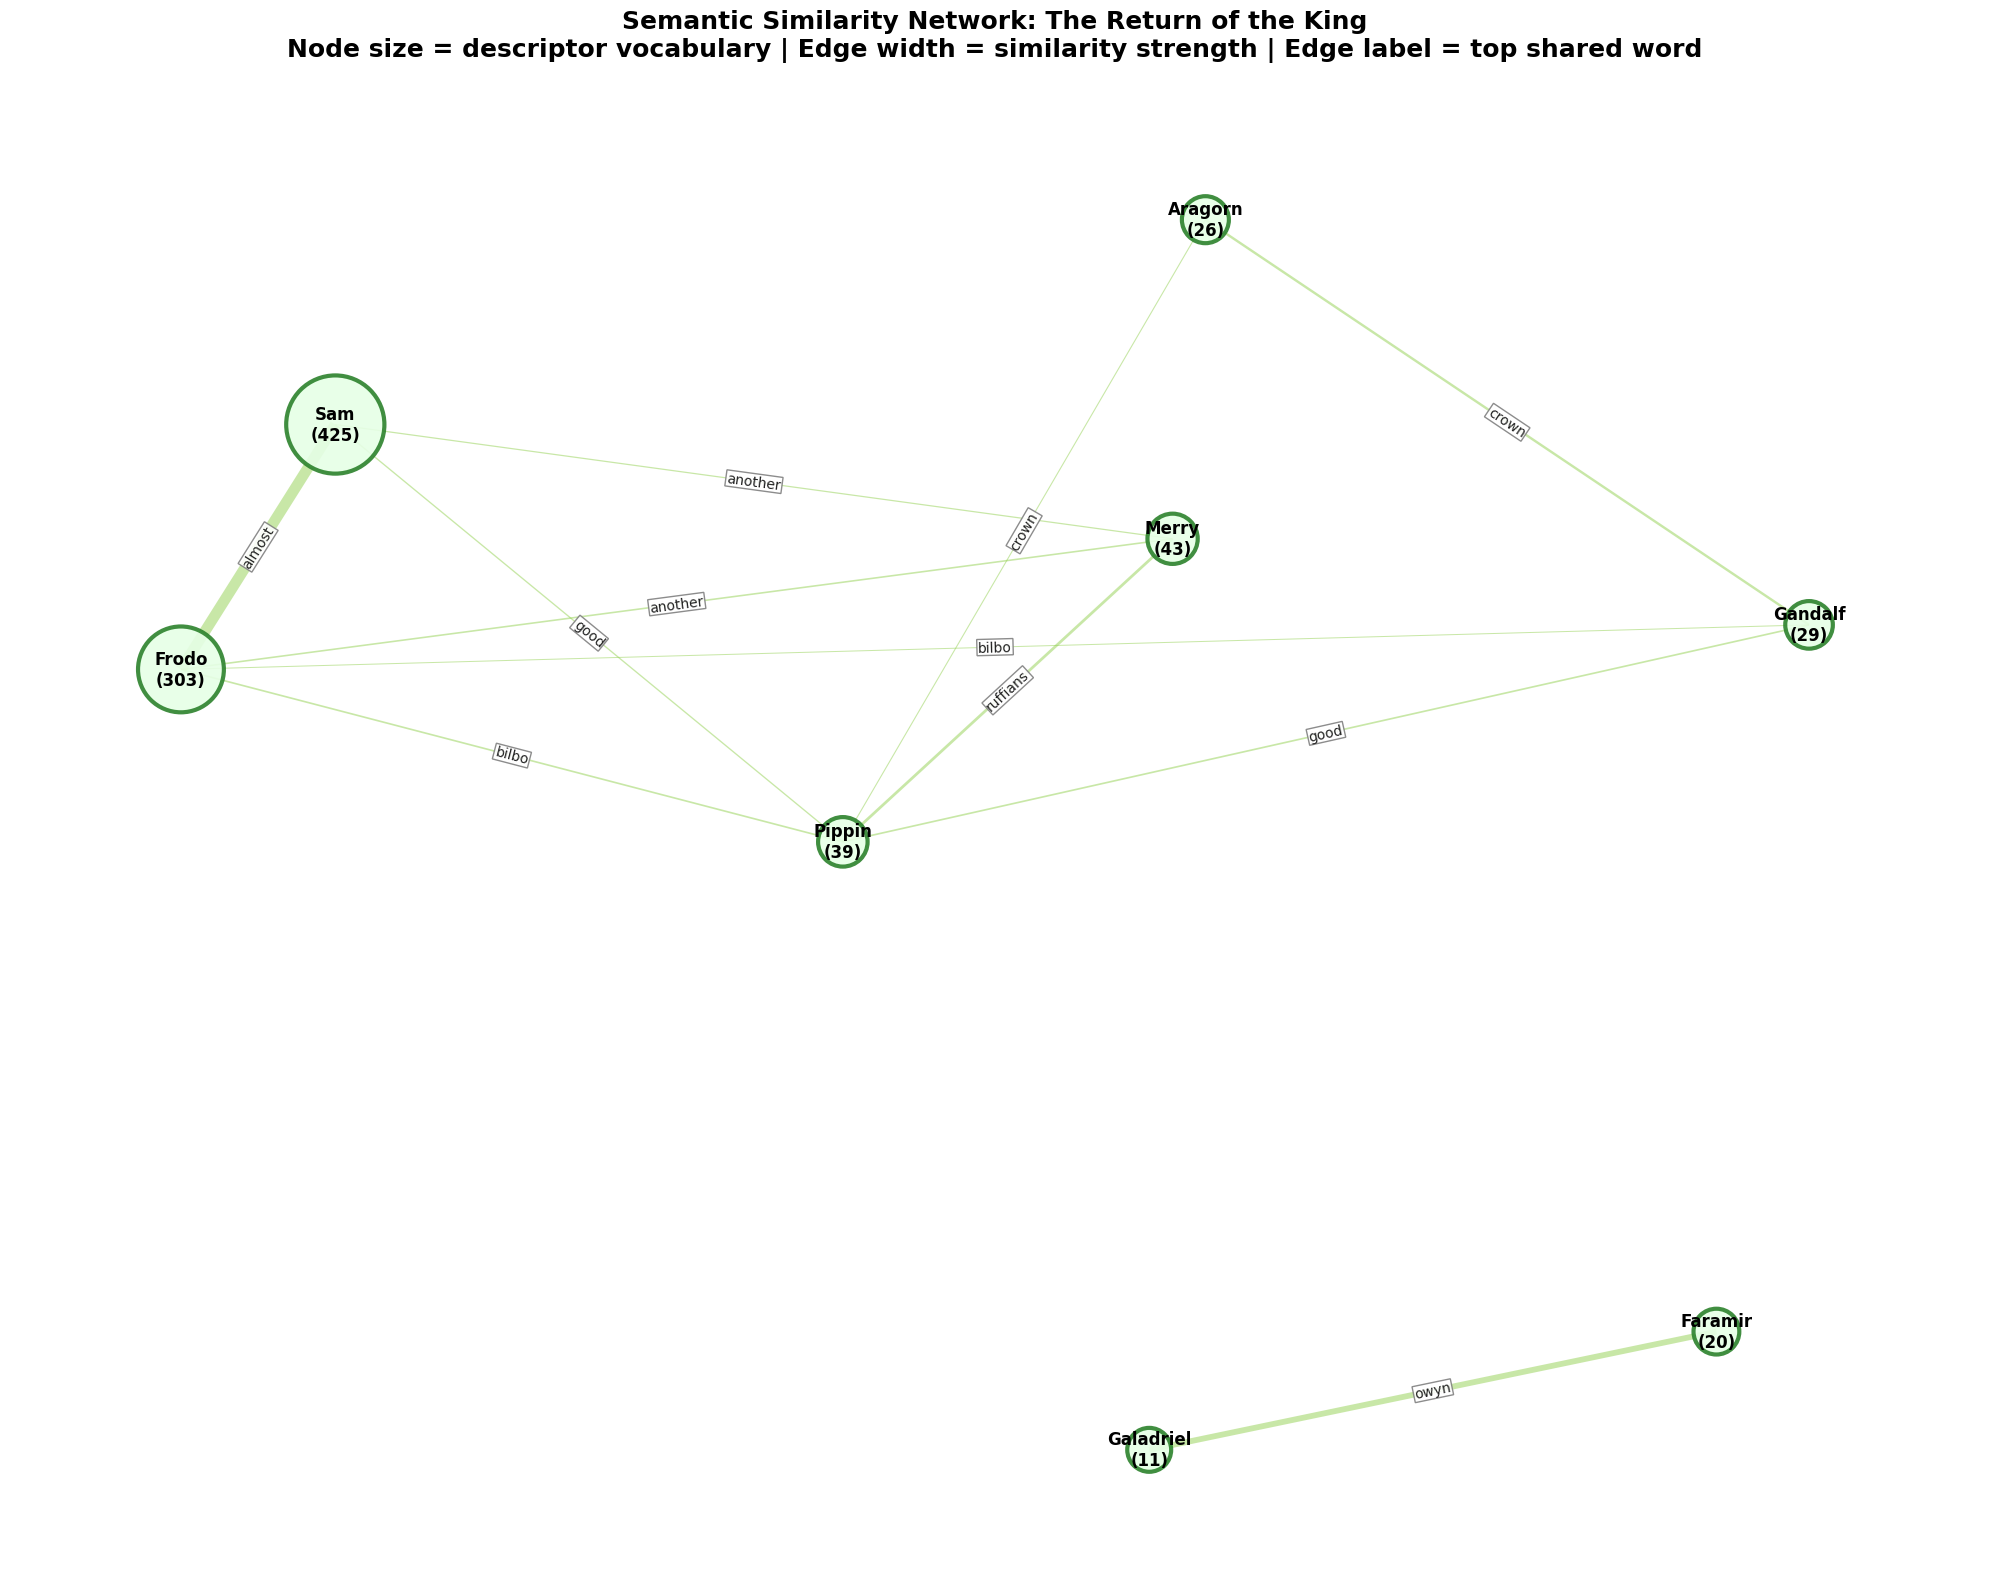


   Network Statistics:
   - Nodes: 8
   - Edges: 11
   - Avg degree: 2.75
   - Network density: 0.393
   Top Semantic Pair: ('Frodo', 'Sam') (Score: 0.39, Word: 'almost')


In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import re
from pathlib import Path
from collections import defaultdict, Counter
import itertools

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# Character Mapping
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel", "lady"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"]
}

# Create alias lookup map
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# Common "stop words" to ignore
STOPWORDS = set([
    "the", "and", "to", "of", "a", "in", "was", "he", "she", "it", "his", "her",
    "that", "with", "as", "for", "on", "at", "but", "had", "is", "him", "not",
    "they", "be", "from", "by", "or", "up", "out", "so", "said", "then", "now",
    "one", "there", "all", "were", "when", "into", "if", "no", "just", "very",
    "could", "would", "what", "which", "do", "will", "see", "go", "come", "came",
    "went", "looked", "asked", "down", "over", "back", "mr", "mrs", "don't", "did",
    "have", "this", "other", "some", "more", "like", "time", "about", "than",
    "them", "their", "been", "are", "has", "only", "where", "how", "know",
    "think", "make", "well", "much", "before", "after", "again", "away", "off",
    "your", "upon", "even", "ever", "never", "under", "through", "still", "while",
    "stood", "turned", "heard", "spoke", "told", "took", "gave", "saw", "sat",
    "lay", "left", "felt", "seemed", "found", "passed", "began", "cried",
    "answered", "thought", "knew", "made", "set", "put", "let", "get", "got",
    "going", "long", "must", "might", "can", "should", "here", "head", "face",
    "hand", "eyes", "voice", "way", "day", "night", "side", "place", "part",
    "thing", "things", "words", "nothing", "something", "anything", "moment"
])

def clean_and_tokenize(filepath):
    """Loads a file, cleans headers, and returns a list of lowercase words."""
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
        
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    
    start_idx = 0
    end_idx = len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: 
            start_idx = idx
            break
            
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: 
            end_idx = idx
            break
            
    clean_text = text[start_idx:end_idx].lower()
    tokens = re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)
    return tokens

def refine_descriptors(raw_descriptors, idf_threshold=0.5, min_count=3, max_count=200):
    """
    IMPROVED FILTERING:
    - idf_threshold: Words appearing in >50% of characters are too generic
    - min_count: Word must appear at least 3 times to be meaningful
    - max_count: Cap at 200 to avoid common narrative words dominating
    """
    word_character_count = Counter()
    total_chars = len(raw_descriptors)
    
    if total_chars == 0:
        return defaultdict(lambda: defaultdict(int))
    
    # Count how many characters use each word
    for char, words in raw_descriptors.items():
        for word in words:
            word_character_count[word] += 1
    
    # Identify generic words (appear in too many character profiles)
    generic_words = set()
    for word, count in word_character_count.items():
        if count / total_chars > idf_threshold:
            generic_words.add(word)
    
    # Build refined profiles with multi-stage filtering
    refined = defaultdict(lambda: defaultdict(int))
    for char, words in raw_descriptors.items():
        for word, count in words.items():
            # Filter: not generic, appears enough times, not overwhelming
            if (word not in generic_words and 
                count >= min_count and 
                count <= max_count):
                refined[char][word] = count
    
    return refined

def get_character_descriptors(tokens, alias_map, window_size=15):
    """
    IMPROVED: Larger window (15 words) captures more narrative context
    Better filtering for truly descriptive words
    """
    raw_descriptors = defaultdict(lambda: defaultdict(int))
    
    char_positions = []
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_positions.append((alias_map[word], i))
    
    print(f"   Found {len(char_positions)} character mentions")
    
    for char_name, pos in char_positions:
        start = max(0, pos - window_size)
        end = min(len(tokens), pos + window_size + 1)
        
        context_window = tokens[start:end]
        
        for word in context_window:
            # More selective: longer words are more descriptive
            if (word not in alias_map and 
                word not in STOPWORDS and 
                len(word) >= 4):  # Changed from 3 to 4
                raw_descriptors[char_name][word] += 1
    
    return refine_descriptors(raw_descriptors)

def calculate_similarity_edges(char_descriptors, min_similarity=0.03, min_shared=3):
    """
    IMPROVED SIMILARITY CALCULATION:
    - Uses weighted Jaccard (considers frequency, not just presence)
    - Requires minimum 3 shared words for connection
    - Better shared word selection (highest combined score)
    """
    edges = {}
    
    pairs = itertools.combinations(char_descriptors.keys(), 2)
    
    for char_a, char_b in pairs:
        words_a = set(char_descriptors[char_a].keys())
        words_b = set(char_descriptors[char_b].keys())
        
        if not words_a or not words_b:
            continue
        
        intersection = words_a.intersection(words_b)
        
        # Require minimum shared words
        if len(intersection) < min_shared:
            continue
        
        # WEIGHTED Jaccard: considers word frequencies
        union = words_a.union(words_b)
        
        # Calculate weighted intersection and union
        weighted_intersection = sum(
            min(char_descriptors[char_a].get(w, 0), 
                char_descriptors[char_b].get(w, 0))
            for w in intersection
        )
        
        weighted_union = sum(
            max(char_descriptors[char_a].get(w, 0), 
                char_descriptors[char_b].get(w, 0))
            for w in union
        )
        
        similarity = weighted_intersection / weighted_union if weighted_union else 0
        
        if similarity > min_similarity:
            # Select best shared word (highest combined frequency)
            top_word = max(intersection, 
                          key=lambda w: char_descriptors[char_a][w] + char_descriptors[char_b][w])
            edges[(char_a, char_b)] = (similarity, top_word)
    
    return edges

def plot_similarity_graph(edge_data, title, descriptors, color_theme):
    """
    IMPROVED VISUALIZATION:
    - Node size based on descriptor count (shows data richness)
    - Edge width scaled by similarity strength
    - Better readability and information density
    """
    node_fill, node_border, edge_base_color = color_theme

    G = nx.Graph() 
    edge_labels = {}
    
    for (u, v), (weight, word) in edge_data.items():
        G.add_edge(u, v, weight=weight, label=word)
        edge_labels[(u, v)] = word

    if not G.nodes():
        print(f"   [!] No significant semantic connections found for {title}.")
        return

    plt.figure(figsize=(20, 16)) 
    
    try:
        # Optimized layout for better spread
        pos = nx.spring_layout(G, k=3.0, iterations=200, seed=42)
    except Exception as e:
        print(f"   [!] Layout error: {e}")
        return

    # ACCURATE NODE SIZING: Proportional to descriptor vocabulary
    node_sizes = []
    min_size, max_size = 1000, 5000
    
    descriptor_counts = [len(descriptors.get(n, {})) for n in G.nodes()]
    min_desc = min(descriptor_counts) if descriptor_counts else 1
    max_desc = max(descriptor_counts) if descriptor_counts else 1
    
    for n in G.nodes():
        desc_count = len(descriptors.get(n, {}))
        # Normalize to size range
        if max_desc > min_desc:
            normalized = (desc_count - min_desc) / (max_desc - min_desc)
            size = min_size + (normalized * (max_size - min_size))
        else:
            size = (min_size + max_size) / 2
        node_sizes.append(size)
    
    # Draw nodes with size labels
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                          node_color=node_fill, edgecolors=node_border, 
                          linewidths=3, alpha=0.9)
    
    # ACCURATE EDGE WIDTH: Based on similarity score
    edge_widths = []
    for u, v in G.edges():
        # Scale weight for visibility (multiply by 20 for good visual range)
        width = G[u][v]['weight'] * 20
        edge_widths.append(width)
    
    nx.draw_networkx_edges(G, pos, width=edge_widths, 
                          edge_color=edge_base_color, alpha=0.5)
    
    # Edge labels with shared descriptor
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=10,
        font_color='#222222',
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.9, pad=0.8)
    )
    
    # Character names + descriptor count
    labels = {}
    for n in G.nodes():
        desc_count = len(descriptors.get(n, {}))
        labels[n] = f"{n}\n({desc_count})"
    
    nx.draw_networkx_labels(G, pos, labels, font_size=12, 
                           font_weight='bold', font_color='#000000')
    
    plt.title(
        f"Semantic Similarity Network: {title}\n"
        f"Node size = descriptor vocabulary | Edge width = similarity strength | "
        f"Edge label = top shared word",
        fontsize=18, fontweight='bold', pad=25
    )
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print network statistics
    print(f"\n   Network Statistics:")
    print(f"   - Nodes: {G.number_of_nodes()}")
    print(f"   - Edges: {G.number_of_edges()}")
    print(f"   - Avg degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"   - Network density: {nx.density(G):.3f}")

# --- MAIN EXECUTION ---

BOOK_THEMES = {
    "The Fellowship of the Ring": ('#e6f3ff', '#2c5282', '#5b84c4'),
    "The Two Towers": ('#ffe6e6', '#822c2c', '#c85c5c'),
    "The Return of the King": ('#e6ffe6', '#2c822c', '#92d050')
}

books_to_analyze = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

for title, path in books_to_analyze:
    print(f"\n{'='*60}")
    print(f"ANALYZING: {title}")
    print(f"{'='*60}")
    
    print("1. Loading and Tokenizing text...")
    tokens = clean_and_tokenize(path)
    print(f"   Loaded {len(tokens):,} tokens from {path}")

    if tokens:
        print("2. Building Descriptive Profiles...")
        descriptors = get_character_descriptors(tokens, ALIAS_MAP) 
        
        # Enhanced debug info
        print(f"   Characters with profiles: {len(descriptors)}")
        if descriptors:
            print(f"\n   Top 5 Character Profiles:")
            sorted_chars = sorted(descriptors.items(), 
                                 key=lambda x: len(x[1]), reverse=True)[:5]
            for char, words in sorted_chars:
                top_words = sorted(words.items(), key=lambda x: x[1], reverse=True)[:5]
                word_list = ", ".join([f"{w}({c})" for w, c in top_words])
                print(f"   - {char}: {len(words)} descriptors | Top: {word_list}")

        print("\n3. Calculating Similarity...")
        similarity_edges = calculate_similarity_edges(descriptors)
        print(f"   Found {len(similarity_edges)} semantic connections")

        print("4. Generating Graph...")
        current_theme = BOOK_THEMES.get(title, ('#e6f3ff', '#2c5282', '#5b84c4'))
        
        try:
            plot_similarity_graph(similarity_edges, title, descriptors, current_theme)
        except Exception as e:
            print(f"   [!] Visualization failed: {e}")
        
        if similarity_edges:
            top_pair = max(similarity_edges.items(), key=lambda x: x[1][0])
            print(f"   Top Semantic Pair: {top_pair[0]} (Score: {top_pair[1][0]:.2f}, Word: '{top_pair[1][1]}')")
    else:
        print("   Error: No tokens loaded. Check file path.")

Starting Activity Analysis...

Analyzing The Fellowship of the Ring...


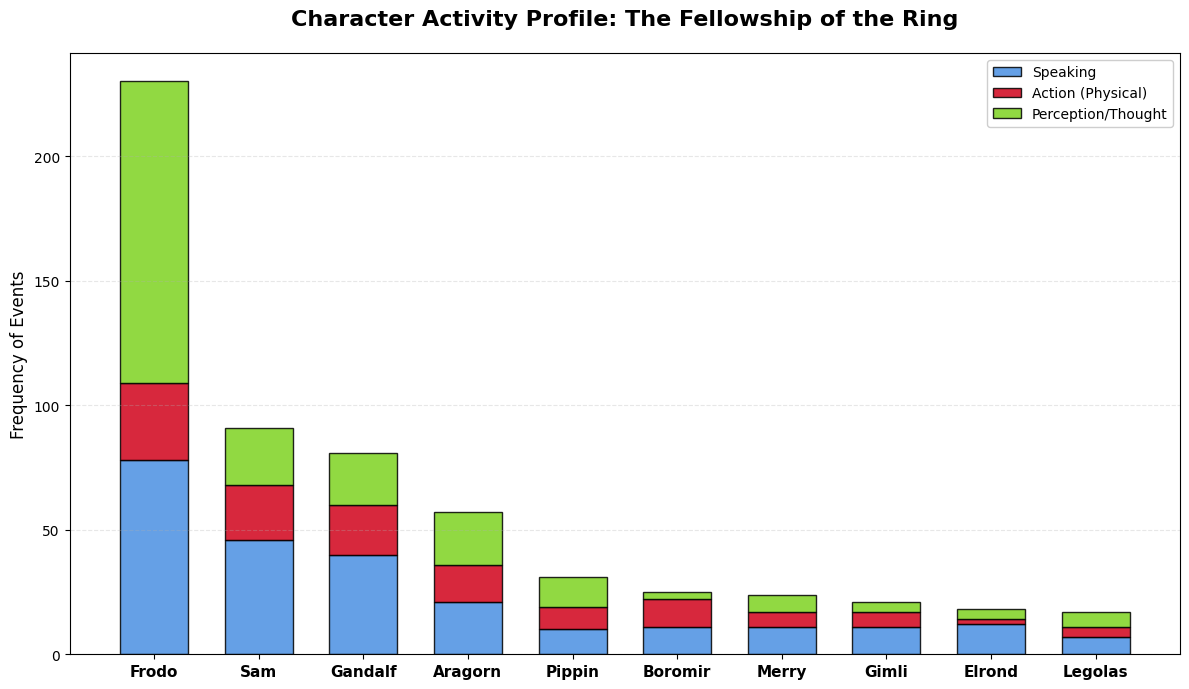


Analyzing The Two Towers...


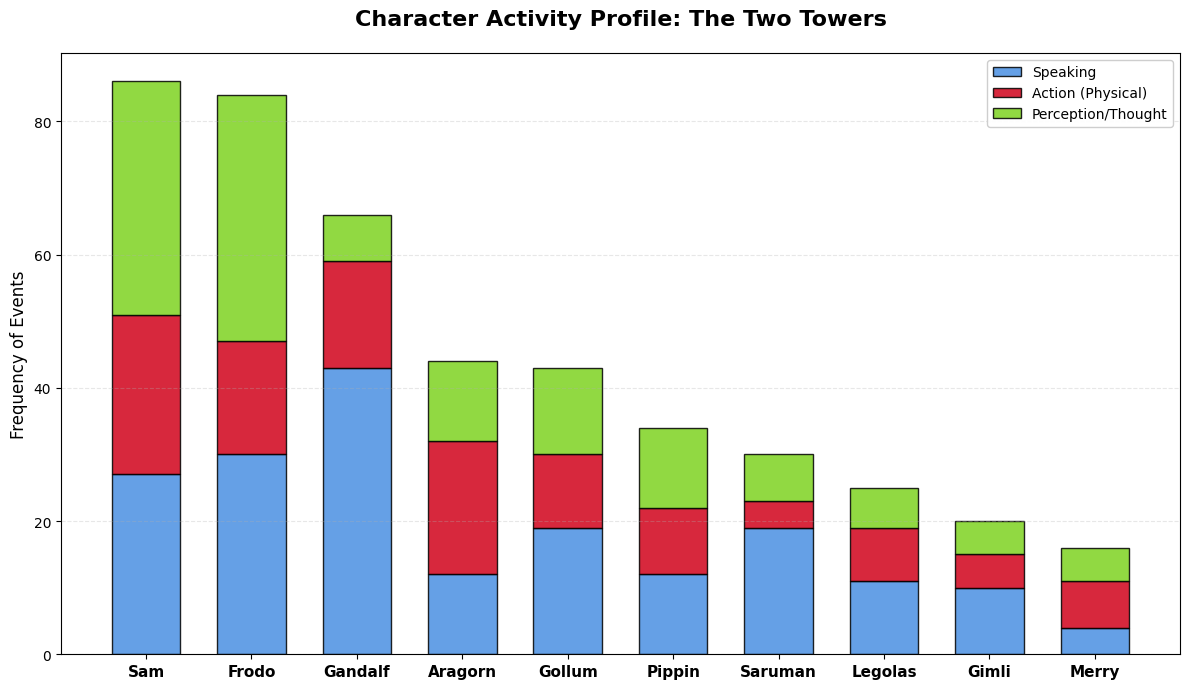


Analyzing The Return of the King...


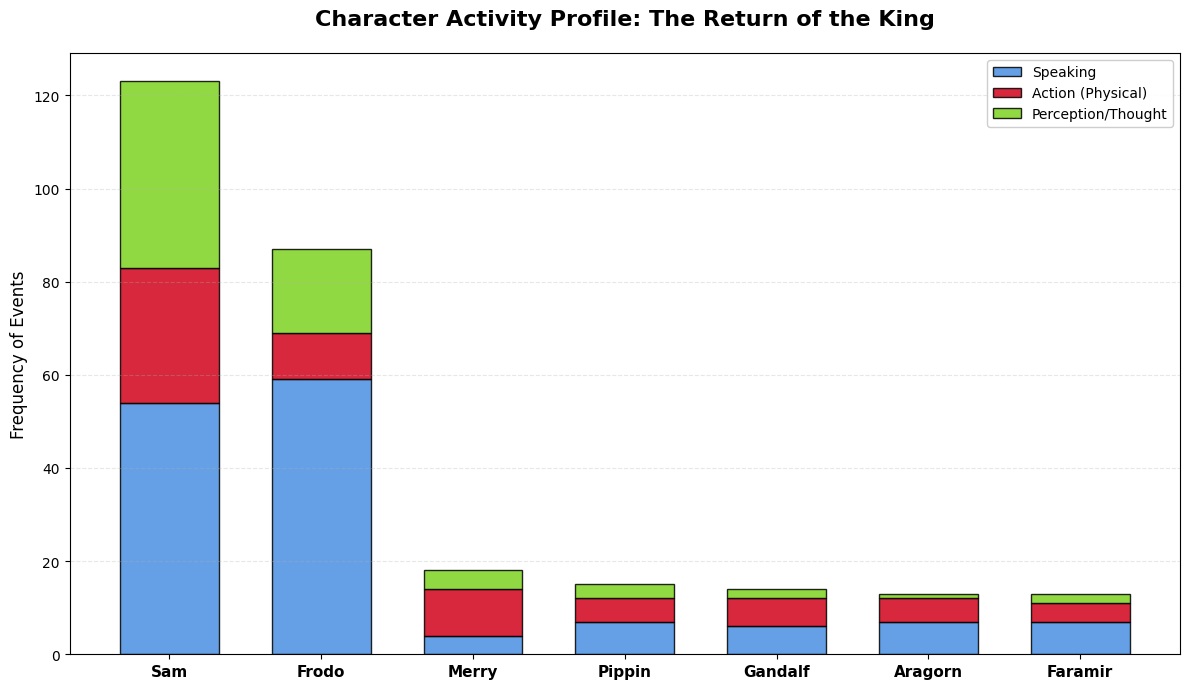

In [12]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# Character Mapping
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"]
}

# Create alias lookup
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# --- VERB DICTIONARIES ---
# We look for these words immediately following a character name
VERB_CATEGORIES = {
    "Speaking": set([
        "said", "asked", "replied", "answered", "cried", "shouted", "whispered", 
        "spoke", "called", "told", "sang", "muttered", "screamed"
    ]),
    "Action (Physical)": set([
        "ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell", 
        "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held", 
        "lifted", "threw", "killed", "jumped", "turned", "stepped"
    ]),
    "Perception/Thought": set([
        "saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched", 
        "noticed", "listened", "wondered", "remembered", "feared", "hoped"
    ])
}

# --- DATA LOADING ---
def clean_and_tokenize(filepath):
    """Loads and tokenizes text."""
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    # Strip headers
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: 
            start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: 
            end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

# --- ANALYSIS LOGIC ---
def analyze_activity(tokens, alias_map, window_after=3):
    """
    Scans for Character + Verb patterns.
    e.g. "Frodo ran" -> Counts as Action for Frodo.
    """
    # Structure: { 'Frodo': {'Speaking': 10, 'Action': 5...}, ... }
    stats = defaultdict(lambda: defaultdict(int))
    
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            
            # Look at the next few words for a verb
            # (We stop at end of list)
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            
            found_verb = False
            for w in next_words:
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        stats[char_name][category] += 1
                        found_verb = True
                        break # Count only the first verb found
                if found_verb:
                    break
                    
    return stats

# --- VISUALIZATION ---
def plot_activity_chart(stats, title, color_theme):
    """
    Creates a Stacked Bar Chart for the top active characters.
    """
    # 1. Filter: Keep only characters with significant activity (> 10 events)
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 10}
    
    if not active_chars:
        print(f"Not enough data to plot {title}")
        return

    # 2. Sort characters by total activity count
    sorted_chars = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)
    
    # Take top 10 for readability
    top_chars = sorted_chars[:10]
    
    # 3. Prepare Data for Plotting
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    
    # Create lists of values for each category
    data = {cat: [] for cat in categories}
    for char in top_chars:
        for cat in categories:
            data[cat].append(active_chars[char][cat])
            
    # 4. Plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    bar_width = 0.65
    indices = np.arange(len(top_chars))
    bottoms = np.zeros(len(top_chars))
    
    # Specific colors for the actions
    # Speaking = Blueish, Action = Reddish, Thought = Grey/Greenish
    act_colors = ['#4a90e2', '#d0021b', '#7ed321']
    
    for i, cat in enumerate(categories):
        values = np.array(data[cat])
        ax.bar(indices, values, bottom=bottoms, label=cat, width=bar_width, 
               color=act_colors[i], edgecolor='black', alpha=0.85)
        bottoms += values # Update bottom for stacking

    # Formatting
    ax.set_title(f"Character Activity Profile: {title}", fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel("Frequency of Events", fontsize=12)
    ax.set_xticks(indices)
    ax.set_xticklabels(top_chars, fontsize=11, fontweight='bold', rotation=0)
    
    # Legend
    ax.legend(loc='upper right', framealpha=0.95, fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Activity Analysis...")

for title, path in books:
    print(f"\nAnalyzing {title}...")
    tokens = clean_and_tokenize(path)
    
    if tokens:
        stats = analyze_activity(tokens, ALIAS_MAP)
        plot_activity_chart(stats, title, None)
    else:
        print("Error: No tokens found.")

Starting Enhanced Activity Analysis...

Analyzing The Fellowship of the Ring...


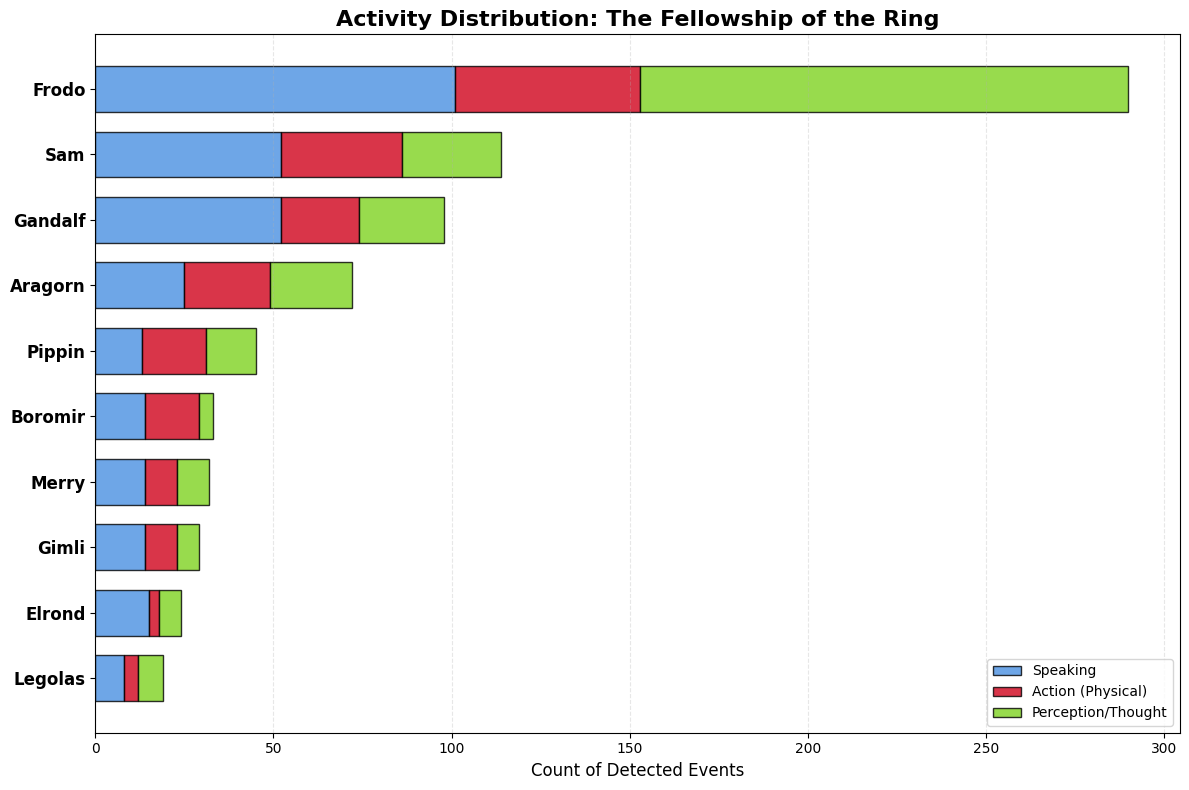

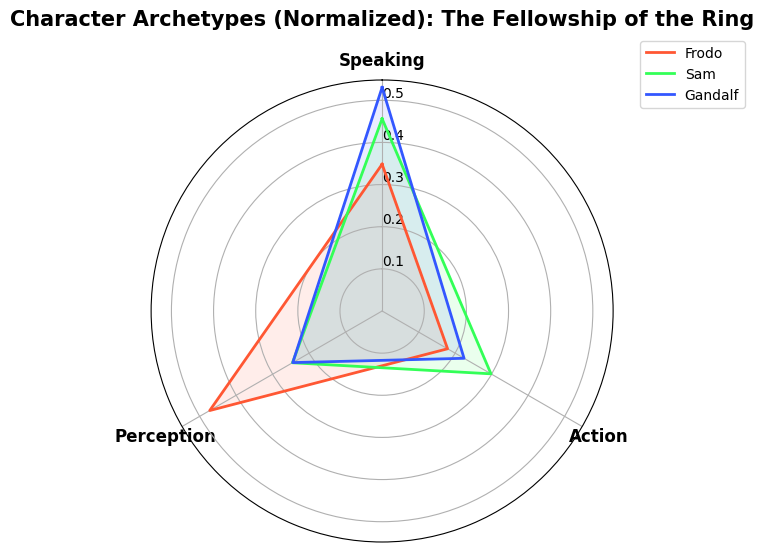


Analyzing The Two Towers...


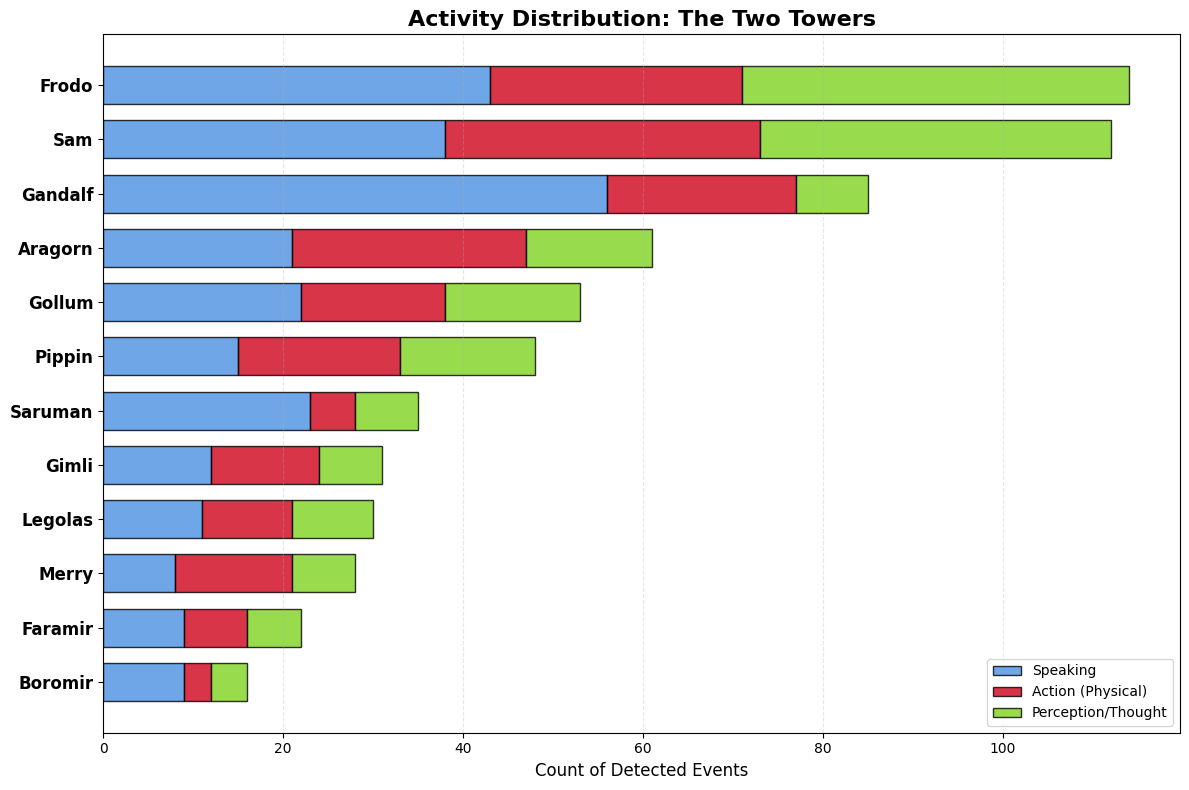

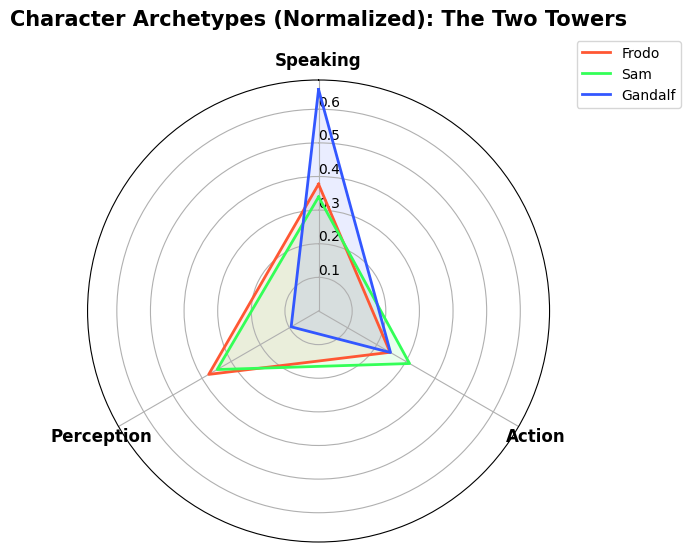


Analyzing The Return of the King...


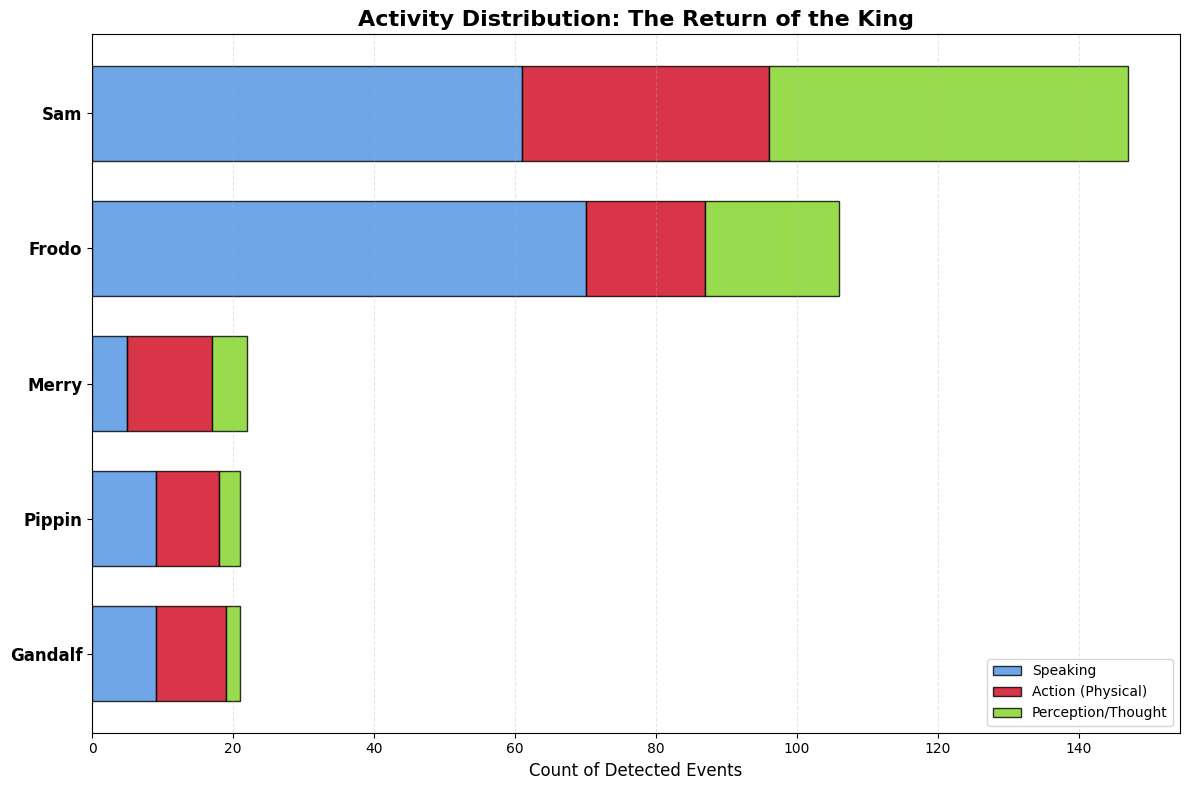

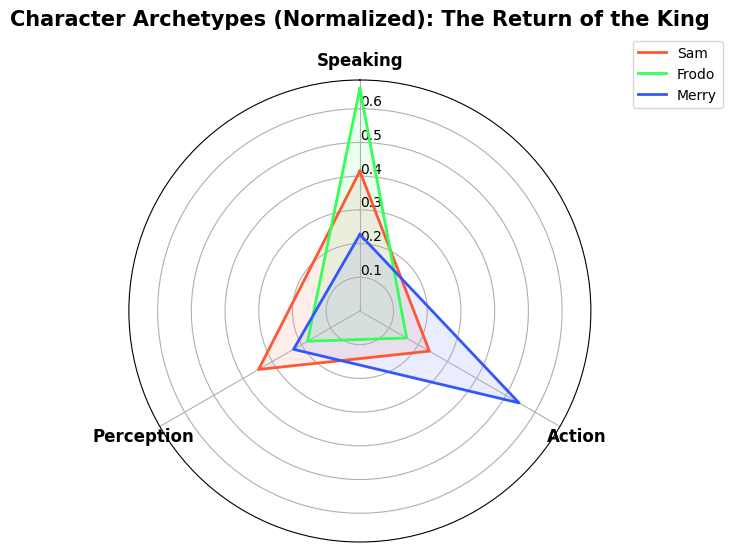

In [13]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# Character Mapping
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"]
}

# Create alias lookup
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# --- IMPROVED VERB DICTIONARIES ---
# Expanded lists for better coverage
VERB_CATEGORIES = {
    "Speaking": set([
        "said", "asked", "replied", "answered", "cried", "shouted", "whispered", 
        "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
        "commanded", "demanded", "begged", "warned", "laughed", "sighed", 
        "continued", "added", "explained", "agreed", "announced"
    ]),
    "Action (Physical)": set([
        "ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell", 
        "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held", 
        "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat", 
        "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed"
    ]),
    "Perception/Thought": set([
        "saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched", 
        "noticed", "listened", "wondered", "remembered", "feared", "hoped",
        "stared", "glanced", "gazed", "perceived", "understood", "believed", 
        "realized", "guessed"
    ])
}

# Words to ignore when scanning window (adverbs, fillers)
SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again"])

# --- DATA LOADING ---
def clean_and_tokenize(filepath):
    """Loads and tokenizes text."""
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    # Strip headers
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: 
            start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: 
            end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

# --- ANALYSIS LOGIC ---
def analyze_activity(tokens, alias_map, window_after=4):
    """
    Scans for Character + Verb patterns with improved skip-logic.
    """
    stats = defaultdict(lambda: defaultdict(int))
    
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            
            # Look at the next few words
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: 
                    continue # Skip adverbs to find the verb
                
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        stats[char_name][category] += 1
                        found_verb = True
                        break 
                if found_verb:
                    break
                    
    return stats

# --- VISUALIZATION 1: Horizontal Stacked Bar ---
def plot_horizontal_activity(stats, title):
    """
    Horizontal Stacked Bar Chart for easier reading of names.
    """
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 15}
    if not active_chars:
        print(f"Not enough data for {title}")
        return

    sorted_chars = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=False) # Ascending for horizontal
    top_chars = sorted_chars[-12:] # Top 12
    
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    data = {cat: [] for cat in categories}
    for char in top_chars:
        for cat in categories:
            data[cat].append(active_chars[char][cat])
            
    fig, ax = plt.subplots(figsize=(12, 8))
    
    bar_width = 0.7
    indices = np.arange(len(top_chars))
    lefts = np.zeros(len(top_chars))
    
    colors = ['#4a90e2', '#d0021b', '#7ed321'] # Blue, Red, Green
    
    for i, cat in enumerate(categories):
        values = np.array(data[cat])
        ax.barh(indices, values, left=lefts, label=cat, height=bar_width, 
               color=colors[i], edgecolor='black', alpha=0.8)
        lefts += values

    ax.set_title(f"Activity Distribution: {title}", fontsize=16, fontweight='bold')
    ax.set_xlabel("Count of Detected Events", fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels(top_chars, fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# --- VISUALIZATION 2: Radar Charts (Spider Plots) ---
def plot_radar_profiles(stats, title):
    """
    Creates Radar Charts for the Top 3 most active characters.
    Shows the 'shape' of their behavior (e.g. Fighter vs Talker).
    """
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 15}
    if not active_chars: return

    # Pick top 3 active chars
    top_3 = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)[:3]
    categories = ["Speaking", "Action", "Perception"] # Shortened labels
    
    # Setup Radar Plot
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # Close loop
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, size=12, fontweight='bold')
    ax.set_rlabel_position(0)
    
    colors = ['#FF5733', '#33FF57', '#3357FF']
    
    for i, char in enumerate(top_3):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]
        
        # Normalize values to compare shape, not just volume
        total = sum(values) if sum(values) > 0 else 1
        norm_values = [v/total for v in values]
        norm_values += norm_values[:1] # Close loop
        
        ax.plot(angles, norm_values, linewidth=2, linestyle='solid', label=char, color=colors[i])
        ax.fill(angles, norm_values, color=colors[i], alpha=0.1)

    plt.title(f"Character Archetypes (Normalized): {title}", size=15, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Enhanced Activity Analysis...")

for title, path in books:
    print(f"\nAnalyzing {title}...")
    tokens = clean_and_tokenize(path)
    
    if tokens:
        stats = analyze_activity(tokens, ALIAS_MAP)
        # Plot 1: Volume & Breakdown
        plot_horizontal_activity(stats, title)
        # Plot 2: Archetype Shape
        plot_radar_profiles(stats, title)
    else:
        print("Error: No tokens found.")

Starting Enhanced Analysis (Female Characters)...

Analyzing The Fellowship of the Ring...

--- Contextual Analysis: The Fellowship of the Ring ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Galadriel       | 38         | 15         | Active participant.
Goldberry       | 31         | 14         | Active participant.
Luthien         | 23         | 5          | Active participant.
Elbereth        | 22         | 7          | Active participant.
Arwen           | 18         | 5          | Active participant.
Lobelia         | 13         | 3          | Active participant.
Gilraen         | 0          | 0          | Historical figure; referenced only in past tense/songs.
--------------------------------------------------------------------------------



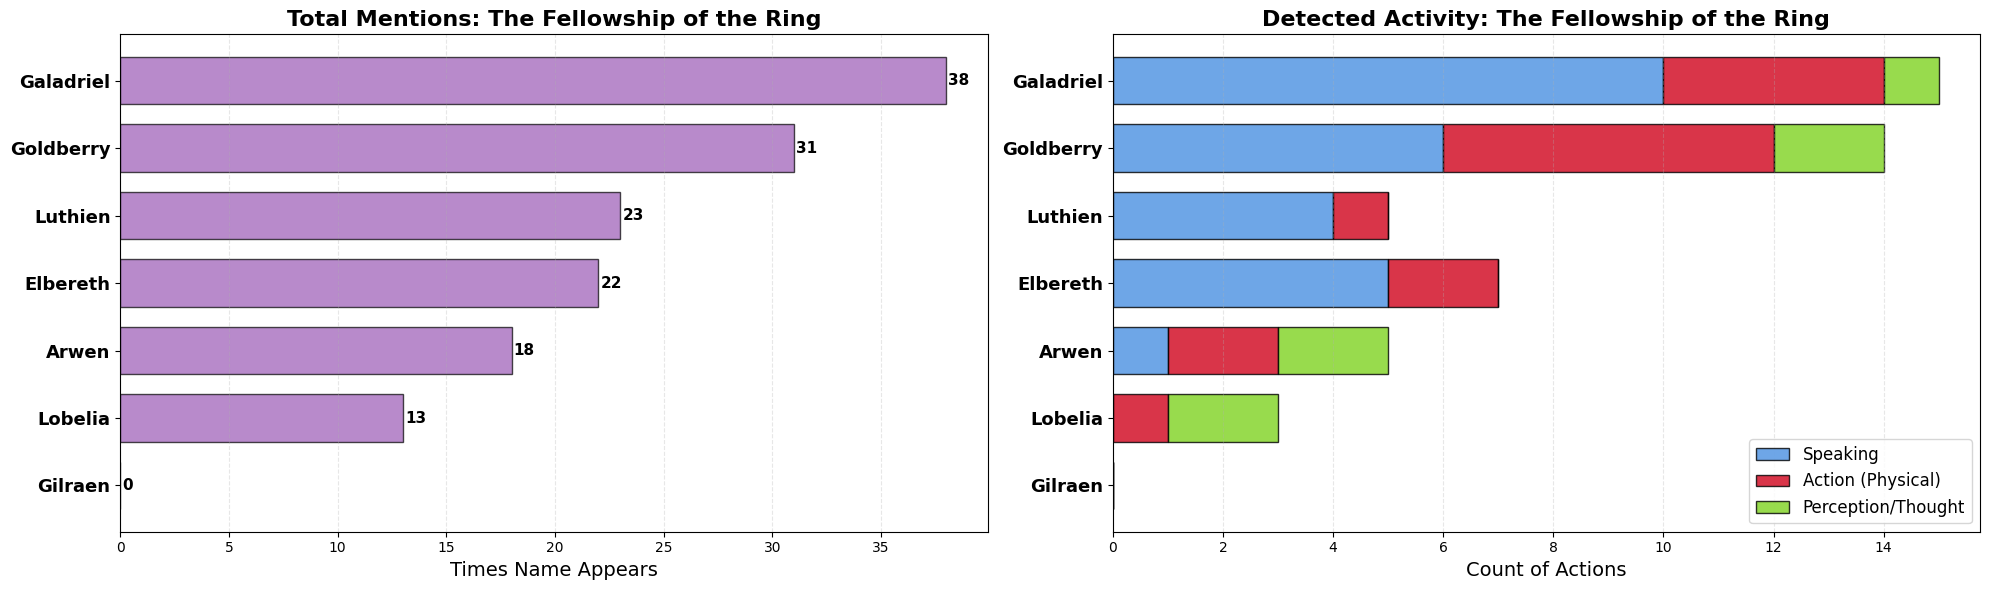


Analyzing The Two Towers...

--- Contextual Analysis: The Two Towers ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Shelob          | 33         | 5          | Active participant.
Galadriel       | 23         | 5          | Active participant.
Elbereth        | 4          | 0          | Deity/Vala. Invoked in prayer/song (e.g., 'O Elbereth!').
Arwen           | 2          | 0          | Appears in Aragorn's memories/dreams, not physical narrative.
Eowyn           | 0          | 0          | Name not detected in text. May be referred to by title or absent from this file.
Luthien         | 0          | 0          | Historical figure; referenced only in past tense/songs.
--------------------------------------------------------------------------------



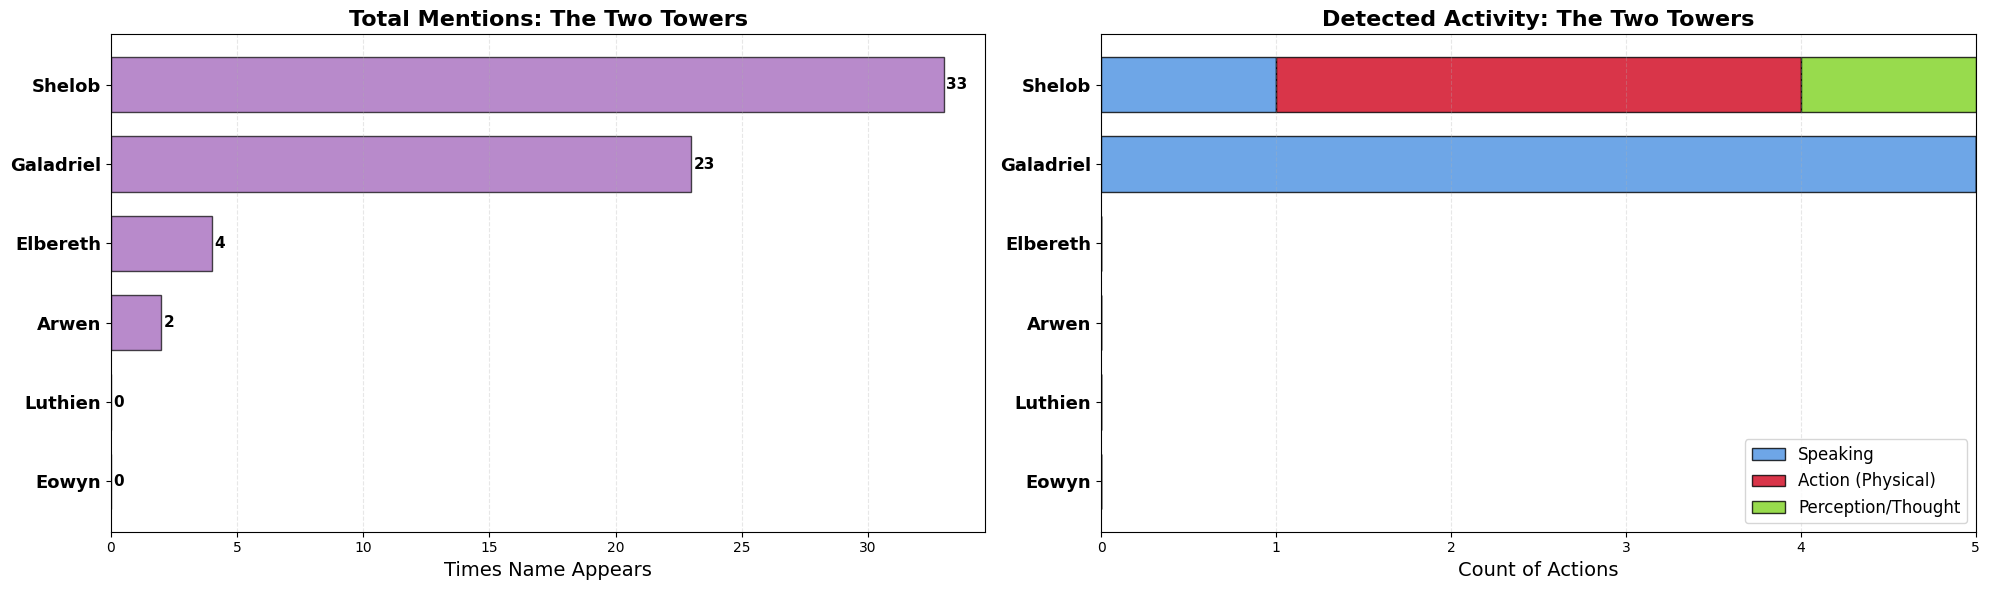


Analyzing The Return of the King...

--- Contextual Analysis: The Return of the King ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Rosie           | 102        | 22         | Active participant.
Galadriel       | 20         | 7          | Active participant.
Arwen           | 19         | 6          | Active participant.
Elbereth        | 9          | 2          | Active participant.
Eowyn           | 4          | 0          | Mentioned by other characters but performs no detected physical actions.
Ioreth          | 4          | 1          | Active participant.
Lobelia         | 2          | 1          | Active participant.
Luthien         | 0          | 0          | Historical figure; referenced only in past tense/songs.
--------------------------------------------------------------------------------



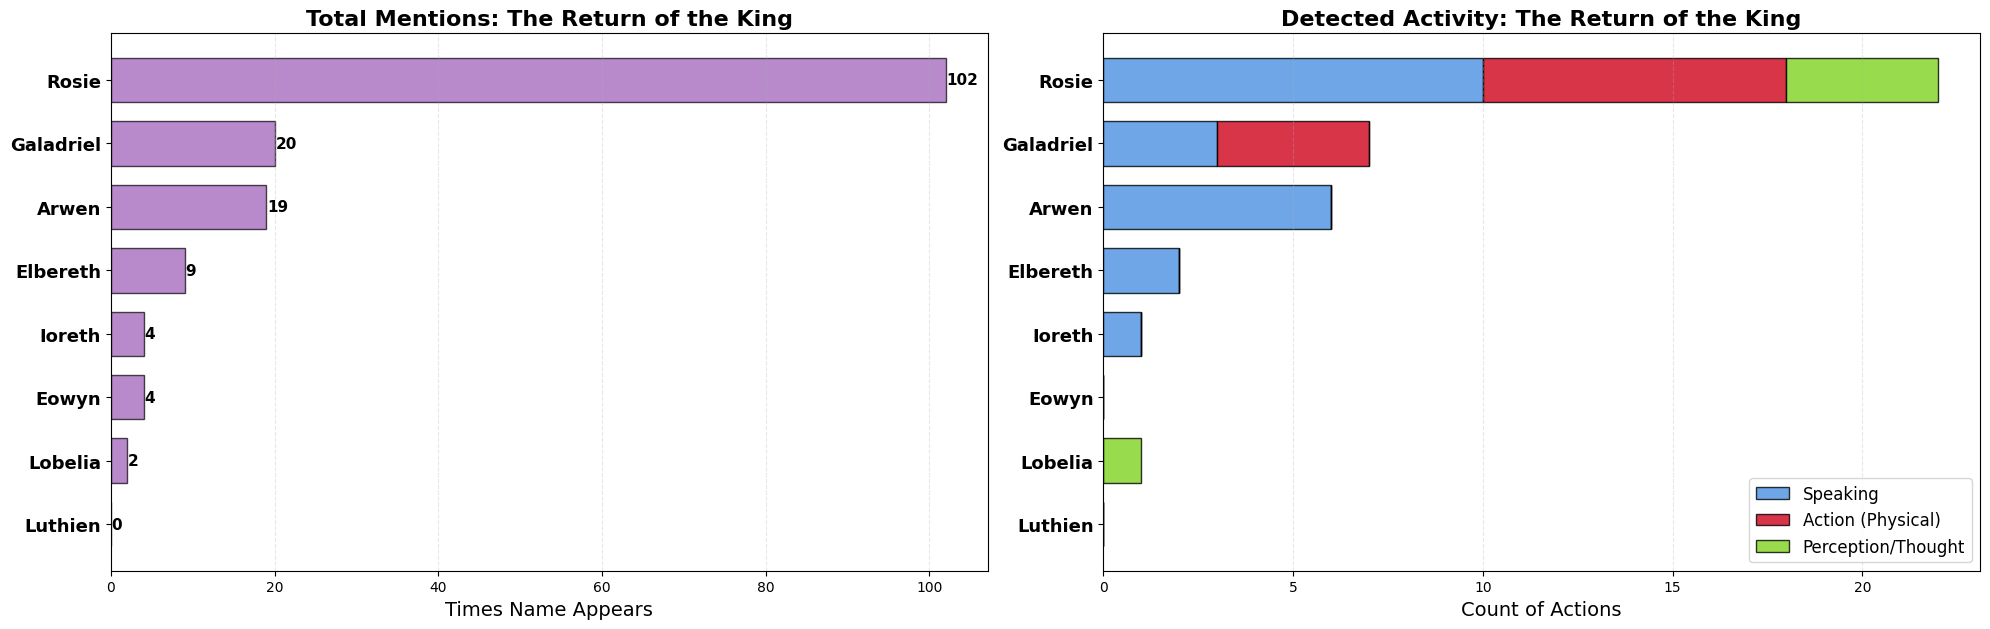

In [27]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# --- MASTER CHARACTER MAPPING ---
# Updated with more specific aliases found in the text
FEMALE_CHARACTERS_COMPREHENSIVE = {
    # Major Active
    "Galadriel": ["galadriel", "lady of light", "lady of the wood", "sorceress of the golden wood", "lady of lorien", "white lady"],
    "Eowyn": ["eowyn", "damsel", "shieldmaiden", "dernhelm", "sister-daughter", "lady of rohan", "white lady of rohan"], 
    "Arwen": ["arwen", "undomiel", "evenstar", "daughter of elrond", "queen"], 
    "Shelob": ["shelob", "spider", "her ladyship"], 
    "Goldberry": ["goldberry", "river-daughter", "river-woman's daughter"], 
    
    # Minor / Supporting / Historical / Deities
    "Rosie": ["rosie", "cotton", "rose", "rosie-lass"], 
    "Ioreth": ["ioreth", "wise-woman", "old wife"], 
    "Lobelia": ["lobelia", "sackville-baggins"], 
    "Primula": ["primula"], 
    "Belladonna": ["belladonna"], 
    "Gilraen": ["gilraen"], 
    "Luthien": ["luthien", "tinuviel", "nightingale"], 
    "Elbereth": ["elbereth", "gilthoniel", "varda", "star-kindler"], # Often invoked
}

# --- BOOK FILTERS ---
# Updated based on actual narrative presence vs mere mention
BOOK_FILTERS = {
    "The Fellowship of the Ring": ["Galadriel", "Goldberry", "Arwen", "Lobelia", "Luthien", "Elbereth", "Gilraen"],
    "The Two Towers": ["Eowyn", "Shelob", "Galadriel", "Arwen", "Elbereth", "Luthien"],
    "The Return of the King": ["Eowyn", "Arwen", "Rosie", "Ioreth", "Lobelia", "Galadriel", "Elbereth", "Luthien"],
}

# --- EXPANDED VERB DICTIONARIES ---
VERB_CATEGORIES = {
    "Speaking": set(["said", "asked", "replied", "answered", "cried", "shouted", "whispered", 
                     "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
                     "commanded", "demanded", "begged", "warned", "laughed", "sighed", 
                     "continued", "added", "explained", "agreed", "announced", "greeting", "wept"]),
    "Action (Physical)": set(["ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell", 
                              "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held", 
                              "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat", 
                              "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed",
                              "went", "came", "gave", "took", "put", "set", "lay", "waited", "passed", "crawled", "stung", "bit"]),
    "Perception/Thought": set(["saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched", 
                               "noticed", "listened", "wondered", "remembered", "feared", "hoped",
                               "stared", "glanced", "gazed", "perceived", "understood", "believed", 
                               "realized", "guessed", "loved", "wished"])
}

SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again", "and", "but", "so", "very"])

# --- DATA LOADING ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

# --- ANALYSIS LOGIC ---
def analyze_activity(tokens, alias_map, window_after=6):
    """
    Scans for Character + Verb patterns.
    """
    activity_stats = defaultdict(lambda: defaultdict(int))
    mention_stats = defaultdict(int)
    
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            mention_stats[char_name] += 1 
            
            # Look at the next few words
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: 
                    continue
                
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        activity_stats[char_name][category] += 1
                        found_verb = True
                        break 
                if found_verb:
                    break
                    
    return activity_stats, mention_stats

# --- EXPLANATION GENERATOR ---
def explain_passive_characters(activity_stats, mention_stats, title, char_list):
    """
    Prints an explanation for characters who appear but have no actions,
    AND characters expected to be in the book but who have 0 mentions.
    """
    print(f"\n--- Contextual Analysis: {title} ---")
    print(f"{'Character':<15} | {'Mentions':<10} | {'Actions':<10} | {'Context/Explanation'}")
    print("-" * 80)
    
    # We use char_list to ensure we check everyone, even those with 0 mentions
    # Sort: Mentions (desc), then Alphabetical
    sorted_chars = sorted(char_list, key=lambda x: mention_stats.get(x, 0), reverse=True)
    
    for char in sorted_chars:
        mentions = mention_stats.get(char, 0)
        
        # Calculate total actions
        actions = sum(activity_stats[char].values()) if char in activity_stats else 0
        explanation = "Active participant."
        
        # LOGIC: Narrative reasons for absence (0 mentions)
        if mentions == 0:
            if char in ["Luthien", "Tinuviel", "Gilraen", "Belladonna", "Primula"]:
                explanation = "Historical figure; referenced only in past tense/songs."
            elif char in ["Elbereth", "Varda"]:
                explanation = "Deity; invoked but not physically present."
            elif char in ["Lobelia", "Rosie", "Goldberry"]:
                explanation = "Location-bound (Shire/Old Forest); absent from this specific segment."
            elif char == "Arwen":
                 explanation = "Limited narrative presence; often appearing only in Appendices."
            elif char == "Eowyn" and "Fellowship" in title:
                 explanation = "Not yet introduced in this volume."
            elif char == "Galadriel" and "Two Towers" in title:
                 explanation = "Appears only in referenced memories, not active scenes."
            else:
                 explanation = "Name not detected in text. May be referred to by title or absent from this file."
        
        # LOGIC: Narrative reasons for passivity (Mentions > 0, Actions == 0)
        elif actions == 0:
            if char in ["Elbereth", "Varda"]:
                explanation = "Deity/Vala. Invoked in prayer/song (e.g., 'O Elbereth!')."
            elif char in ["Luthien", "Tinuviel"]:
                explanation = "Historical figure. Appears in songs/tales told by others."
            elif char == "Gilraen":
                explanation = "Historical figure (Aragorn's mother). Mentioned in memory."
            elif char == "Galadriel" and "Two Towers" in title:
                explanation = "Mentioned by the Fellowship, but not physically present."
            elif char == "Arwen" and "Two Towers" in title:
                explanation = "Appears in Aragorn's memories/dreams, not physical narrative."
            else:
                explanation = "Mentioned by other characters but performs no detected physical actions."
        
        # Print everyone found in the list
        print(f"{char:<15} | {mentions:<10} | {actions:<10} | {explanation}")
    print("-" * 80 + "\n")

# --- VISUALIZATION ---
def plot_comparison(activity_stats, mention_stats, title, char_list):
    """
    Plots two charts: One for Activity (Verbs) and one for Mentions (Presence).
    Displays the plots directly using plt.show().
    """
    # Use ALL characters from the input list, regardless of whether they were found
    # This ensures 0-mention characters appear on the graph.
    found_chars = char_list
    
    if not found_chars:
        print(f"No female characters listed for {title}")
        return

    # Use .get() to handle 0-mention characters safely
    final_activity = {name: activity_stats.get(name, defaultdict(int)) for name in found_chars}
    final_mentions = {name: mention_stats.get(name, 0) for name in found_chars}

    # Sort by MENTIONS so 0s are at the top/bottom grouped together
    sorted_chars = sorted(found_chars, key=lambda x: final_mentions[x], reverse=False)
    
    # --- PLOT SETUP ---
    # Dynamic height based on number of characters
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, max(6, len(sorted_chars) * 0.8)))
    
    indices = np.arange(len(sorted_chars))
    bar_width = 0.7
    
    # --- CHART 1: TOTAL MENTIONS ---
    mention_values = [final_mentions[c] for c in sorted_chars]
    ax1.barh(indices, mention_values, color='#9b59b6', edgecolor='black', height=bar_width, alpha=0.7)
    ax1.set_title(f"Total Mentions: {title}", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Times Name Appears", fontsize=14)
    ax1.set_yticks(indices)
    ax1.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    
    for i, v in enumerate(mention_values):
        ax1.text(v + 0.1, i, str(v), va='center', fontsize=11, fontweight='bold')

    # --- CHART 2: DETECTED ACTIVITY ---
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    colors = ['#4a90e2', '#d0021b', '#7ed321']
    lefts = np.zeros(len(sorted_chars))
    
    for i, cat in enumerate(categories):
        values = np.array([final_activity[c].get(cat, 0) for c in sorted_chars])
        ax2.barh(indices, values, left=lefts, label=cat, height=bar_width, color=colors[i], edgecolor='black', alpha=0.8)
        lefts += values
        
    ax2.set_title(f"Detected Activity: {title}", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Count of Actions", fontsize=14)
    ax2.set_yticks(indices)
    ax2.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=12)
    ax2.grid(axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show() # Corrected back to plt.show() to display graphs directly

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Enhanced Analysis (Female Characters)...")

for title, path in books:
    print(f"\nAnalyzing {title}...")
    relevant_names = BOOK_FILTERS.get(title, [])
    
    # Create Book-Specific Alias Map
    book_alias_map = {}
    for name in relevant_names:
        for alias in FEMALE_CHARACTERS_COMPREHENSIVE.get(name, []):
            book_alias_map[alias] = name
            
    tokens = clean_and_tokenize(path)
    
    if tokens:
        act_stats, men_stats = analyze_activity(tokens, book_alias_map, window_after=6)
        
        # 1. Print the Textual Explanation (Now includes 0-mention chars)
        explain_passive_characters(act_stats, men_stats, title, relevant_names)
        
        # 2. Generate the Charts (Now includes 0-mention chars)
        plot_comparison(act_stats, men_stats, title, relevant_names)
    else:
        print("Error: No tokens found.")

Starting Enhanced Analysis (Female Characters)...

Analyzing The Fellowship of the Ring...

--- Contextual Analysis: The Fellowship of the Ring ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Galadriel       | 38         | 15         | Active participant.
Goldberry       | 31         | 14         | Active participant.
Luthien         | 23         | 5          | Active participant.
Elbereth        | 22         | 7          | Active participant.
Arwen           | 18         | 5          | Active participant.
Lobelia         | 13         | 3          | Active participant.
Gilraen         | 0          | 0          | Deceased (Aragorn's mother). Referenced only in memory/backstory.
--------------------------------------------------------------------------------



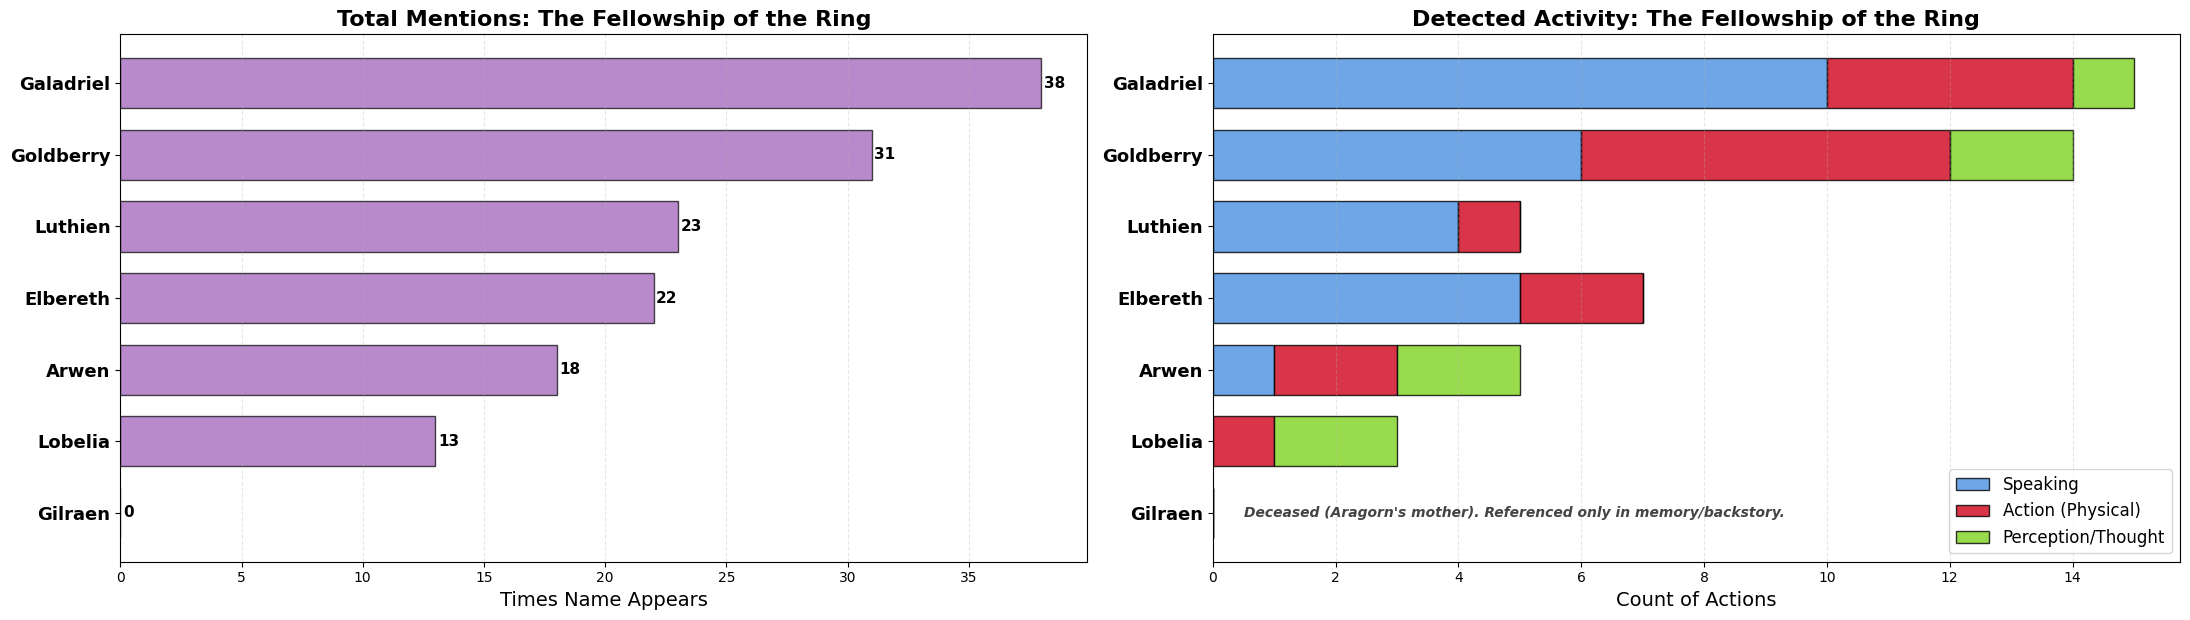


Analyzing The Two Towers...

--- Contextual Analysis: The Two Towers ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Shelob          | 33         | 5          | Active participant.
Galadriel       | 23         | 5          | Active participant.
Elbereth        | 4          | 0          | Invoked as a power/protection (e.g., 'A Elbereth Gilthoniel').
Arwen           | 2          | 0          | Present at Rivendell feast/wedding but has no speaking/action lines.
Eowyn           | 0          | 0          | Absent from this specific textual segment.
Luthien         | 0          | 0          | Historical figure (First Age elf). Subject of legends, deceased in this timeline.
--------------------------------------------------------------------------------



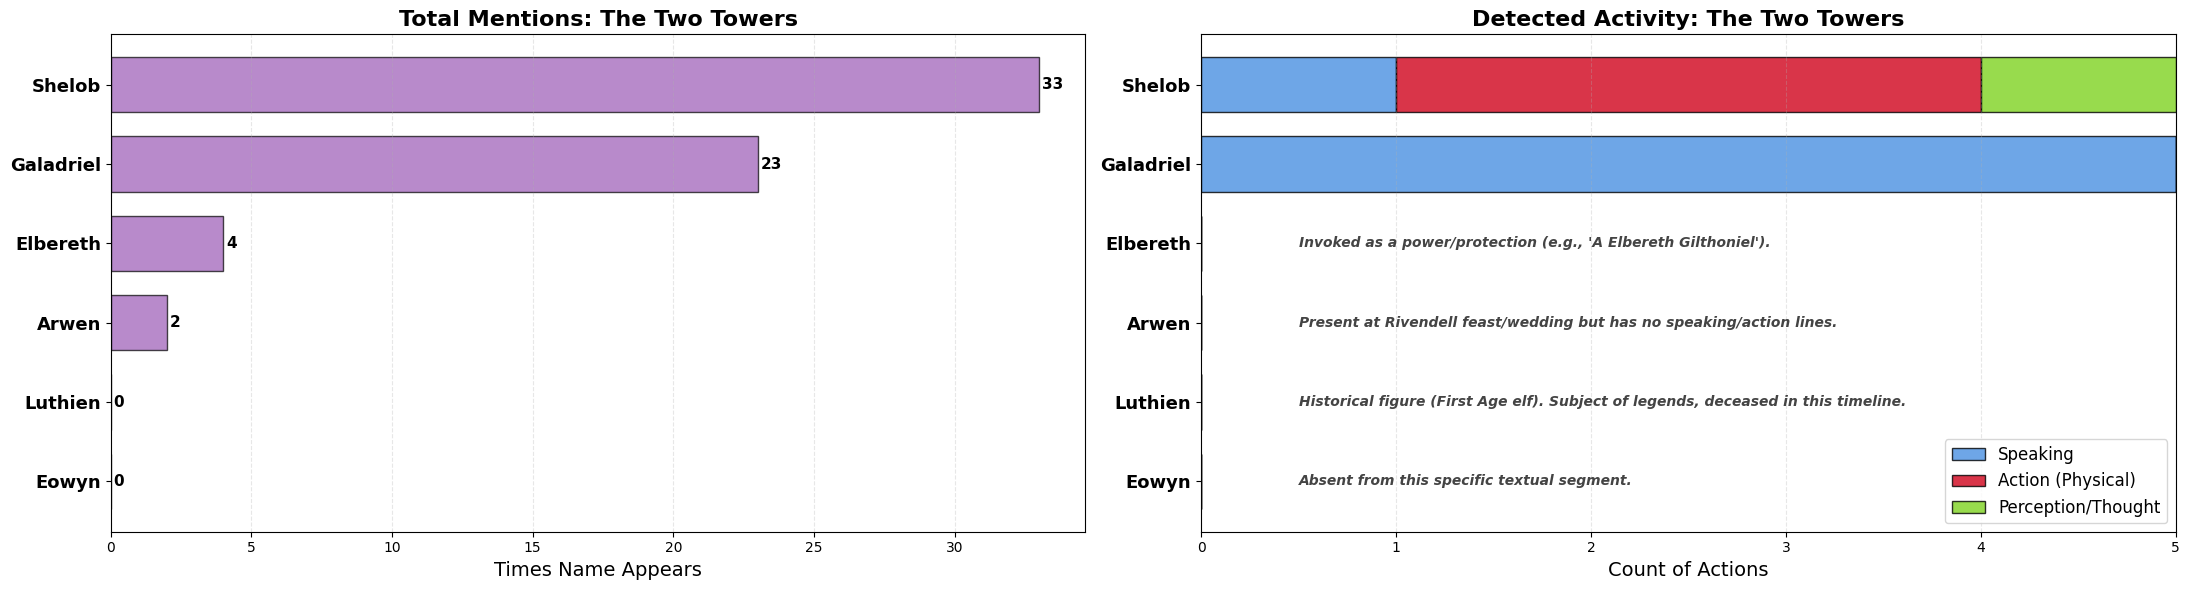


Analyzing The Return of the King...

--- Contextual Analysis: The Return of the King ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Rosie           | 102        | 22         | Active participant.
Galadriel       | 20         | 7          | Active participant.
Arwen           | 19         | 6          | Active participant.
Elbereth        | 9          | 2          | Active participant.
Eowyn           | 4          | 0          | Mentioned by others but performs no detected physical actions.
Ioreth          | 4          | 1          | Active participant.
Lobelia         | 2          | 1          | Active participant.
Luthien         | 0          | 0          | Historical figure (First Age elf). Subject of legends, deceased in this timeline.
--------------------------------------------------------------------------------



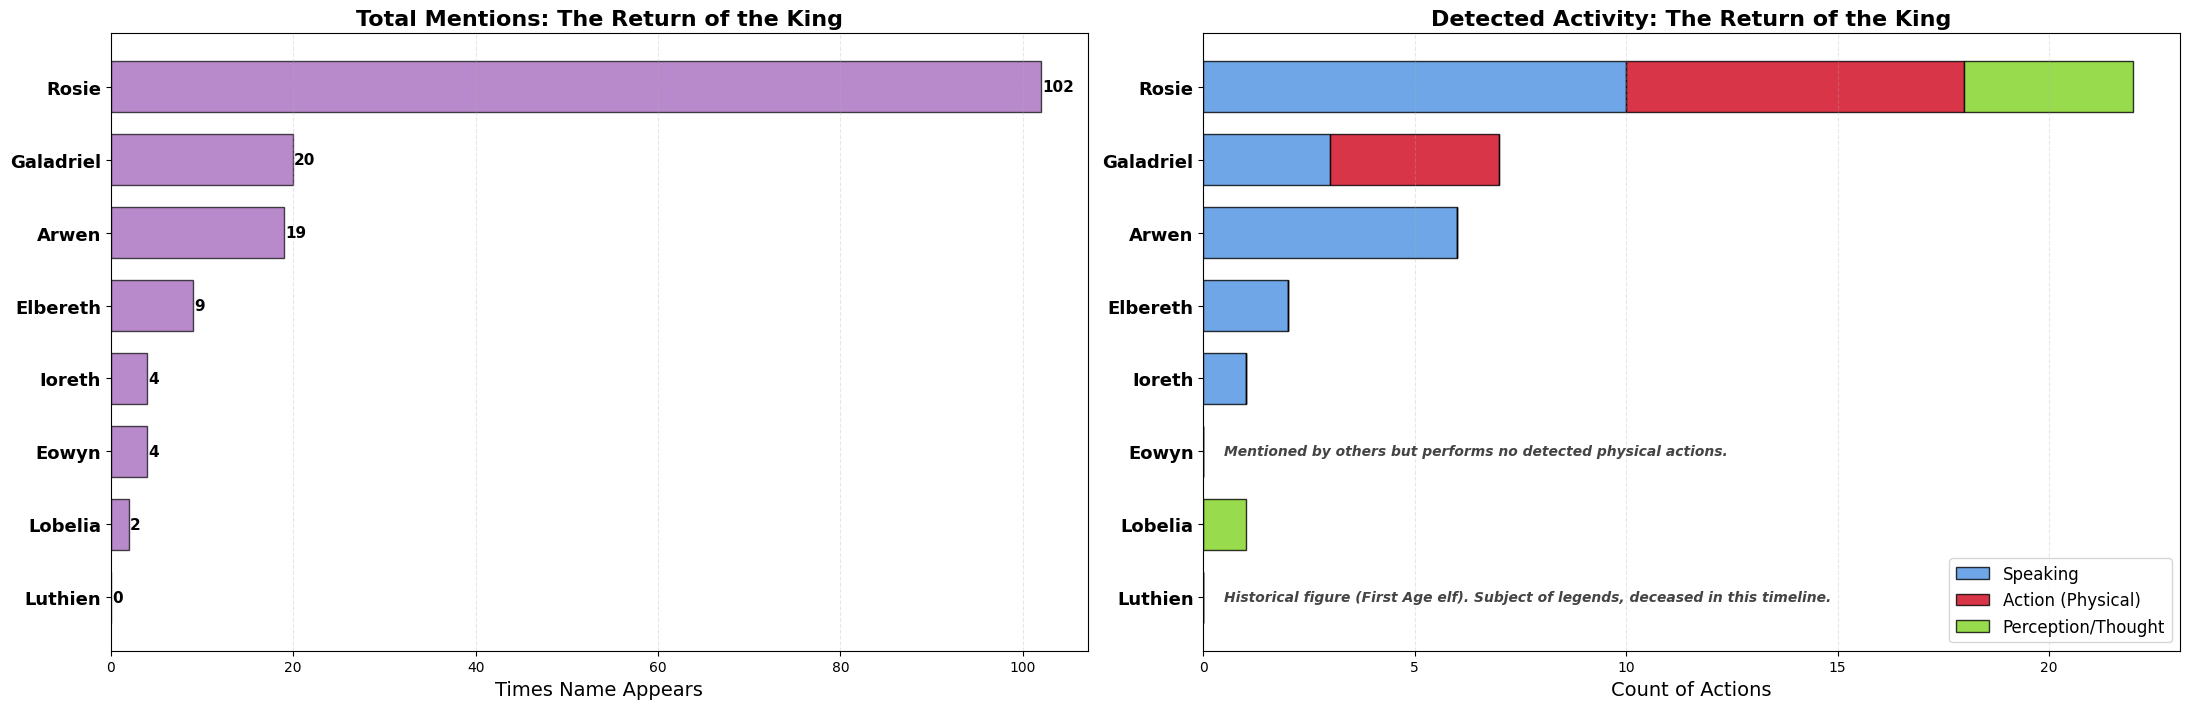

In [2]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# --- MASTER CHARACTER MAPPING ---
FEMALE_CHARACTERS_COMPREHENSIVE = {
    "Galadriel": ["galadriel", "lady of light", "lady of the wood", "sorceress of the golden wood", "lady of lorien", "white lady"],
    "Eowyn": ["eowyn", "damsel", "shieldmaiden", "dernhelm", "sister-daughter", "lady of rohan", "white lady of rohan"], 
    "Arwen": ["arwen", "undomiel", "evenstar", "daughter of elrond", "queen"], 
    "Shelob": ["shelob", "spider", "her ladyship"], 
    "Goldberry": ["goldberry", "river-daughter", "river-woman's daughter"], 
    "Rosie": ["rosie", "cotton", "rose", "rosie-lass"], 
    "Ioreth": ["ioreth", "wise-woman", "old wife"], 
    "Lobelia": ["lobelia", "sackville-baggins"], 
    "Primula": ["primula"], 
    "Belladonna": ["belladonna"], 
    "Gilraen": ["gilraen"], 
    "Luthien": ["luthien", "tinuviel", "nightingale"], 
    "Elbereth": ["elbereth", "gilthoniel", "varda", "star-kindler"], 
}

# --- BOOK FILTERS ---
BOOK_FILTERS = {
    "The Fellowship of the Ring": ["Galadriel", "Goldberry", "Arwen", "Lobelia", "Luthien", "Elbereth", "Gilraen"],
    "The Two Towers": ["Eowyn", "Shelob", "Galadriel", "Arwen", "Elbereth", "Luthien"],
    "The Return of the King": ["Eowyn", "Arwen", "Rosie", "Ioreth", "Lobelia", "Galadriel", "Elbereth", "Luthien"],
}

# --- EXPANDED VERB DICTIONARIES ---
VERB_CATEGORIES = {
    "Speaking": set(["said", "asked", "replied", "answered", "cried", "shouted", "whispered", 
                     "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
                     "commanded", "demanded", "begged", "warned", "laughed", "sighed", 
                     "continued", "added", "explained", "agreed", "announced", "greeting", "wept"]),
    "Action (Physical)": set(["ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell", 
                              "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held", 
                              "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat", 
                              "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed",
                              "went", "came", "gave", "took", "put", "set", "lay", "waited", "passed", "crawled", "stung", "bit"]),
    "Perception/Thought": set(["saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched", 
                               "noticed", "listened", "wondered", "remembered", "feared", "hoped",
                               "stared", "glanced", "gazed", "perceived", "understood", "believed", 
                               "realized", "guessed", "loved", "wished"])
}

SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again", "and", "but", "so", "very"])

# --- DATA LOADING ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

# --- ANALYSIS LOGIC ---
def analyze_activity(tokens, alias_map, window_after=6):
    activity_stats = defaultdict(lambda: defaultdict(int))
    mention_stats = defaultdict(int)
    
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            mention_stats[char_name] += 1 
            
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: continue
                
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        activity_stats[char_name][category] += 1
                        found_verb = True
                        break 
                if found_verb: break
                    
    return activity_stats, mention_stats

# --- LOGIC HELPER ---
def get_status_explanation(char, title, mentions, actions):
    """Returns the lore-accurate explanation string."""
    if mentions == 0:
        if char == "Eowyn" and "Fellowship" in title:
            return "Not yet introduced. First appears in 'The Two Towers' at Edoras."
        elif char == "Shelob" and ("Fellowship" in title or "Return" in title):
            return "Encountered only in the specific sequence at Cirith Ungol (end of Book IV)."
        elif char == "Galadriel" and "Two Towers" in title:
            return "Physically in Lothlórien. Sends messages via Gandalf, but has no scenes."
        elif char == "Arwen":
            if "Fellowship" in title: return "Replaced by Glorfindel at the Ford. Passive in Rivendell scenes."
            else: return "Remains in Rivendell. Narrative follows the Fellowship/War."
        elif char == "Goldberry" and ("Two Towers" in title or "Return" in title):
            return "Bound to the Old Forest/Withywindle. Does not leave her domain."
        elif char in ["Rosie", "Lobelia"]:
            return "Located in the Shire. Absent from the main quest until the Scouring."
        elif char in ["Luthien", "Tinuviel"]:
            return "Historical figure (First Age elf). Subject of legends, deceased in this timeline."
        elif char == "Gilraen":
            return "Deceased (Aragorn's mother). Referenced only in memory/backstory."
        elif char in ["Belladonna", "Primula"]:
            return "Deceased (Bilbo/Frodo's mother). Referenced in family trees/history."
        elif char in ["Elbereth", "Varda"]:
            return "Deity (Vala). Invoked in spirit, never physically present."
        else:
            return "Absent from this specific textual segment."

    elif actions == 0:
        if char == "Arwen":
            return "Present at Rivendell feast/wedding but has no speaking/action lines."
        elif char == "Galadriel":
            return "Referenced by the Fellowship (e.g. Gimli's praise) but not present."
        elif char in ["Elbereth", "Varda"]:
            return "Invoked as a power/protection (e.g., 'A Elbereth Gilthoniel')."
        elif char in ["Luthien", "Tinuviel"]:
            return "Subject of the 'Lay of Leithian' sung by Aragorn/referenced by Sam."
        elif char == "Gilraen":
            return "Mentioned in Aragorn's backstory/lineage (his mother)."
        elif char == "Shelob":
            return "Referenced with dread before the actual encounter begins."
        else:
            return "Mentioned by others but performs no detected physical actions."
            
    return "Active participant."

# --- EXPLANATION GENERATOR ---
def explain_passive_characters(activity_stats, mention_stats, title, char_list):
    print(f"\n--- Contextual Analysis: {title} ---")
    print(f"{'Character':<15} | {'Mentions':<10} | {'Actions':<10} | {'Context/Explanation'}")
    print("-" * 80)
    
    sorted_chars = sorted(char_list, key=lambda x: mention_stats.get(x, 0), reverse=True)
    
    for char in sorted_chars:
        mentions = mention_stats.get(char, 0)
        actions = sum(activity_stats[char].values()) if char in activity_stats else 0
        
        explanation = get_status_explanation(char, title, mentions, actions)
        
        print(f"{char:<15} | {mentions:<10} | {actions:<10} | {explanation}")
    print("-" * 80 + "\n")

# --- VISUALIZATION ---
def plot_comparison(activity_stats, mention_stats, title, char_list):
    found_chars = char_list
    if not found_chars:
        print(f"No female characters listed for {title}")
        return

    final_activity = {name: activity_stats.get(name, defaultdict(int)) for name in found_chars}
    final_mentions = {name: mention_stats.get(name, 0) for name in found_chars}
    
    # Sort by Mentions
    sorted_chars = sorted(found_chars, key=lambda x: final_mentions[x], reverse=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, max(6, len(sorted_chars) * 0.9))) # Increased width for text
    
    indices = np.arange(len(sorted_chars))
    bar_width = 0.7
    
    # --- CHART 1: TOTAL MENTIONS ---
    mention_values = [final_mentions[c] for c in sorted_chars]
    ax1.barh(indices, mention_values, color='#9b59b6', edgecolor='black', height=bar_width, alpha=0.7)
    ax1.set_title(f"Total Mentions: {title}", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Times Name Appears", fontsize=14)
    ax1.set_yticks(indices)
    ax1.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    
    for i, v in enumerate(mention_values):
        ax1.text(v + 0.1, i, str(v), va='center', fontsize=11, fontweight='bold')

    # --- CHART 2: DETECTED ACTIVITY ---
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    colors = ['#4a90e2', '#d0021b', '#7ed321']
    lefts = np.zeros(len(sorted_chars))
    
    for i, cat in enumerate(categories):
        values = np.array([final_activity[c].get(cat, 0) for c in sorted_chars])
        ax2.barh(indices, values, left=lefts, label=cat, height=bar_width, color=colors[i], edgecolor='black', alpha=0.8)
        lefts += values
        
    ax2.set_title(f"Detected Activity: {title}", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Count of Actions", fontsize=14)
    ax2.set_yticks(indices)
    ax2.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=12)
    ax2.grid(axis='x', linestyle='--', alpha=0.3)
    
    # --- ANNOTATION LOOP ---
    # Add text to the Activity Graph for inactive characters
    for i, char in enumerate(sorted_chars):
        mentions = final_mentions[char]
        actions = sum(final_activity[char].values())
        
        # Only annotate if "not active participant" (Actions == 0)
        if actions == 0:
            reason = get_status_explanation(char, title, mentions, actions)
            # Place text slightly to the right of the y-axis (since bar is 0 width)
            ax2.text(0.5, i, reason, va='center', fontsize=10, style='italic', color='#444444', fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Enhanced Analysis (Female Characters)...")

for title, path in books:
    print(f"\nAnalyzing {title}...")
    relevant_names = BOOK_FILTERS.get(title, [])
    
    book_alias_map = {}
    for name in relevant_names:
        for alias in FEMALE_CHARACTERS_COMPREHENSIVE.get(name, []):
            book_alias_map[alias] = name
            
    tokens = clean_and_tokenize(path)
    
    if tokens:
        act_stats, men_stats = analyze_activity(tokens, book_alias_map, window_after=6)
        explain_passive_characters(act_stats, men_stats, title, relevant_names)
        plot_comparison(act_stats, men_stats, title, relevant_names)
    else:
        print("Error: No tokens found.")

Starting Enhanced Analysis (Female Characters)...

Analyzing The Fellowship of the Ring...

--- Contextual Analysis: The Fellowship of the Ring ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Galadriel       | 38         | 15         | Active participant.
Goldberry       | 31         | 14         | Active participant.
Luthien         | 23         | 5          | Active participant.
Elbereth        | 22         | 7          | Active participant.
Arwen           | 18         | 5          | Active participant.
Lobelia         | 13         | 3          | Active participant.
--------------------------------------------------------------------------------



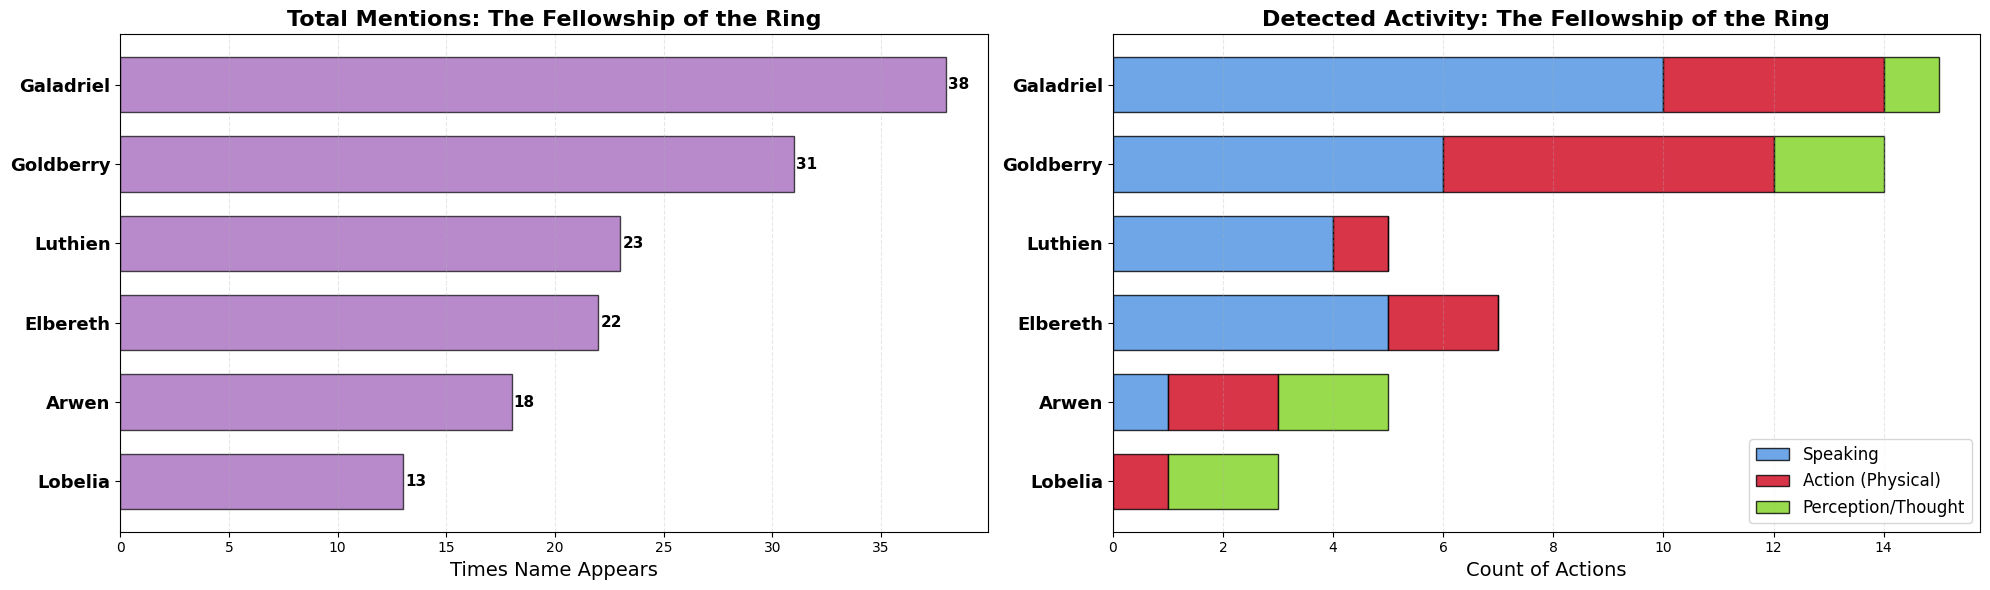

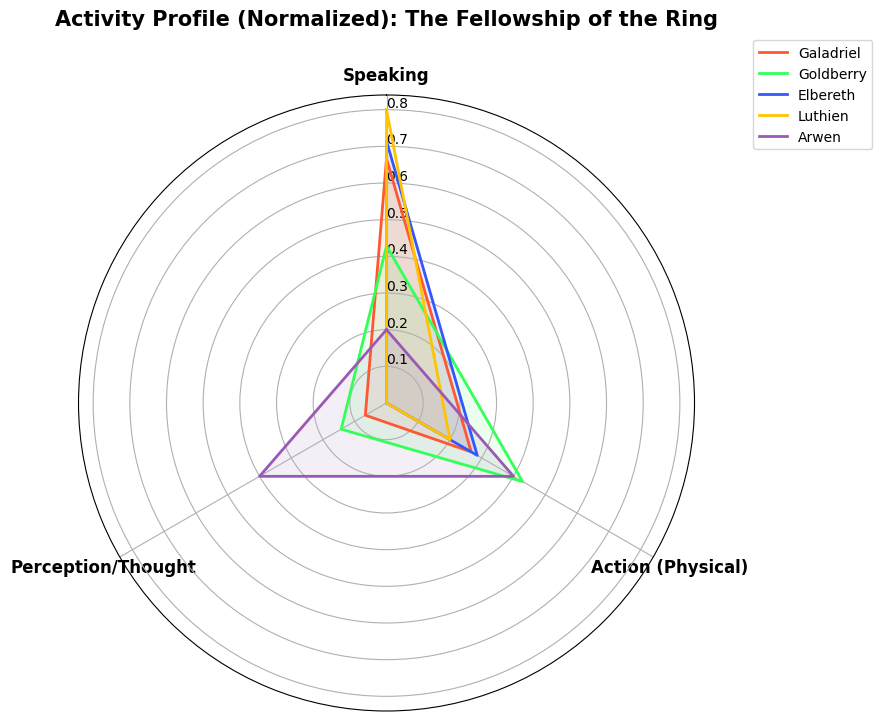


Analyzing The Two Towers...

--- Contextual Analysis: The Two Towers ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Shelob          | 33         | 5          | Active participant.
Galadriel       | 23         | 5          | Active participant.
Elbereth        | 4          | 0          | Deity/Vala. Invoked in prayer/song (e.g., 'O Elbereth!'). Passive presence.
Arwen           | 2          | 0          | Appears in Aragorn's memories/dreams, not physical narrative.
--------------------------------------------------------------------------------



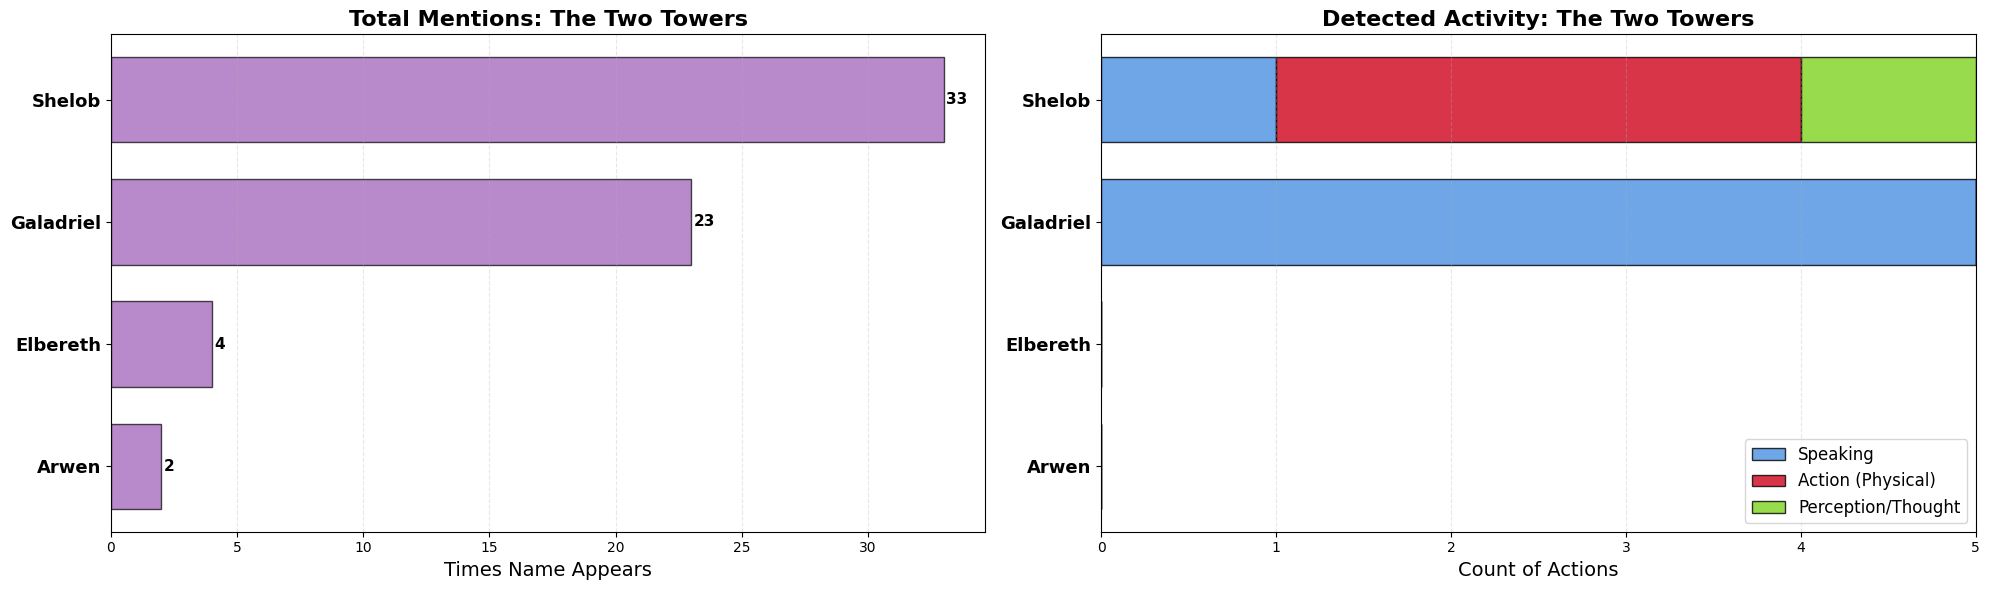

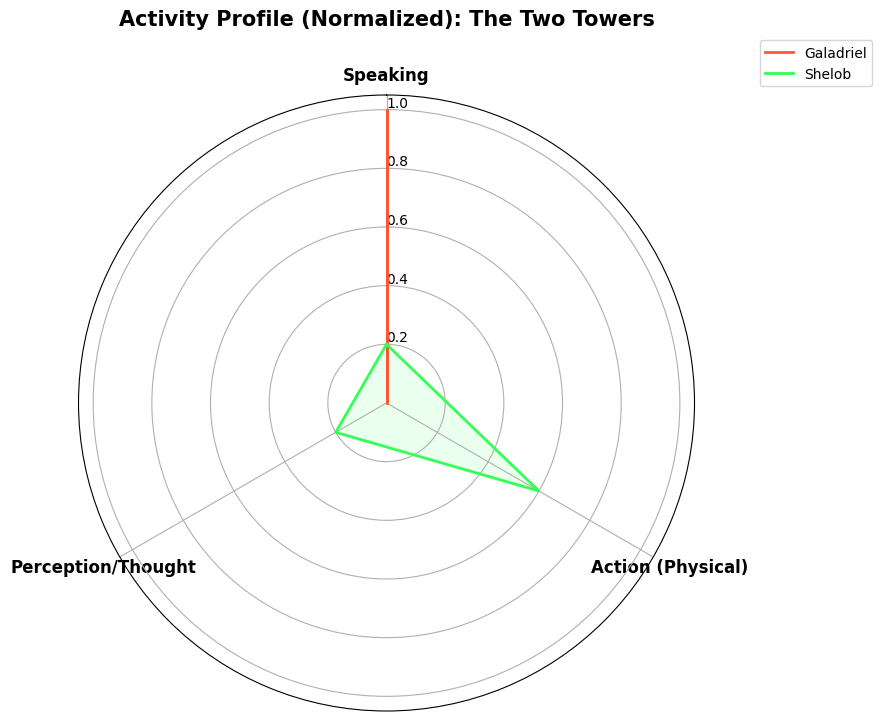


Analyzing The Return of the King...

--- Contextual Analysis: The Return of the King ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Rosie           | 102        | 22         | Active participant.
Galadriel       | 20         | 7          | Active participant.
Arwen           | 19         | 6          | Active participant.
Elbereth        | 9          | 2          | Active participant.
Eowyn           | 4          | 0          | Mentioned by other characters but performs no detected physical actions.
Ioreth          | 4          | 1          | Active participant.
Lobelia         | 2          | 1          | Active participant.
--------------------------------------------------------------------------------



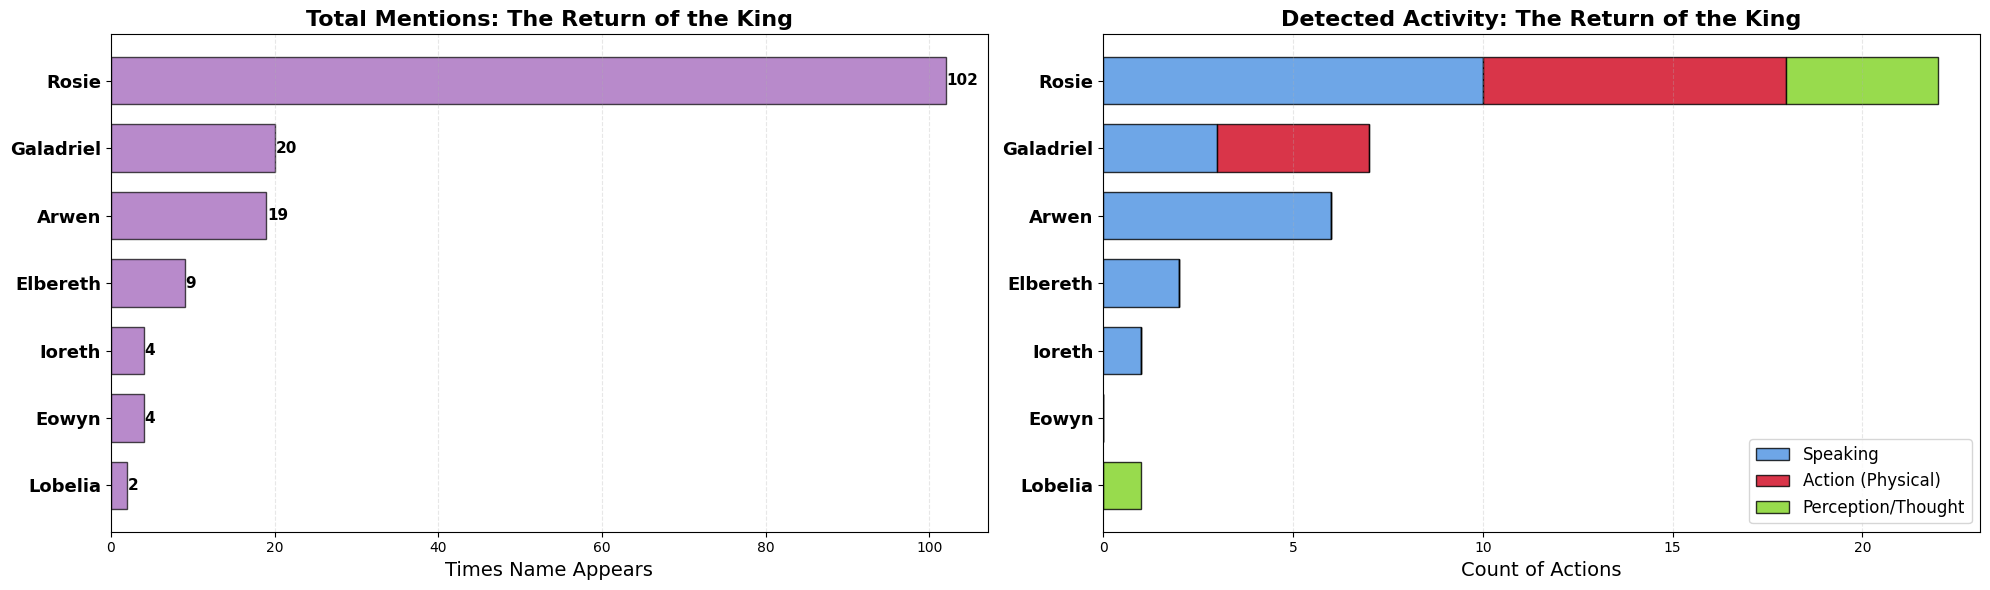

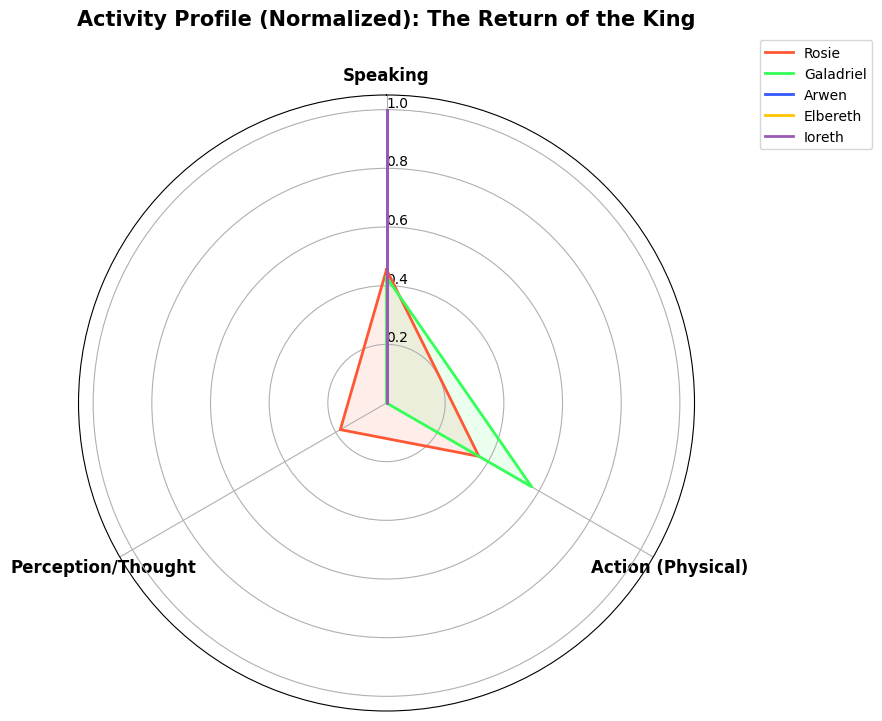

In [3]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",

}

# --- MASTER CHARACTER MAPPING ---
# Updated with more specific aliases found in the text
FEMALE_CHARACTERS_COMPREHENSIVE = {
    # Major Active
    "Galadriel": ["galadriel", "lady of light", "lady of the wood", "sorceress of the golden wood", "lady of lorien", "white lady"],
    "Eowyn": ["eowyn", "damsel", "shieldmaiden", "dernhelm", "sister-daughter", "lady of rohan", "white lady of rohan"], 
    "Arwen": ["arwen", "undomiel", "evenstar", "daughter of elrond", "queen"], 
    "Shelob": ["shelob", "spider", "her ladyship"], 
    "Goldberry": ["goldberry", "river-daughter", "river-woman's daughter"], 
    
    # Minor / Supporting / Historical / Deities
    "Rosie": ["rosie", "cotton", "rose", "rosie-lass"], 
    "Ioreth": ["ioreth", "wise-woman", "old wife"], 
    "Lobelia": ["lobelia", "sackville-baggins"], 
    "Primula": ["primula"], 
    "Belladonna": ["belladonna"], 
    "Gilraen": ["gilraen"], 
    "Luthien": ["luthien", "tinuviel", "nightingale"], 
    "Elbereth": ["elbereth", "gilthoniel", "varda", "star-kindler"], # Often invoked
}

# --- BOOK FILTERS ---
# Updated based on actual narrative presence vs mere mention
BOOK_FILTERS = {
    "The Fellowship of the Ring": ["Galadriel", "Goldberry", "Arwen", "Lobelia", "Luthien", "Elbereth", "Gilraen"],
    "The Two Towers": ["Eowyn", "Shelob", "Galadriel", "Arwen", "Elbereth", "Luthien"],
    "The Return of the King": ["Eowyn", "Arwen", "Rosie", "Ioreth", "Lobelia", "Galadriel", "Elbereth", "Luthien"],
}

# --- EXPANDED VERB DICTIONARIES ---
VERB_CATEGORIES = {
    "Speaking": set(["said", "asked", "replied", "answered", "cried", "shouted", "whispered", 
                     "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
                     "commanded", "demanded", "begged", "warned", "laughed", "sighed", 
                     "continued", "added", "explained", "agreed", "announced", "greeting", "wept"]),
    "Action (Physical)": set(["ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell", 
                              "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held", 
                              "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat", 
                              "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed",
                              "went", "came", "gave", "took", "put", "set", "lay", "waited", "passed", "crawled", "stung", "bit"]),
    "Perception/Thought": set(["saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched", 
                               "noticed", "listened", "wondered", "remembered", "feared", "hoped",
                               "stared", "glanced", "gazed", "perceived", "understood", "believed", 
                               "realized", "guessed", "loved", "wished"])
}

SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again", "and", "but", "so", "very"])

# --- DATA LOADING ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

# --- ANALYSIS LOGIC ---
def analyze_activity(tokens, alias_map, window_after=6):
    """
    Scans for Character + Verb patterns.
    """
    activity_stats = defaultdict(lambda: defaultdict(int))
    mention_stats = defaultdict(int)
    
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            mention_stats[char_name] += 1 
            
            # Look at the next few words
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: 
                    continue
                
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        activity_stats[char_name][category] += 1
                        found_verb = True
                        break 
                if found_verb:
                    break
                    
    return activity_stats, mention_stats

# --- EXPLANATION GENERATOR ---
def explain_passive_characters(activity_stats, mention_stats, title):
    """
    Prints an explanation for characters who appear but have no actions.
    """
    print(f"\n--- Contextual Analysis: {title} ---")
    print(f"{'Character':<15} | {'Mentions':<10} | {'Actions':<10} | {'Context/Explanation'}")
    print("-" * 80)
    
    sorted_chars = sorted(mention_stats.keys(), key=lambda x: mention_stats[x], reverse=True)
    
    for char in sorted_chars:
        mentions = mention_stats[char]
        if mentions == 0: continue
        
        actions = sum(activity_stats[char].values())
        explanation = "Active participant."
        
        if actions == 0:
            if char in ["Elbereth", "Varda"]:
                explanation = "Deity/Vala. Invoked in prayer/song (e.g., 'O Elbereth!'). Passive presence."
            elif char in ["Luthien", "Tinuviel"]:
                explanation = "Historical figure. Appears in songs/tales told by others."
            elif char == "Gilraen":
                explanation = "Historical figure (Aragorn's mother). Mentioned in memory."
            elif char == "Galadriel" and "Two Towers" in title:
                explanation = "Mentioned by the Fellowship/Saruman, but not physically present in scenes."
            elif char == "Arwen" and "Two Towers" in title:
                explanation = "Appears in Aragorn's memories/dreams, not physical narrative."
            else:
                explanation = "Mentioned by other characters but performs no detected physical actions."
        
        print(f"{char:<15} | {mentions:<10} | {actions:<10} | {explanation}")
    print("-" * 80 + "\n")

# --- VISUALIZATION ---
def plot_comparison(activity_stats, mention_stats, title, char_list):
    """
    Plots two charts: One for Activity (Verbs) and one for Mentions (Presence).
    Displays the plots directly using plt.show().
    """
    # Filter data for relevant characters found in the text
    found_chars = [c for c in char_list if mention_stats[c] > 0]
    
    if not found_chars:
        print(f"No relevant female characters found in {title}")
        return

    final_activity = {name: activity_stats.get(name, defaultdict(int)) for name in found_chars}
    final_mentions = {name: mention_stats.get(name, 0) for name in found_chars}

    # Sort by MENTIONS
    sorted_chars = sorted(found_chars, key=lambda x: final_mentions[x], reverse=False)
    
    # --- PLOT SETUP ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, max(6, len(sorted_chars) * 0.8)))
    
    indices = np.arange(len(sorted_chars))
    bar_width = 0.7
    
    # --- CHART 1: TOTAL MENTIONS ---
    mention_values = [final_mentions[c] for c in sorted_chars]
    ax1.barh(indices, mention_values, color='#9b59b6', edgecolor='black', height=bar_width, alpha=0.7)
    ax1.set_title(f"Total Mentions: {title}", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Times Name Appears", fontsize=14)
    ax1.set_yticks(indices)
    ax1.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    
    for i, v in enumerate(mention_values):
        ax1.text(v + 0.1, i, str(v), va='center', fontsize=11, fontweight='bold')

    # --- CHART 2: DETECTED ACTIVITY ---
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    colors = ['#4a90e2', '#d0021b', '#7ed321']
    lefts = np.zeros(len(sorted_chars))
    
    for i, cat in enumerate(categories):
        values = np.array([final_activity[c].get(cat, 0) for c in sorted_chars])
        ax2.barh(indices, values, left=lefts, label=cat, height=bar_width, color=colors[i], edgecolor='black', alpha=0.8)
        lefts += values
        
    ax2.set_title(f"Detected Activity: {title}", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Count of Actions", fontsize=14)
    ax2.set_yticks(indices)
    ax2.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=12)
    ax2.grid(axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show() # Corrected back to plt.show() to display graphs directly

def plot_book_radar_profiles(stats, title):
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 0} # Must have at least 1 action
    if not active_chars: return

    # Slicing to top 5 most active characters
    top_5 = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)[:5]
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] 
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, size=12, fontweight='bold')
    ax.set_rlabel_position(0)
    
    # 5 distinct colors for up to 5 characters
    colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#9B59B6']
    
    for i, char in enumerate(top_5):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]
        
        total = sum(values) if sum(values) > 0 else 1
        norm_values = [v/total for v in values]
        norm_values += norm_values[:1] 
        
        # Use modulo to cycle colors if we somehow exceeded 5
        color = colors[i % len(colors)]
        
        ax.plot(angles, norm_values, linewidth=2, linestyle='solid', label=char, color=color)
        ax.fill(angles, norm_values, color=color, alpha=0.1)

    plt.title(f"Activity Profile (Normalized): {title}", size=15, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Enhanced Analysis (Female Characters)...")

for title, path in books:
    print(f"\nAnalyzing {title}...")
    relevant_names = BOOK_FILTERS.get(title, [])
    
    # Create Book-Specific Alias Map
    book_alias_map = {}
    for name in relevant_names:
        for alias in FEMALE_CHARACTERS_COMPREHENSIVE.get(name, []):
            book_alias_map[alias] = name
            
    tokens = clean_and_tokenize(path)
    
    if tokens:
        act_stats, men_stats = analyze_activity(tokens, book_alias_map, window_after=6)
        
        # 1. Print the Textual Explanation for Passive Characters
        explain_passive_characters(act_stats, men_stats, title)
        
        # 2. Generate the Charts (now showing directly)
        plot_comparison(act_stats, men_stats, title, relevant_names)

        # 3. Generate Radar Chart for this book
        plot_book_radar_profiles(act_stats, title)

    else:
        print("Error: No tokens found.")

Starting Enhanced Activity Analysis...

Analyzing The Fellowship of the Ring...


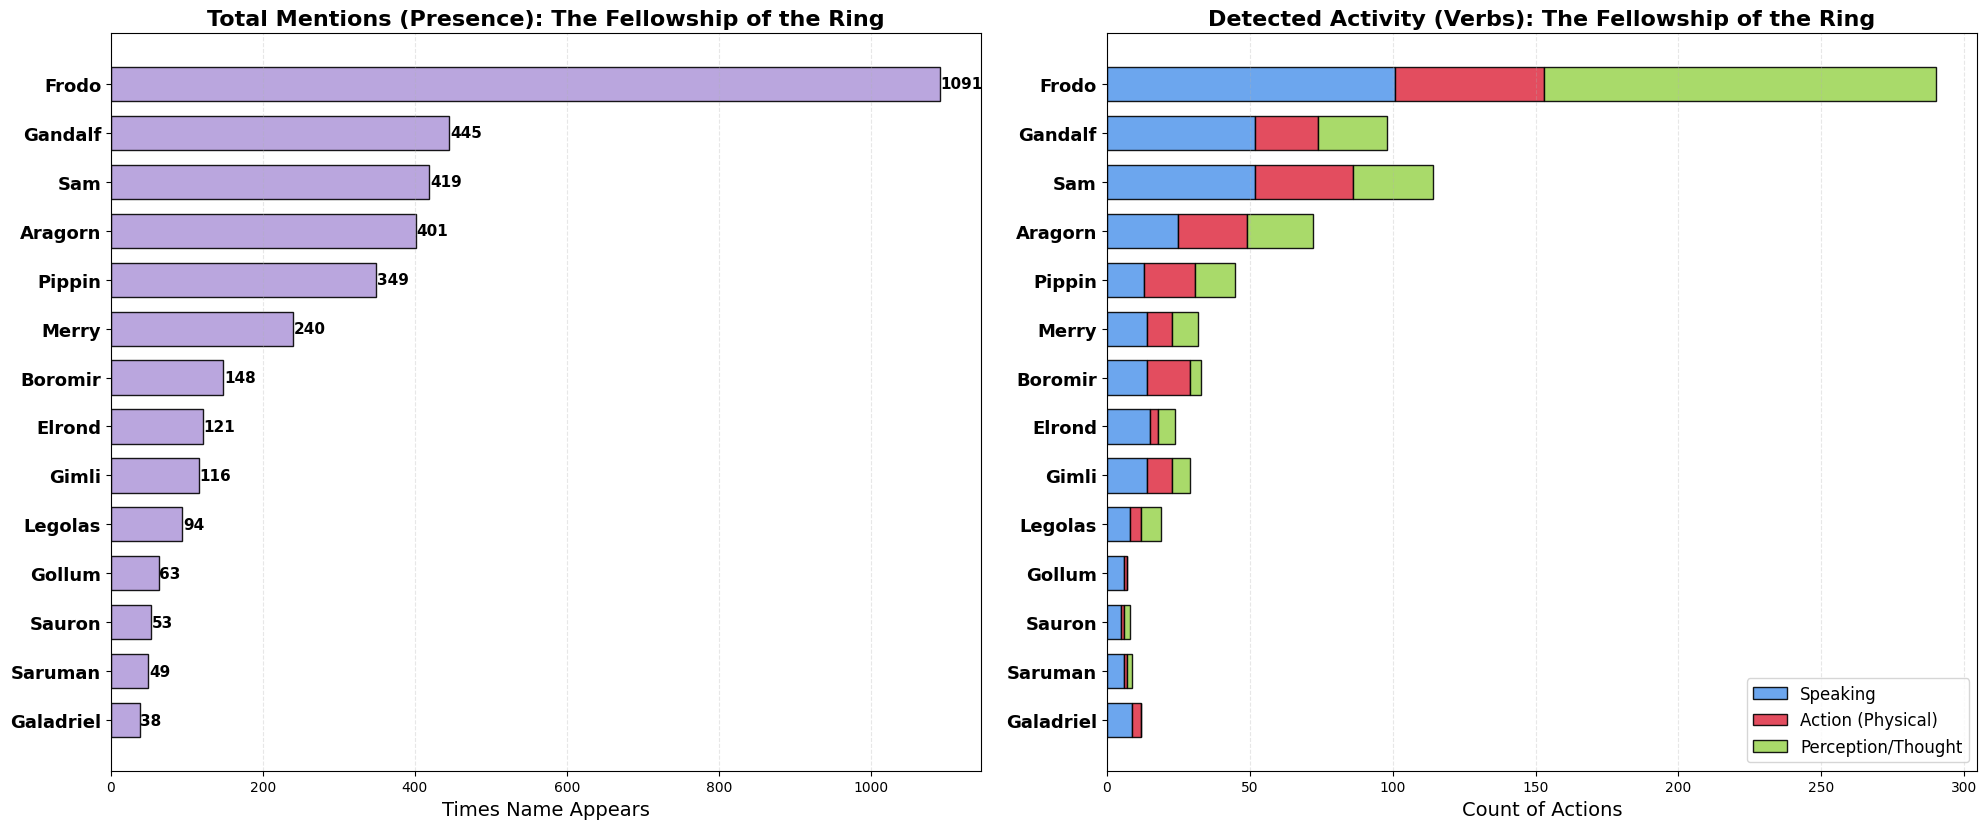

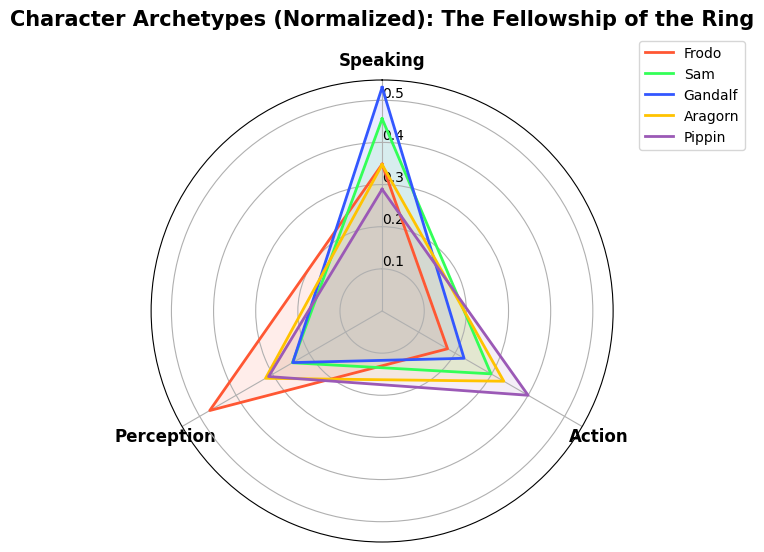


Analyzing The Two Towers...


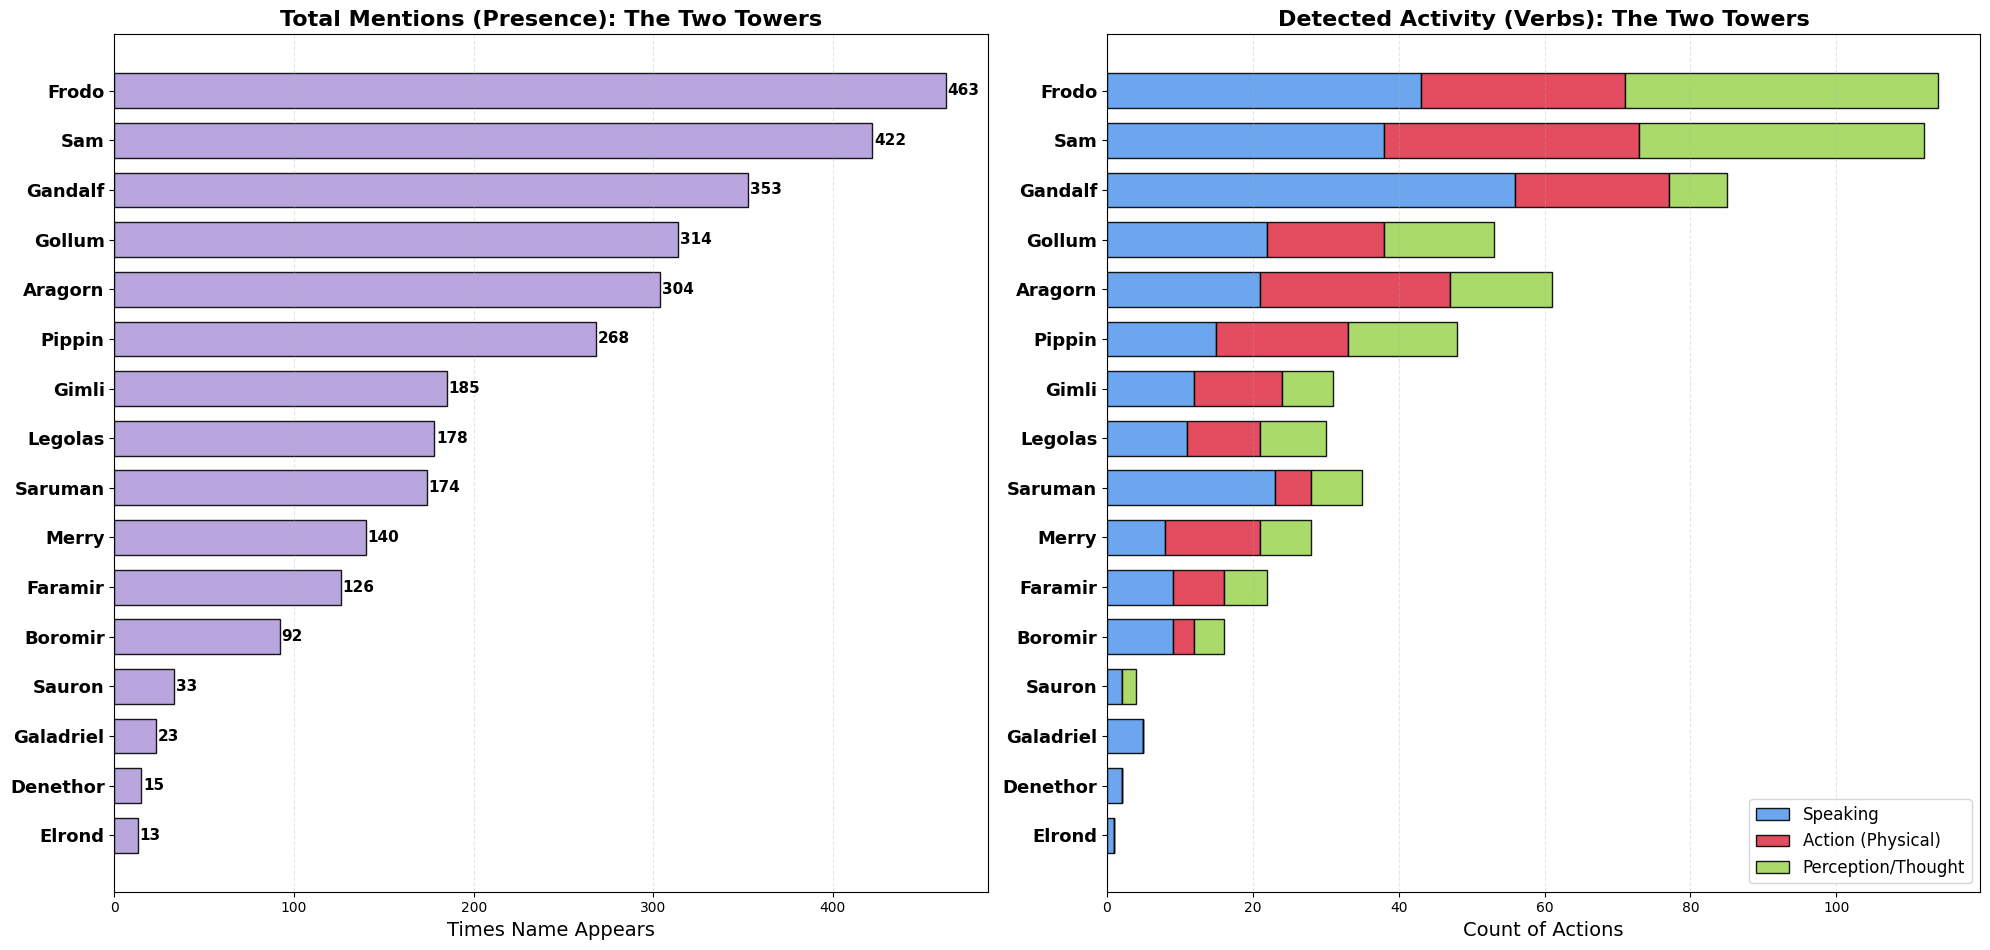

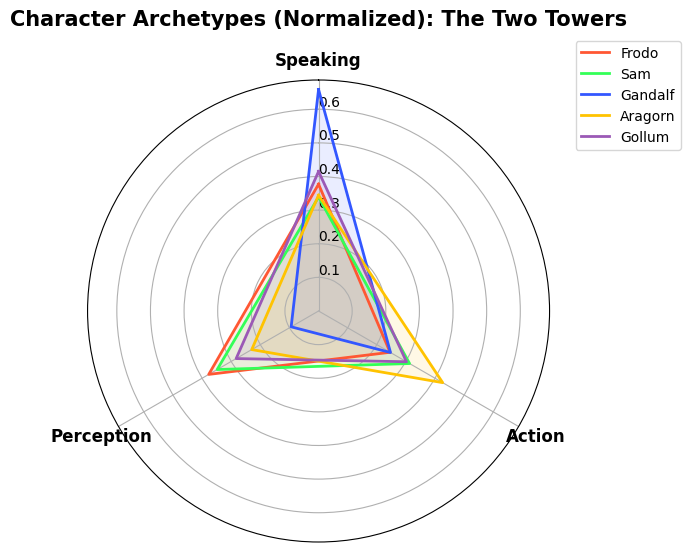


Analyzing The Return of the King...


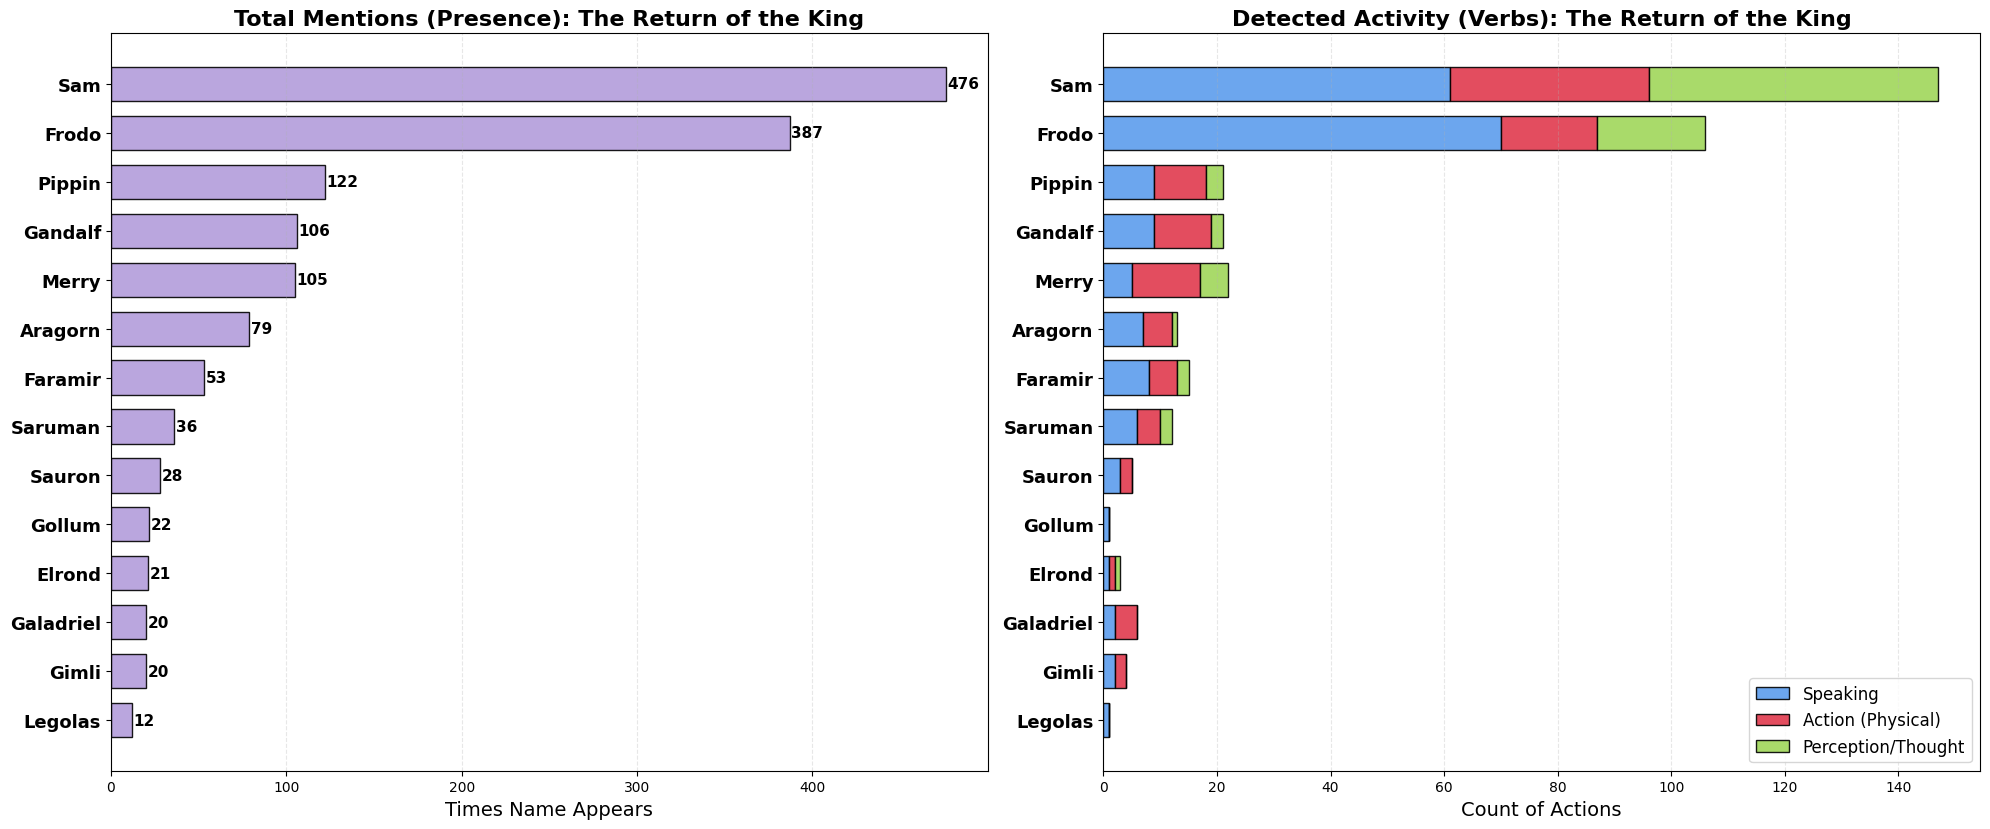

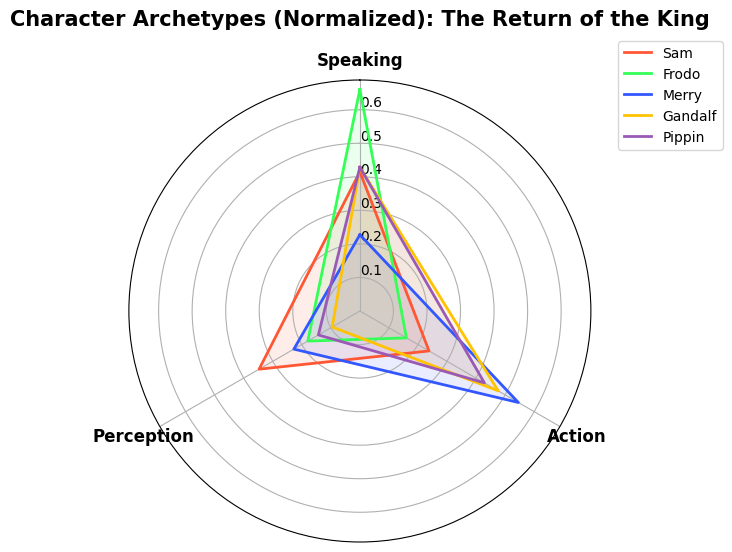

In [16]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# Character Mapping (YOUR ORIGINAL LIST)
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"]
}

# Create alias lookup
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# --- IMPROVED VERB DICTIONARIES ---
VERB_CATEGORIES = {
    "Speaking": set([
        "said", "asked", "replied", "answered", "cried", "shouted", "whispered", 
        "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
        "commanded", "demanded", "begged", "warned", "laughed", "sighed", 
        "continued", "added", "explained", "agreed", "announced"
    ]),
    "Action (Physical)": set([
        "ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell", 
        "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held", 
        "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat", 
        "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed"
    ]),
    "Perception/Thought": set([
        "saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched", 
        "noticed", "listened", "wondered", "remembered", "feared", "hoped",
        "stared", "glanced", "gazed", "perceived", "understood", "believed", 
        "realized", "guessed"
    ])
}

# Words to ignore when scanning window (adverbs, fillers)
SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again"])

# --- DATA LOADING ---
def clean_and_tokenize(filepath):
    """Loads and tokenizes text."""
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    # Strip headers
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: 
            start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: 
            end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

# --- ANALYSIS LOGIC (FILTER REMOVED) ---
def analyze_activity(tokens, alias_map, window_after=4):
    """
    Scans for Character + Verb patterns.
    Returns:
      1. activity_stats: Counts of verbs associated with characters.
      2. mention_stats: Total counts of character name appearances.
    """
    activity_stats = defaultdict(lambda: defaultdict(int))
    mention_stats = defaultdict(int)
    
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            
            # --- RAW COUNT: No filtering logic here anymore ---
            mention_stats[char_name] += 1 
            
            # Look at the next few words for verbs
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: 
                    continue
                
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        activity_stats[char_name][category] += 1
                        found_verb = True
                        break 
                if found_verb:
                    break
                    
    return activity_stats, mention_stats

# --- DUAL VISUALIZATION: SIDE-BY-SIDE GRAPHS ---
def plot_comparison(activity_stats, mention_stats, title):
    """
    Plots two charts side-by-side: 
    1. Total Mentions (Presence)
    2. Detected Activity (Verbs)
    """
    active_chars = [char for char in CHARACTERS.keys() if mention_stats[char] > 10]
    
    if not active_chars:
        print(f"Not enough data for {title}")
        return

    # Sort characters by TOTAL MENTIONS count
    sorted_chars = sorted(active_chars, key=lambda x: mention_stats[x], reverse=False)
    
    # --- PLOT SETUP ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, max(8, len(sorted_chars) * 0.6)))
    
    indices = np.arange(len(sorted_chars))
    bar_width = 0.7
    
    # --- LEFT CHART: TOTAL MENTIONS ---
    mention_values = [mention_stats[c] for c in sorted_chars]
    ax1.barh(indices, mention_values, color='#b39ddb', edgecolor='black', height=bar_width, alpha=0.9)
    ax1.set_title(f"Total Mentions (Presence): {title}", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Times Name Appears", fontsize=14)
    ax1.set_yticks(indices)
    ax1.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    
    # Add text labels
    for i, v in enumerate(mention_values):
        ax1.text(v + 1, i, str(v), va='center', fontsize=11, fontweight='bold')

    # --- RIGHT CHART: DETECTED ACTIVITY ---
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    colors = ['#5c9ded', '#e03a4e', '#a0d65a']
    lefts = np.zeros(len(sorted_chars))
    
    for i, cat in enumerate(categories):
        values = np.array([activity_stats[c][cat] for c in sorted_chars])
        ax2.barh(indices, values, left=lefts, label=cat, height=bar_width, color=colors[i], edgecolor='black', alpha=0.9)
        lefts += values
        
    ax2.set_title(f"Detected Activity (Verbs): {title}", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Count of Actions", fontsize=14)
    ax2.set_yticks(indices) 
    ax2.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=12)
    ax2.grid(axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- VISUALIZATION 2: Radar Charts ---
def plot_radar_profiles(stats, title):
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 15}
    if not active_chars: return

    # CHANGED: Slicing to top 5 instead of top 3
    top_5 = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)[:5]
    categories = ["Speaking", "Action", "Perception"]
    
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] 
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, size=12, fontweight='bold')
    ax.set_rlabel_position(0)
    
    # CHANGED: Added more colors to accommodate 5 characters
    colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#9B59B6']
    
    for i, char in enumerate(top_5):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]
        
        total = sum(values) if sum(values) > 0 else 1
        norm_values = [v/total for v in values]
        norm_values += norm_values[:1] 
        
        # Use modulo to cycle colors if we somehow exceeded 5 (just in case)
        color = colors[i % len(colors)]
        
        ax.plot(angles, norm_values, linewidth=2, linestyle='solid', label=char, color=color)
        ax.fill(angles, norm_values, color=color, alpha=0.1)

    plt.title(f"Character Archetypes (Normalized): {title}", size=15, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Enhanced Activity Analysis...")

for title, path in books:
    print(f"\nAnalyzing {title}...")
    tokens = clean_and_tokenize(path)
    
    if tokens:
        stats, mentions = analyze_activity(tokens, ALIAS_MAP)
        plot_comparison(stats, mentions, title)
        plot_radar_profiles(stats, title)
    else:
        print("Error: No tokens found.")

Starting Enhanced Analysis (Female Characters)...

Analyzing The Fellowship of the Ring...

--- Contextual Analysis: The Fellowship of the Ring ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Galadriel       | 38         | 15         | Active participant.
Goldberry       | 31         | 14         | Active participant.
Luthien         | 23         | 5          | Active participant.
Elbereth        | 22         | 7          | Active participant.
Arwen           | 18         | 5          | Active participant.
Lobelia         | 13         | 3          | Active participant.
--------------------------------------------------------------------------------



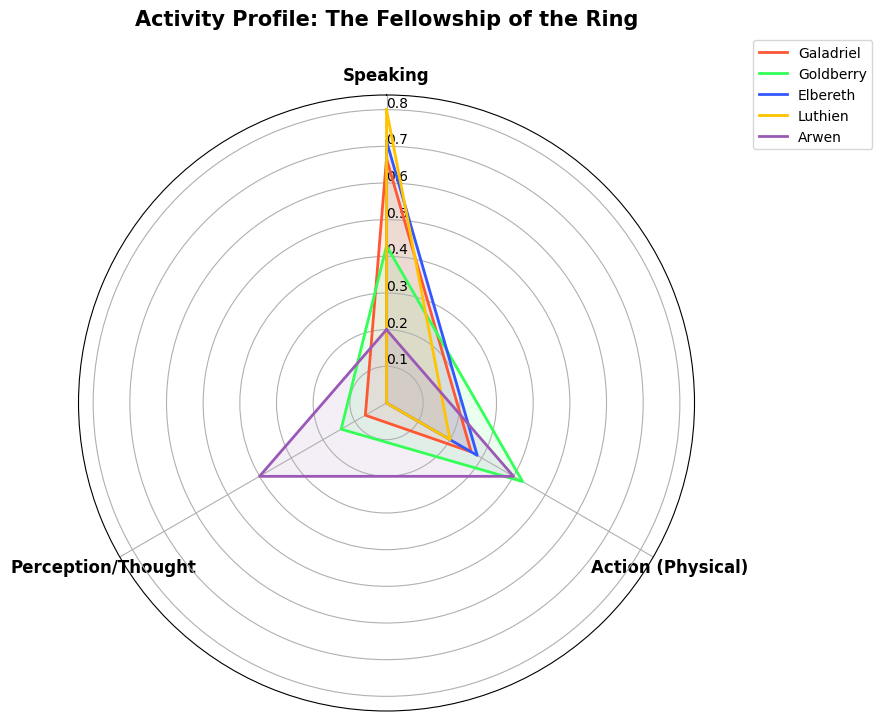


Analyzing The Two Towers...

--- Contextual Analysis: The Two Towers ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Shelob          | 33         | 5          | Active participant.
Galadriel       | 23         | 5          | Active participant.
Elbereth        | 4          | 0          | Deity/Vala. Invoked in prayer/song. Passive presence.
Arwen           | 2          | 0          | Appears in Aragorn's memories/dreams, not physical narrative.
--------------------------------------------------------------------------------



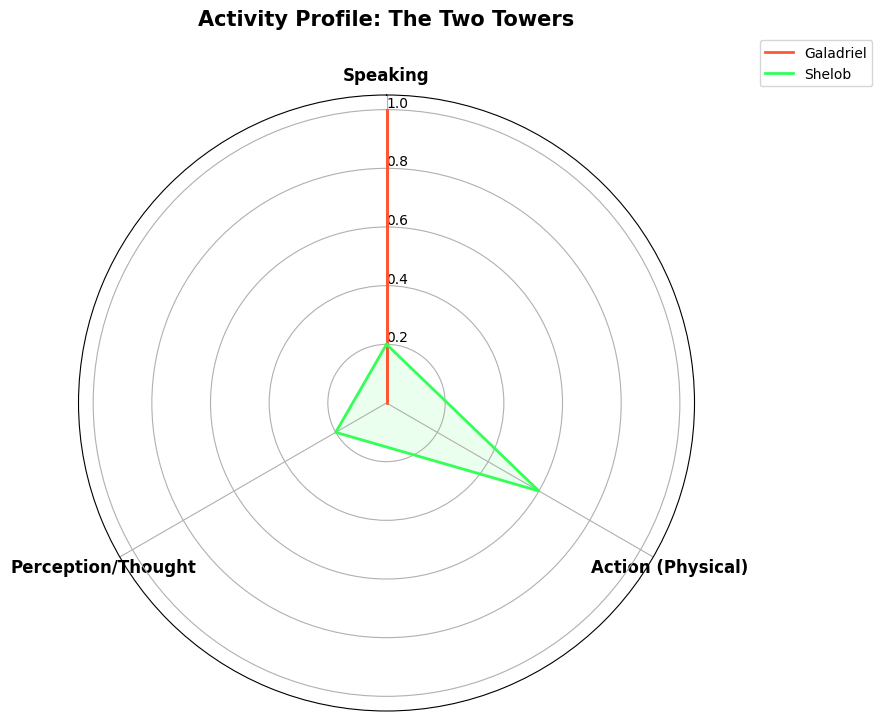


Analyzing The Return of the King...

--- Contextual Analysis: The Return of the King ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Rosie           | 102        | 22         | Active participant.
Galadriel       | 20         | 7          | Active participant.
Arwen           | 19         | 6          | Active participant.
Elbereth        | 9          | 2          | Active participant.
Eowyn           | 4          | 0          | Mentioned by others but performs no detected actions.
Ioreth          | 4          | 1          | Active participant.
Lobelia         | 2          | 1          | Active participant.
--------------------------------------------------------------------------------



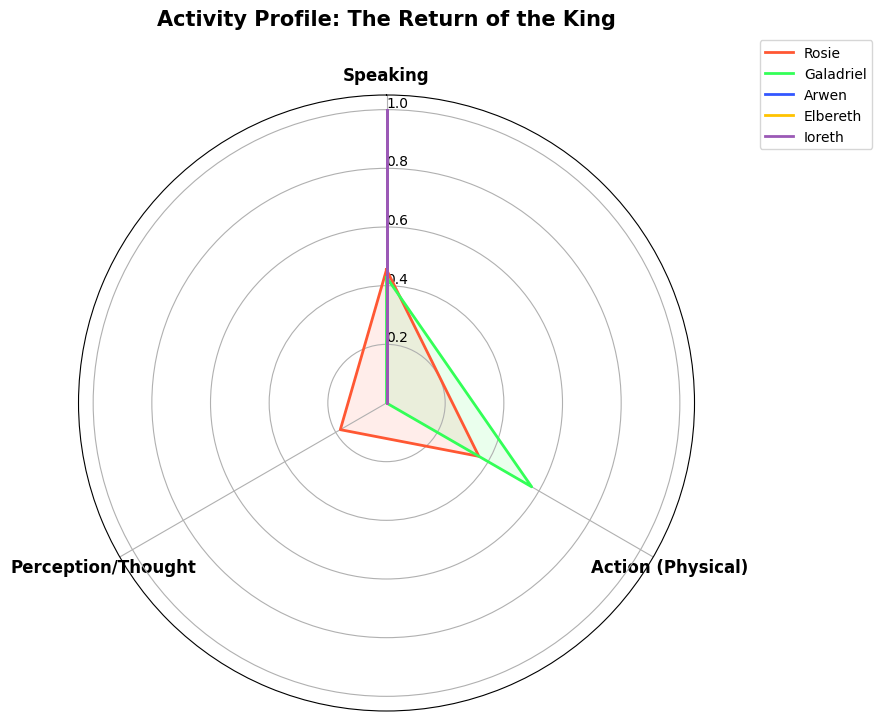

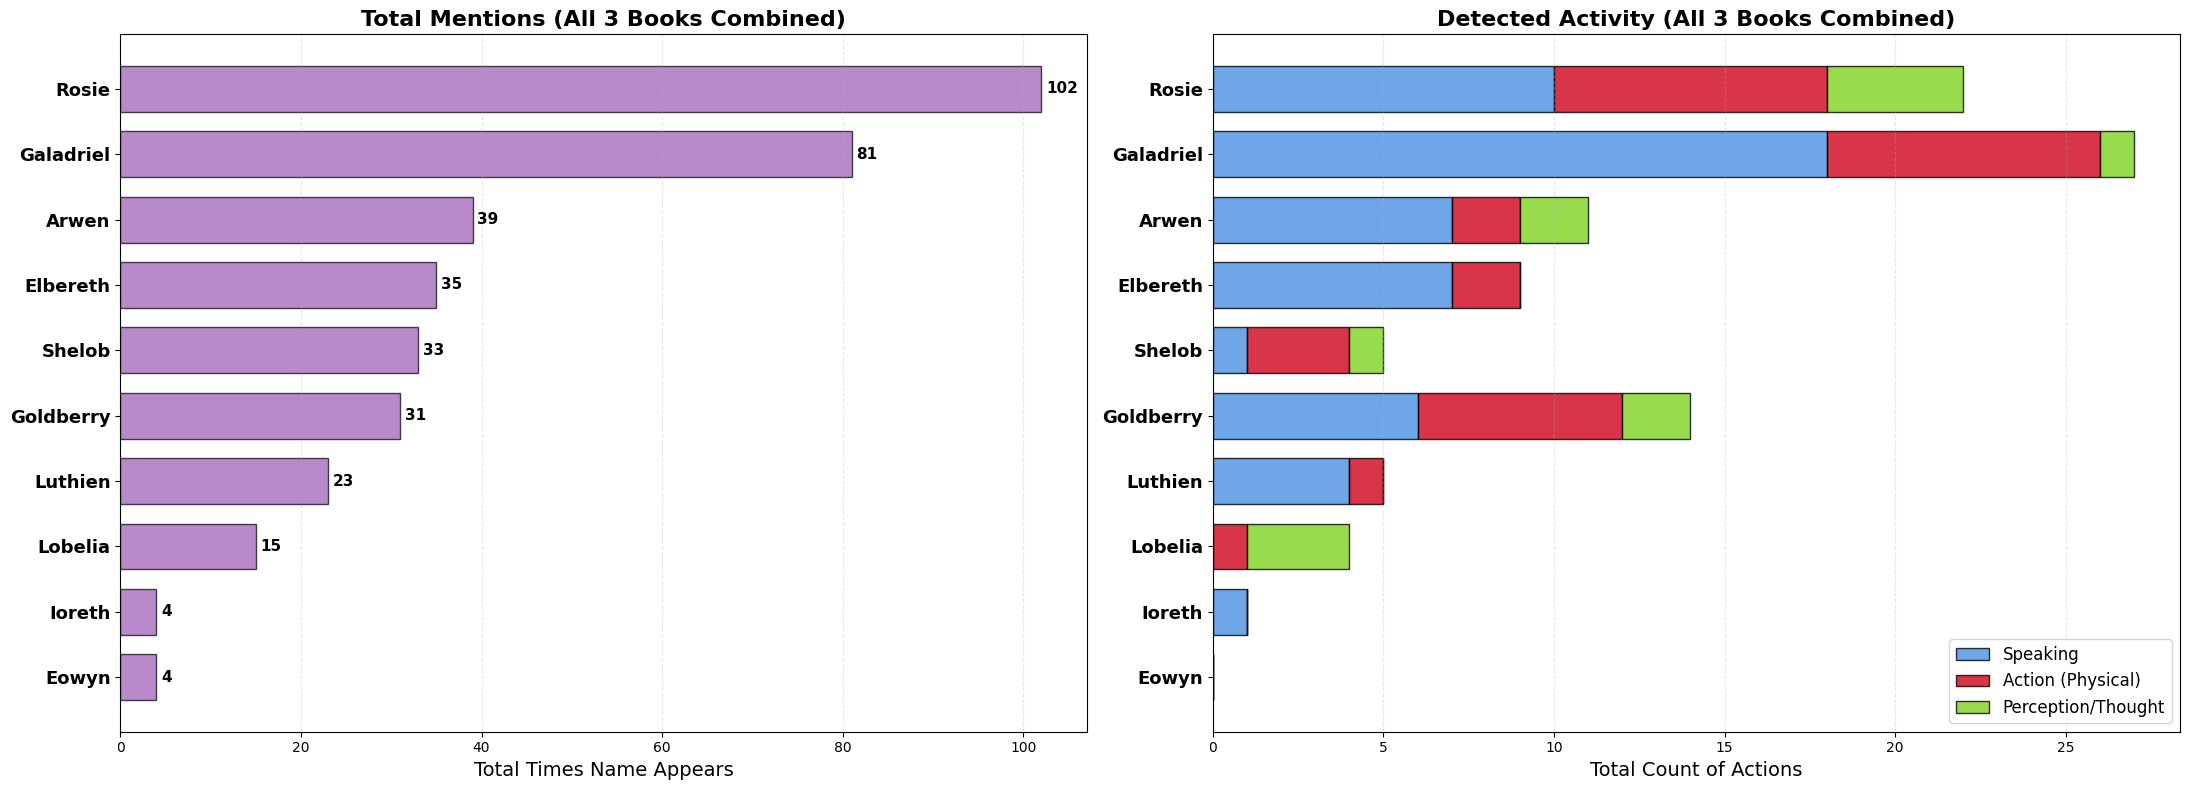

In [6]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# --- MASTER CHARACTER MAPPING ---
FEMALE_CHARACTERS_COMPREHENSIVE = {
    # Major Active
    "Galadriel": ["galadriel", "lady of light", "lady of the wood", "sorceress of the golden wood", "lady of lorien", "white lady"],
    "Eowyn": ["eowyn", "damsel", "shieldmaiden", "dernhelm", "sister-daughter", "lady of rohan", "white lady of rohan"], 
    "Arwen": ["arwen", "undomiel", "evenstar", "daughter of elrond", "queen"], 
    "Shelob": ["shelob", "spider", "her ladyship"], 
    "Goldberry": ["goldberry", "river-daughter", "river-woman's daughter"], 
    
    # Minor / Supporting / Historical / Deities
    "Rosie": ["rosie", "cotton", "rose", "rosie-lass"], 
    "Ioreth": ["ioreth", "wise-woman", "old wife"], 
    "Lobelia": ["lobelia", "sackville-baggins"], 
    "Primula": ["primula"], 
    "Belladonna": ["belladonna"], 
    "Gilraen": ["gilraen"], 
    "Luthien": ["luthien", "tinuviel", "nightingale"], 
    "Elbereth": ["elbereth", "gilthoniel", "varda", "star-kindler"], 
}

# --- BOOK FILTERS ---
# (Used primarily for book-specific context, but we will aggregate for the main charts)
BOOK_FILTERS = {
    "The Fellowship of the Ring": ["Galadriel", "Goldberry", "Arwen", "Lobelia", "Luthien", "Elbereth", "Gilraen"],
    "The Two Towers": ["Eowyn", "Shelob", "Galadriel", "Arwen", "Elbereth", "Luthien"],
    "The Return of the King": ["Eowyn", "Arwen", "Rosie", "Ioreth", "Lobelia", "Galadriel", "Elbereth", "Luthien"],
}

# --- EXPANDED VERB DICTIONARIES ---
VERB_CATEGORIES = {
    "Speaking": set(["said", "asked", "replied", "answered", "cried", "shouted", "whispered", 
                     "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
                     "commanded", "demanded", "begged", "warned", "laughed", "sighed", 
                     "continued", "added", "explained", "agreed", "announced", "greeting", "wept"]),
    "Action (Physical)": set(["ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell", 
                              "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held", 
                              "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat", 
                              "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed",
                              "went", "came", "gave", "took", "put", "set", "lay", "waited", "passed", "crawled", "stung", "bit"]),
    "Perception/Thought": set(["saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched", 
                               "noticed", "listened", "wondered", "remembered", "feared", "hoped",
                               "stared", "glanced", "gazed", "perceived", "understood", "believed", 
                               "realized", "guessed", "loved", "wished"])
}

SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again", "and", "but", "so", "very"])

# --- DATA LOADING ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

# --- ANALYSIS LOGIC ---
def analyze_activity(tokens, alias_map, window_after=6):
    activity_stats = defaultdict(lambda: defaultdict(int))
    mention_stats = defaultdict(int)
    
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            mention_stats[char_name] += 1 
            
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: continue
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        activity_stats[char_name][category] += 1
                        found_verb = True
                        break 
                if found_verb: break
                    
    return activity_stats, mention_stats

# --- EXPLANATION GENERATOR ---
def explain_passive_characters(activity_stats, mention_stats, title):
    print(f"\n--- Contextual Analysis: {title} ---")
    print(f"{'Character':<15} | {'Mentions':<10} | {'Actions':<10} | {'Context/Explanation'}")
    print("-" * 80)
    
    sorted_chars = sorted(mention_stats.keys(), key=lambda x: mention_stats[x], reverse=True)
    
    for char in sorted_chars:
        mentions = mention_stats[char]
        if mentions == 0: continue
        
        actions = sum(activity_stats[char].values())
        explanation = "Active participant."
        
        if actions == 0:
            if char in ["Elbereth", "Varda"]:
                explanation = "Deity/Vala. Invoked in prayer/song. Passive presence."
            elif char in ["Luthien", "Tinuviel"]:
                explanation = "Historical figure. Appears in songs/tales."
            elif char == "Gilraen":
                explanation = "Historical figure (Aragorn's mother). Mentioned in memory."
            elif char == "Galadriel" and "Two Towers" in title:
                explanation = "Mentioned by Fellowship/Saruman, not physically present."
            elif char == "Arwen" and "Two Towers" in title:
                explanation = "Appears in Aragorn's memories/dreams, not physical narrative."
            else:
                explanation = "Mentioned by others but performs no detected actions."
        
        print(f"{char:<15} | {mentions:<10} | {actions:<10} | {explanation}")
    print("-" * 80 + "\n")

# --- COMBINED PLOT GENERATION ---
def plot_combined_analysis(all_mentions, all_activity):
    """
    Plots Total Mentions and Activity aggregated across all three books.
    """
    # 1. Aggregate data across books
    total_mentions = defaultdict(int)
    total_activity = defaultdict(lambda: defaultdict(int))
    
    for book_mentions in all_mentions:
        for char, count in book_mentions.items():
            total_mentions[char] += count
            
    for book_activity in all_activity:
        for char, cats in book_activity.items():
            for cat, count in cats.items():
                total_activity[char][cat] += count

    # Filter characters with > 0 mentions
    active_chars = [c for c in total_mentions if total_mentions[c] > 0]
    if not active_chars:
        print("No character data found to plot.")
        return

    # Sort characters by TOTAL MENTIONS
    sorted_chars = sorted(active_chars, key=lambda x: total_mentions[x], reverse=False)

    # --- PLOT SETUP ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, max(8, len(sorted_chars) * 0.8)))
    indices = np.arange(len(sorted_chars))
    bar_width = 0.7

    # --- CHART 1: TOTAL MENTIONS (Aggregated) ---
    mention_values = [total_mentions[c] for c in sorted_chars]
    ax1.barh(indices, mention_values, color='#9b59b6', edgecolor='black', height=bar_width, alpha=0.7)
    ax1.set_title("Total Mentions (All 3 Books Combined)", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Total Times Name Appears", fontsize=14)
    ax1.set_yticks(indices)
    ax1.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    
    for i, v in enumerate(mention_values):
        ax1.text(v + 0.5, i, str(v), va='center', fontsize=11, fontweight='bold')

    # --- CHART 2: DETECTED ACTIVITY (Aggregated) ---
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    colors = ['#4a90e2', '#d0021b', '#7ed321']
    lefts = np.zeros(len(sorted_chars))
    
    for i, cat in enumerate(categories):
        values = np.array([total_activity[c][cat] for c in sorted_chars])
        ax2.barh(indices, values, left=lefts, label=cat, height=bar_width, color=colors[i], edgecolor='black', alpha=0.8)
        lefts += values
        
    ax2.set_title("Detected Activity (All 3 Books Combined)", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Total Count of Actions", fontsize=14)
    ax2.set_yticks(indices)
    ax2.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=12)
    ax2.grid(axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- RADAR CHART FUNCTION (Per Book) ---
def plot_book_radar_profiles(stats, title):
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 0} 
    if not active_chars: return

    # Top 5 most active in THIS book
    top_5 = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)[:5]
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] 
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, size=12, fontweight='bold')
    ax.set_rlabel_position(0)
    
    colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#9B59B6']
    
    for i, char in enumerate(top_5):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]
        
        total = sum(values) if sum(values) > 0 else 1
        norm_values = [v/total for v in values]
        norm_values += norm_values[:1] 
        
        color = colors[i % len(colors)]
        
        ax.plot(angles, norm_values, linewidth=2, linestyle='solid', label=char, color=color)
        ax.fill(angles, norm_values, color=color, alpha=0.1)

    plt.title(f"Activity Profile: {title}", size=15, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Enhanced Analysis (Female Characters)...")

# Data collectors for the final combined chart
all_books_mentions = []
all_books_activity = []

for title, path in books:
    print(f"\nAnalyzing {title}...")
    relevant_names = BOOK_FILTERS.get(title, [])
    
    # Create Book-Specific Alias Map
    book_alias_map = {}
    for name in relevant_names:
        for alias in FEMALE_CHARACTERS_COMPREHENSIVE.get(name, []):
            book_alias_map[alias] = name
            
    tokens = clean_and_tokenize(path)
    
    if tokens:
        act_stats, men_stats = analyze_activity(tokens, book_alias_map, window_after=6)
        
        # Store for combined analysis later
        all_books_mentions.append(men_stats)
        all_books_activity.append(act_stats)
        
        # 1. Print Textual Explanation for Passive Characters (Per Book)
        explain_passive_characters(act_stats, men_stats, title)
        
        # 2. Generate Radar Chart for THIS book (as requested to keep per book)
        plot_book_radar_profiles(act_stats, title)

    else:
        print(f"Error: No tokens found for {title}.")

# 3. Generate ONE Combined Mentions/Activity Chart for ALL books
if all_books_mentions and all_books_activity:
    plot_combined_analysis(all_books_mentions, all_books_activity)

Starting Enhanced Analysis (Female Characters)...

Analyzing The Fellowship of the Ring...

--- Contextual Analysis: The Fellowship of the Ring ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Galadriel       | 38         | 15         | Active participant.
Goldberry       | 31         | 14         | Active participant.
Luthien         | 23         | 5          | Active participant.
Elbereth        | 22         | 7          | Active participant.
Arwen           | 18         | 5          | Active participant.
Lobelia         | 13         | 3          | Active participant.
--------------------------------------------------------------------------------



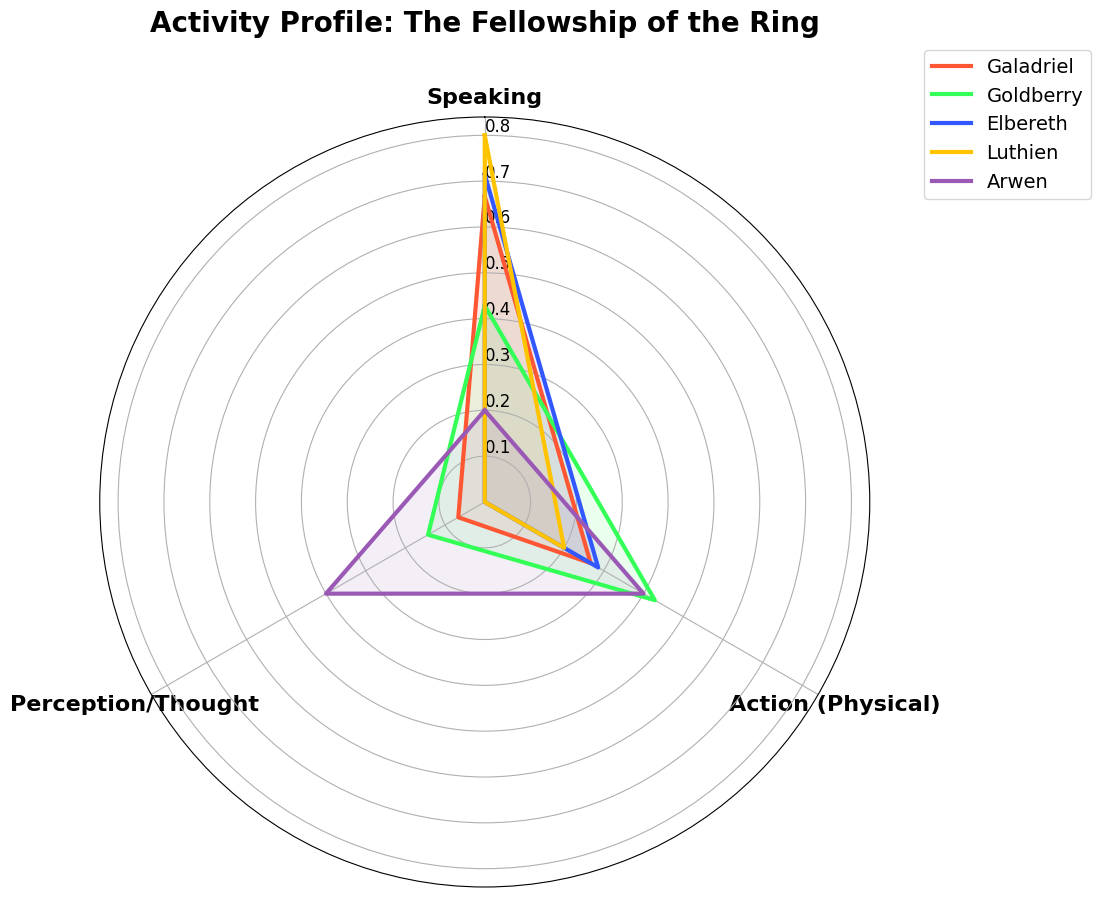


Analyzing The Two Towers...

--- Contextual Analysis: The Two Towers ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Shelob          | 33         | 5          | Active participant.
Galadriel       | 23         | 5          | Active participant.
Eowyn           | 10         | 7          | Active participant.
Elbereth        | 4          | 0          | Deity/Vala. Invoked in prayer/song. Passive presence.
Arwen           | 2          | 0          | Appears in Aragorn's memories/dreams, not physical narrative.
--------------------------------------------------------------------------------



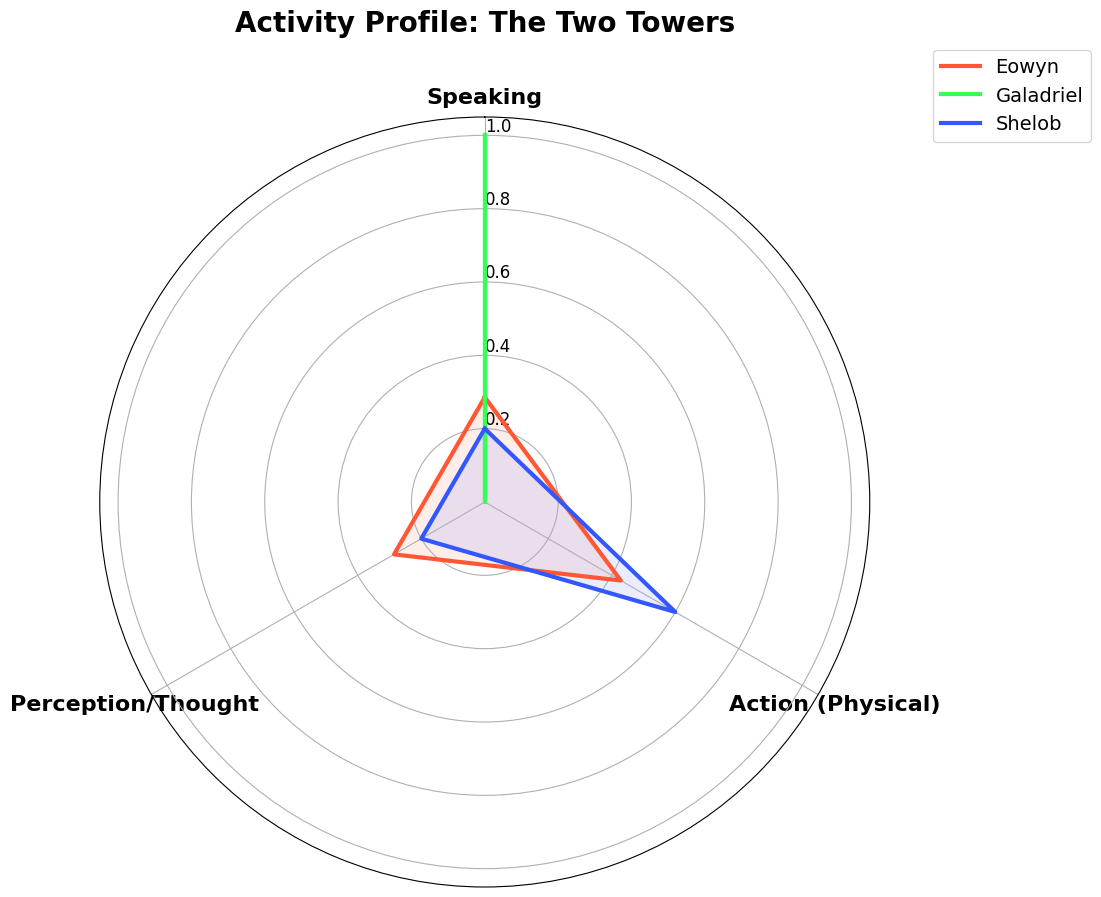


Analyzing The Return of the King...

--- Contextual Analysis: The Return of the King ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Rosie           | 63         | 14         | Active participant.
Eowyn           | 42         | 14         | Active participant.
Galadriel       | 20         | 7          | Active participant.
Arwen           | 19         | 6          | Active participant.
Elbereth        | 9          | 2          | Active participant.
Ioreth          | 4          | 1          | Active participant.
Lobelia         | 2          | 1          | Active participant.
--------------------------------------------------------------------------------



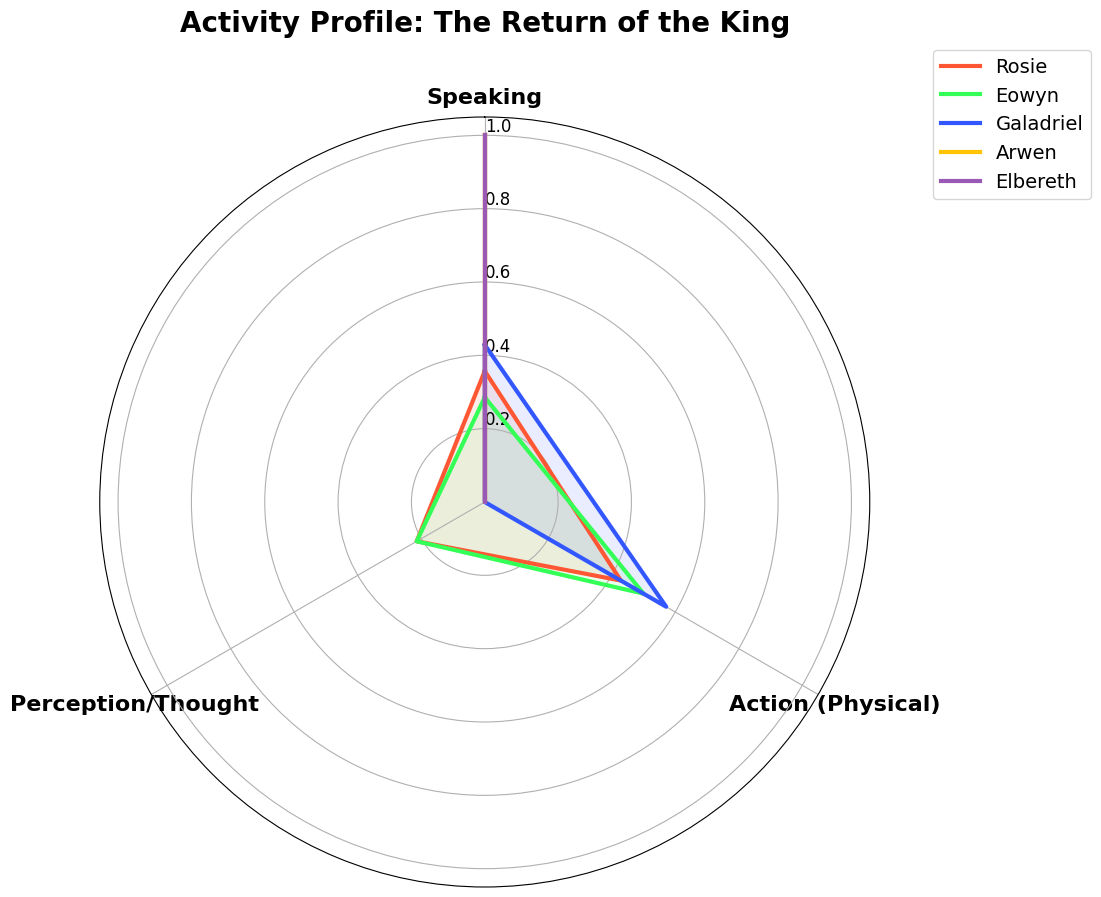

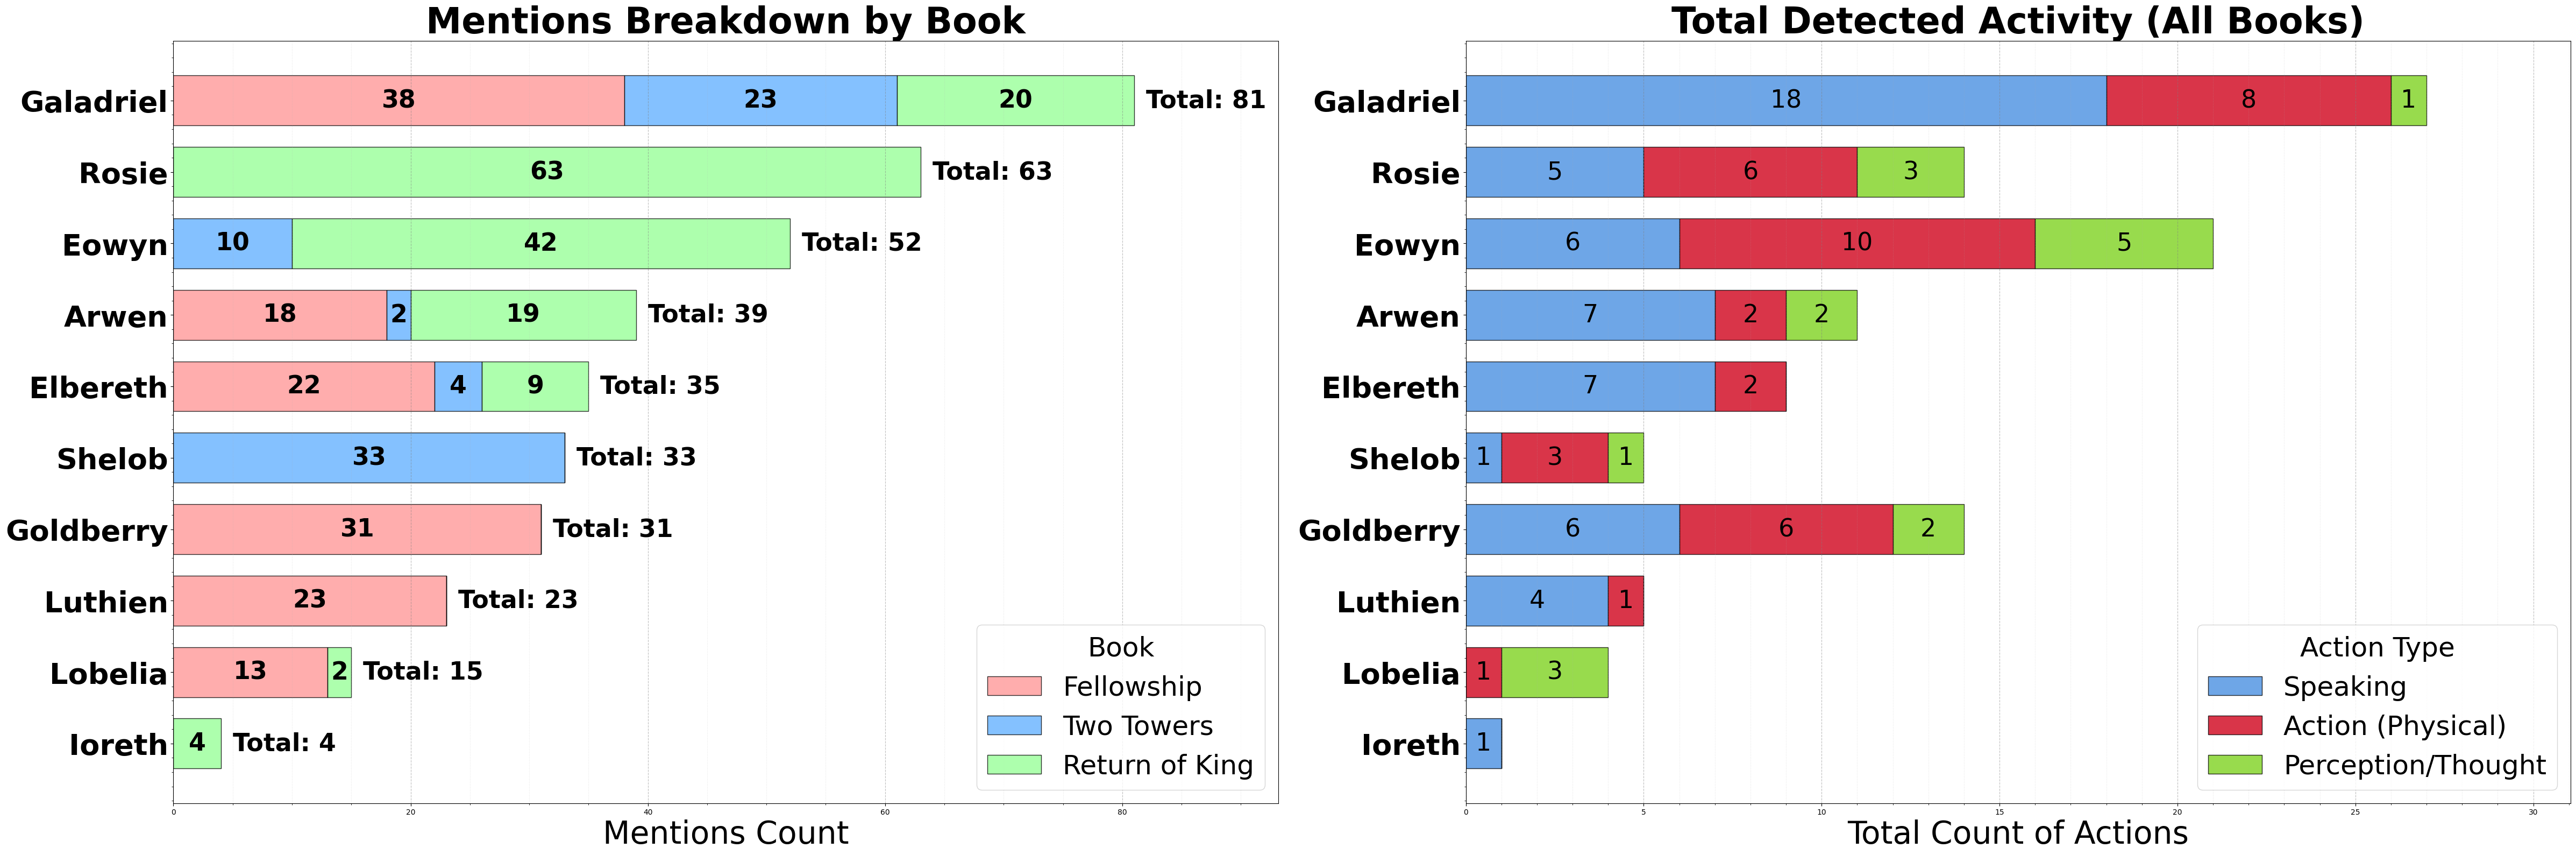

<Figure size 640x480 with 0 Axes>

Starting Enhanced Analysis (Female Characters)...

Analyzing The Fellowship of the Ring...

--- Contextual Analysis: The Fellowship of the Ring ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Galadriel       | 38         | 15         | Active participant.
Goldberry       | 31         | 14         | Active participant.
Luthien         | 23         | 5          | Active participant.
Elbereth        | 22         | 7          | Active participant.
Arwen           | 18         | 5          | Active participant.
Lobelia         | 13         | 3          | Active participant.
--------------------------------------------------------------------------------



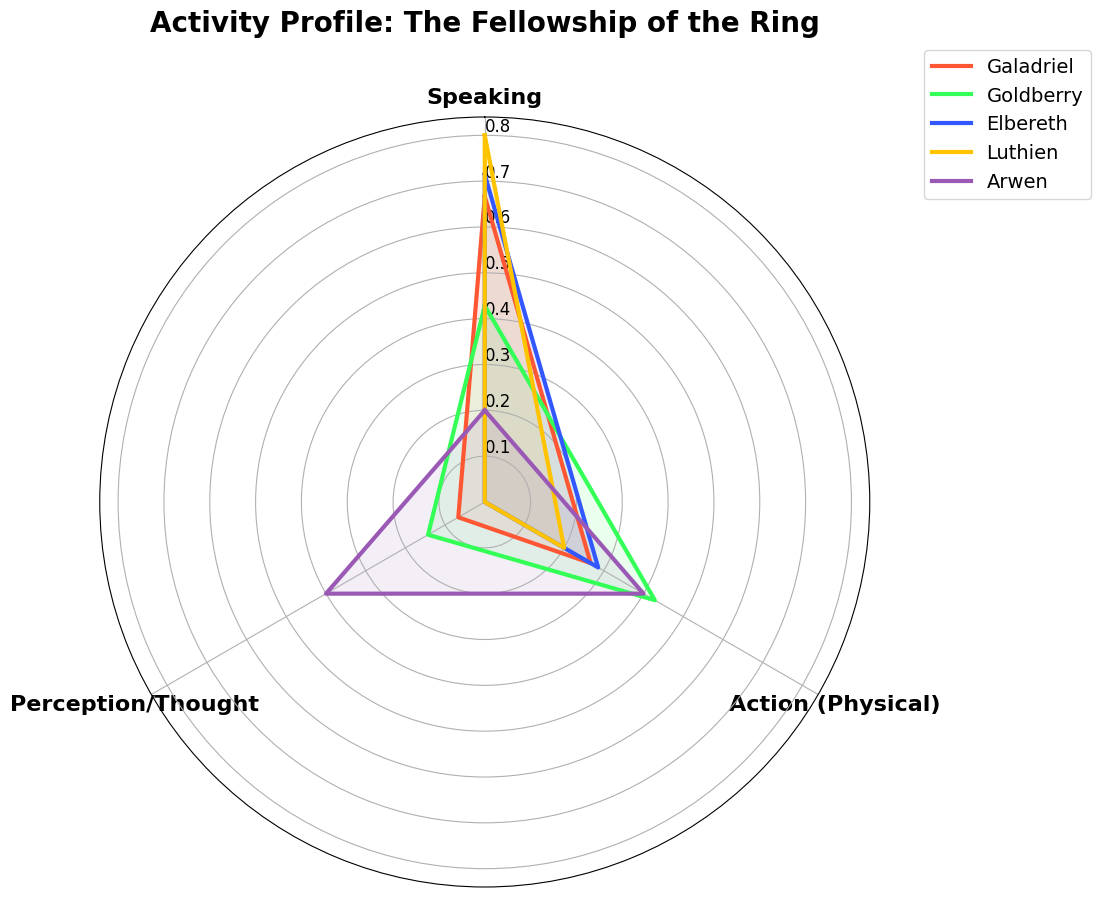


Analyzing The Two Towers...

--- Contextual Analysis: The Two Towers ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Shelob          | 33         | 5          | Active participant.
Galadriel       | 23         | 5          | Active participant.
Eowyn           | 10         | 7          | Active participant.
Elbereth        | 4          | 0          | Deity/Vala. Invoked in prayer/song. Passive presence.
Arwen           | 2          | 0          | Appears in Aragorn's memories/dreams, not physical narrative.
--------------------------------------------------------------------------------



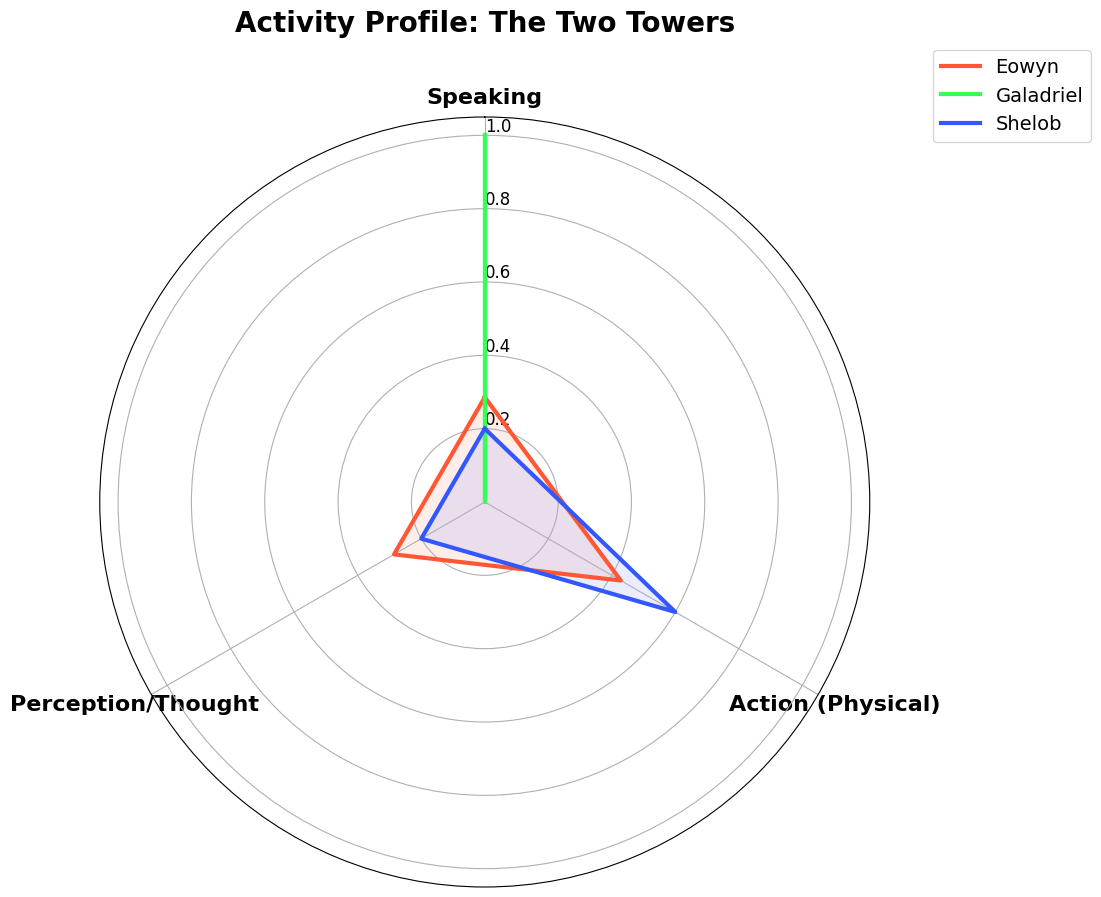


Analyzing The Return of the King...

--- Contextual Analysis: The Return of the King ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Rosie           | 63         | 14         | Active participant.
Eowyn           | 42         | 14         | Active participant.
Galadriel       | 20         | 7          | Active participant.
Arwen           | 19         | 6          | Active participant.
Elbereth        | 9          | 2          | Active participant.
Ioreth          | 4          | 1          | Active participant.
Lobelia         | 2          | 1          | Active participant.
--------------------------------------------------------------------------------



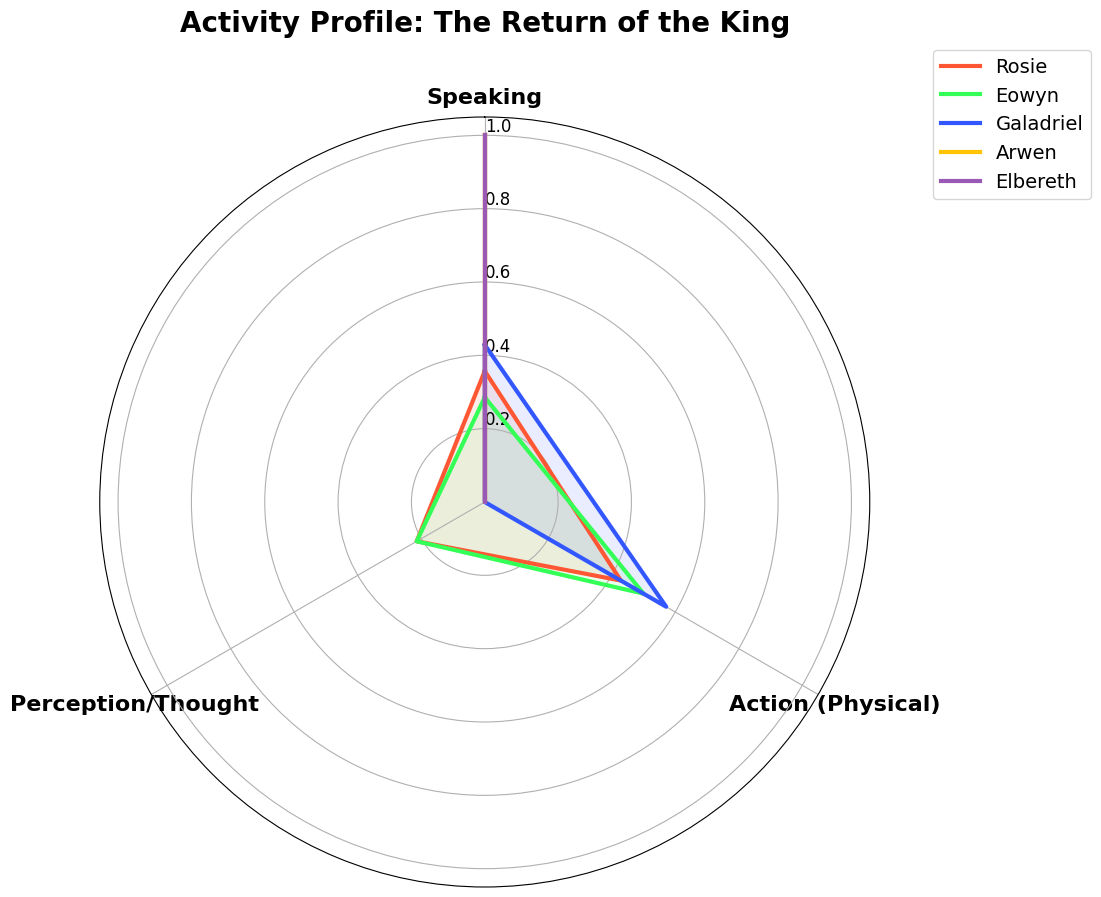

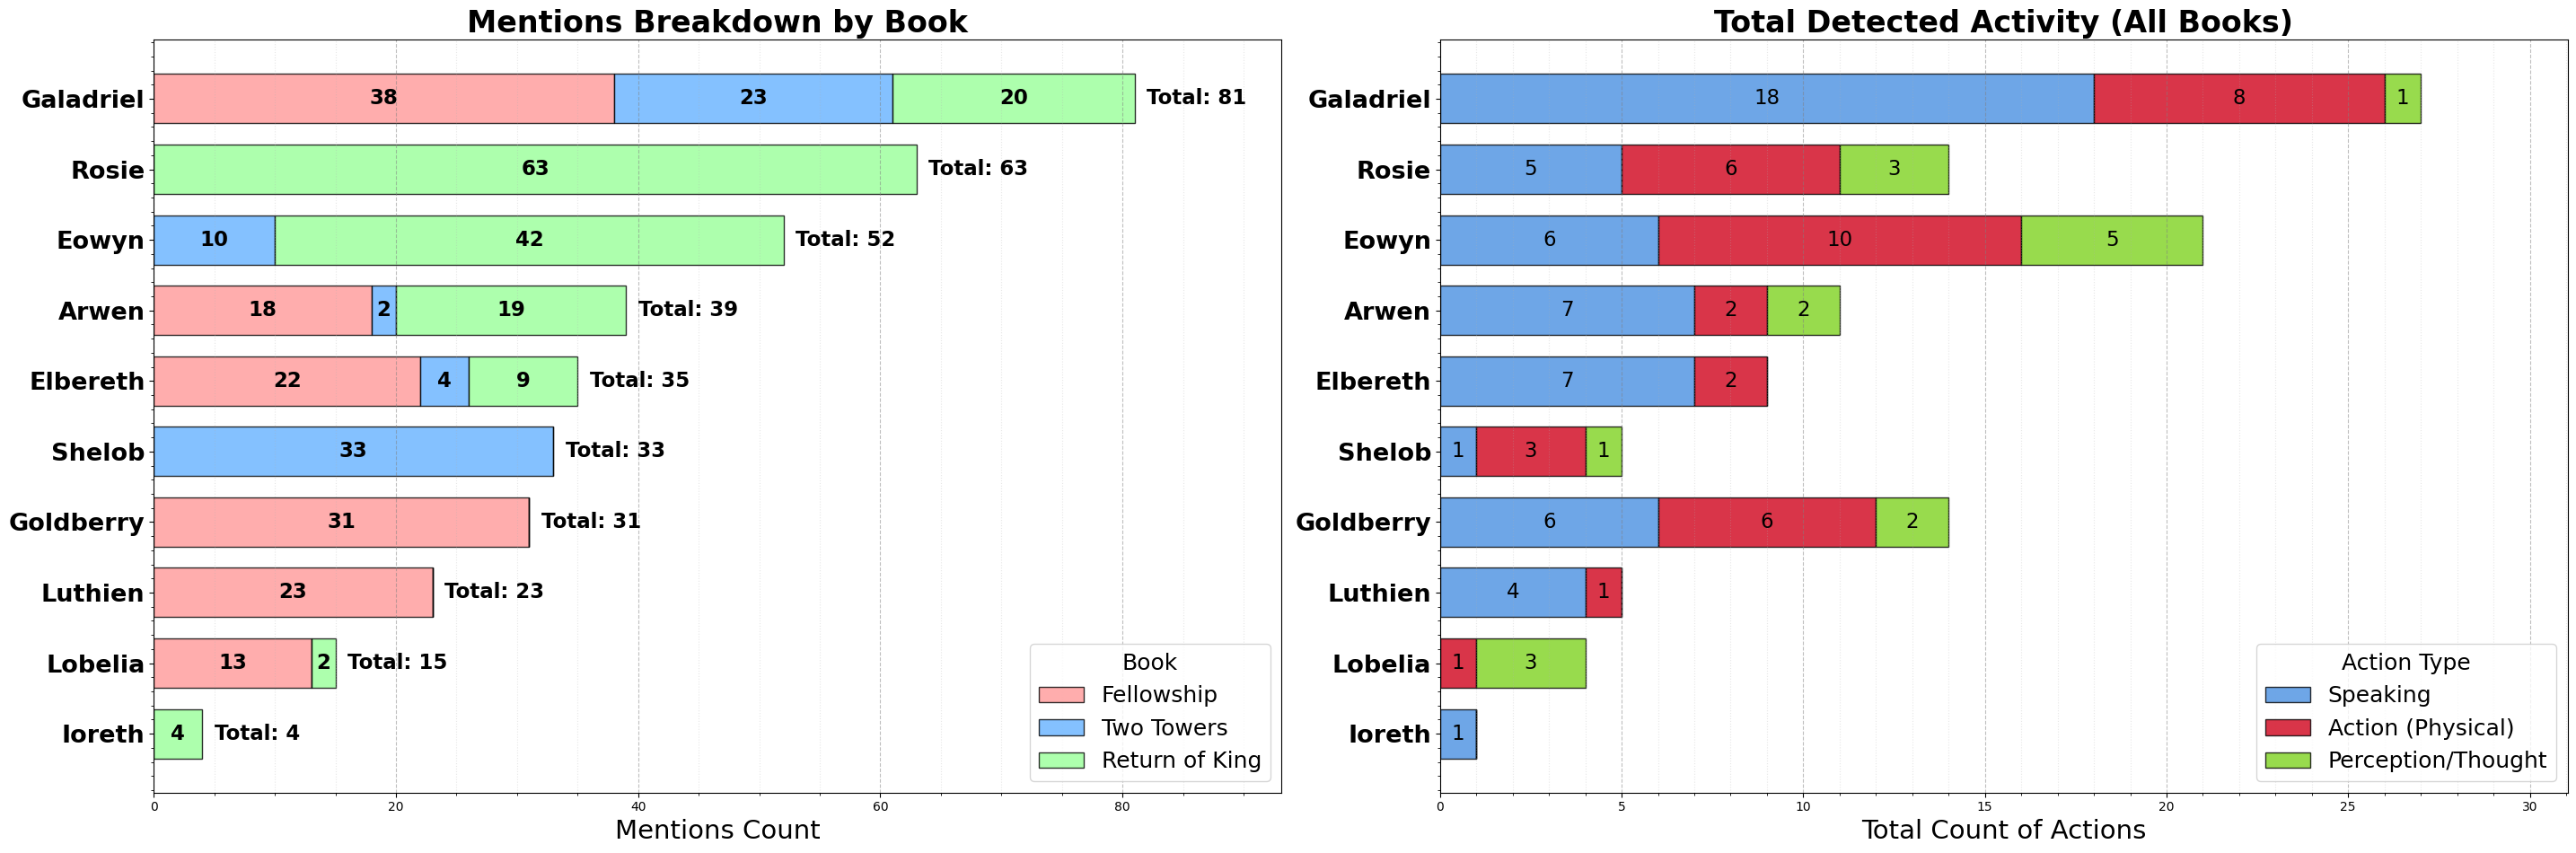

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# --- MASTER CHARACTER MAPPING ---
FEMALE_CHARACTERS_COMPREHENSIVE = {
    # Major Active
    "Galadriel": ["galadriel", "lady of light", "lady of the wood", "sorceress of the golden wood", "lady of lorien", "white lady"],
    "Eowyn": ["eowyn", "damsel", "shieldmaiden", "dernhelm", "sister-daughter", "lady of rohan", "white lady of rohan"], 
    "Arwen": ["arwen", "undomiel", "evenstar", "daughter of elrond", "queen"], 
    "Shelob": ["shelob", "spider", "her ladyship"], 
    "Goldberry": ["goldberry", "river-daughter", "river-woman's daughter"], 
    
    # Minor / Supporting / Historical / Deities
    "Rosie": ["rosie", "rose", "rosie-lass"],   #"cotton"
    "Ioreth": ["ioreth", "wise-woman", "old wife", "Ioreth"], 
    "Lobelia": ["lobelia", "sackville-baggins"], 
    "Primula": ["primula"], 
    "Belladonna": ["belladonna"], 
    "Gilraen": ["gilraen"], 
    "Luthien": ["luthien", "tinuviel", "nightingale"], 
    "Elbereth": ["elbereth", "gilthoniel", "varda", "star-kindler"], 
}

# --- BOOK FILTERS ---
BOOK_FILTERS = {
    "The Fellowship of the Ring": ["Galadriel", "Goldberry", "Arwen", "Lobelia", "Luthien", "Elbereth", "Gilraen"],
    "The Two Towers": ["Eowyn", "Shelob", "Galadriel", "Arwen", "Elbereth", "Luthien"],
    "The Return of the King": ["Eowyn", "Arwen", "Rosie", "Ioreth", "Lobelia", "Galadriel", "Elbereth", "Luthien"],
}

# --- EXPANDED VERB DICTIONARIES ---
VERB_CATEGORIES = {
    "Speaking": set(["said", "asked", "replied", "answered", "cried", "shouted", "whispered", 
                     "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
                     "commanded", "demanded", "begged", "warned", "laughed", "sighed", 
                     "continued", "added", "explained", "agreed", "announced", "greeting", "wept"]),
    "Action (Physical)": set(["ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell", 
                              "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held", 
                              "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat", 
                              "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed",
                              "went", "came", "gave", "took", "put", "set", "lay", "waited", "passed", "crawled", "stung", "bit"]),
    "Perception/Thought": set(["saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched", 
                               "noticed", "listened", "wondered", "remembered", "feared", "hoped",
                               "stared", "glanced", "gazed", "perceived", "understood", "believed", 
                               "realized", "guessed", "loved", "wished"])
}

SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again", "and", "but", "so", "very"])

# --- DATA LOADING ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

# --- ANALYSIS LOGIC ---
def analyze_activity(tokens, alias_map, window_after=6):
    activity_stats = defaultdict(lambda: defaultdict(int))
    mention_stats = defaultdict(int)
    
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            mention_stats[char_name] += 1 
            
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: continue
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        activity_stats[char_name][category] += 1
                        found_verb = True
                        break 
                if found_verb: break
                    
    return activity_stats, mention_stats

# --- EXPLANATION GENERATOR ---
def explain_passive_characters(activity_stats, mention_stats, title):
    print(f"\n--- Contextual Analysis: {title} ---")
    print(f"{'Character':<15} | {'Mentions':<10} | {'Actions':<10} | {'Context/Explanation'}")
    print("-" * 80)
    
    sorted_chars = sorted(mention_stats.keys(), key=lambda x: mention_stats[x], reverse=True)
    
    for char in sorted_chars:
        mentions = mention_stats[char]
        if mentions == 0: continue
        
        actions = sum(activity_stats[char].values())
        explanation = "Active participant."
        
        if actions == 0:
            if char in ["Elbereth", "Varda"]:
                explanation = "Deity/Vala. Invoked in prayer/song. Passive presence."
            elif char in ["Luthien", "Tinuviel"]:
                explanation = "Historical figure. Appears in songs/tales."
            elif char == "Gilraen":
                explanation = "Historical figure (Aragorn's mother). Mentioned in memory."
            elif char == "Galadriel" and "Two Towers" in title:
                explanation = "Mentioned by Fellowship/Saruman, not physically present."
            elif char == "Arwen" and "Two Towers" in title:
                explanation = "Appears in Aragorn's memories/dreams, not physical narrative."
            else:
                explanation = "Mentioned by others but performs no detected actions."
        
        print(f"{char:<15} | {mentions:<10} | {actions:<10} | {explanation}")
    print("-" * 80 + "\n")

# --- COMBINED PLOT GENERATION ---
# --- COMBINED PLOT GENERATION ---
def plot_combined_analysis(all_mentions, all_activity, text_scaling=1.5, fig_size_scale=1.2):
    """
    Plots Total Mentions as a STACKED BAR CHART and Activity aggregated across all books.
    
    Args:
        all_mentions: List of mention dicts per book
        all_activity: List of activity dicts per book
        text_scaling: Multiplier for font sizes (default 1.5 for larger text)
        fig_size_scale: Multiplier for figure size (default 1.2 for larger figure)
    """
    # 1. Aggregate data
    char_book_mentions = defaultdict(lambda: [0, 0, 0])
    total_mentions_sum = defaultdict(int)
    
    for book_idx, book_mentions in enumerate(all_mentions):
        for char, count in book_mentions.items():
            char_book_mentions[char][book_idx] = count
            total_mentions_sum[char] += count

    total_activity = defaultdict(lambda: defaultdict(int))
    for book_activity in all_activity:
        for char, cats in book_activity.items():
            for cat, count in cats.items():
                total_activity[char][cat] += count

    active_chars = [c for c in total_mentions_sum if total_mentions_sum[c] > 0]
    if not active_chars:
        print("No character data found to plot.")
        return

    sorted_chars = sorted(active_chars, key=lambda x: total_mentions_sum[x], reverse=False)

    # Calculate Font Sizes based on scaling
    title_fs = 16 * text_scaling
    label_fs = 14 * text_scaling
    tick_fs = 13 * text_scaling
    annot_fs = 11 * text_scaling
    legend_fs = 12 * text_scaling
    
    # Calculate Figure Size
    base_width, base_height = 24, max(8, len(sorted_chars) * 0.8)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(base_width * fig_size_scale, base_height * fig_size_scale))
    
    indices = np.arange(len(sorted_chars))
    bar_width = 0.7

    # --- CHART 1: TOTAL MENTIONS (STACKED) ---
    # --- CHART 1: TOTAL MENTIONS (STACKED) ---
    book_titles = ["Fellowship", "Two Towers", "Return of King"]
    book_colors = ['#FF9999', '#66B2FF', '#99FF99'] 
    
    left_bottoms = np.zeros(len(sorted_chars))

    for book_idx, book_name in enumerate(book_titles):
        book_counts = [char_book_mentions[c][book_idx] for c in sorted_chars]
        
        ax1.barh(indices, book_counts, left=left_bottoms, color=book_colors[book_idx], 
                 edgecolor='black', height=bar_width, alpha=0.8, label=book_name)
        
        for i, val in enumerate(book_counts):
            if val > 0:
                x_pos = left_bottoms[i] + val / 2
                ax1.text(x_pos, i, str(val), va='center', ha='center', fontsize=annot_fs, fontweight='bold')
        
        left_bottoms += np.array(book_counts)

    # Calculate max value for x-axis padding
    max_mentions = max(left_bottoms) if len(left_bottoms) > 0 else 10
    
    for i, total in enumerate(left_bottoms):
        # Increased offset to +2 for visibility, but main fix is x-lim below
        ax1.text(total + 1, i, f"Total: {int(total)}", va='center', fontsize=annot_fs, fontweight='bold', color='black')

    ax1.set_xlim(0, max_mentions * 1.15) # ADDED: 15% padding on right side
    ax1.set_title("Mentions Breakdown by Book", fontsize=title_fs, fontweight='bold')
    ax1.set_xlabel("Mentions Count", fontsize=label_fs)
    ax1.set_yticks(indices)
    ax1.set_yticklabels(sorted_chars, fontsize=tick_fs, fontweight='bold')
    ax1.legend(loc='lower right', title="Book", fontsize=legend_fs, title_fontsize=legend_fs)
    
    ax1.grid(axis='x', which='major', linestyle='--', alpha=0.5, color='grey')
    ax1.minorticks_on()
    ax1.grid(axis='x', which='minor', linestyle=':', alpha=0.3)

    # --- CHART 2: DETECTED ACTIVITY (Aggregated) ---
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    act_colors = ['#4a90e2', '#d0021b', '#7ed321']
    lefts = np.zeros(len(sorted_chars))
    
    for i, cat in enumerate(categories):
        values = np.array([total_activity[c][cat] for c in sorted_chars])
        ax2.barh(indices, values, left=lefts, label=cat, height=bar_width, color=act_colors[i], edgecolor='black', alpha=0.8)
        
        for j, v in enumerate(values):
             if v > 0:
                ax2.text(lefts[j] + v/2, j, str(v), va='center', ha='center', fontsize=annot_fs)

        lefts += values
        
    # Calculate max value for x-axis padding for chart 2 as well
    max_activity = max(lefts) if len(lefts) > 0 else 10
    ax2.set_xlim(0, max_activity * 1.15) # ADDED: 15% padding on right side

    ax2.set_title("Total Detected Activity (All Books)", fontsize=title_fs, fontweight='bold')
    ax2.set_xlabel("Total Count of Actions", fontsize=label_fs)
    ax2.set_yticks(indices)
    ax2.set_yticklabels(sorted_chars, fontsize=tick_fs, fontweight='bold')
    ax2.legend(loc='lower right', title="Action Type", fontsize=legend_fs, title_fontsize=legend_fs)
    
    ax2.grid(axis='x', which='major', linestyle='--', alpha=0.5, color='grey')
    ax2.minorticks_on()
    ax2.grid(axis='x', which='minor', linestyle=':', alpha=0.3)

    plt.tight_layout()
    plt.show()
    # --- CHART 2: DETECTED ACTIVITY (Aggregated) ---
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    act_colors = ['#4a90e2', '#d0021b', '#7ed321']
    lefts = np.zeros(len(sorted_chars))
    
    for i, cat in enumerate(categories):
        values = np.array([total_activity[c][cat] for c in sorted_chars])
        ax2.barh(indices, values, left=lefts, label=cat, height=bar_width, color=act_colors[i], edgecolor='black', alpha=0.8)
        
        for j, v in enumerate(values):
             if v > 0:
                ax2.text(lefts[j] + v/2, j, str(v), va='center', ha='center', fontsize=annot_fs)

        lefts += values
        
    ax2.set_title("Total Detected Activity (All Books)", fontsize=title_fs, fontweight='bold')
    ax2.set_xlabel("Total Count of Actions", fontsize=label_fs)
    ax2.set_yticks(indices)
    ax2.set_yticklabels(sorted_chars, fontsize=tick_fs, fontweight='bold')
    ax2.legend(loc='lower right', title="Action Type", fontsize=legend_fs, title_fontsize=legend_fs)
    
    ax2.grid(axis='x', which='major', linestyle='--', alpha=0.5, color='grey')
    ax2.minorticks_on()
    ax2.grid(axis='x', which='minor', linestyle=':', alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- RADAR CHART FUNCTION (Per Book) ---
def plot_book_radar_profiles(stats, title):
    # ... existing radar code ... (unchanged)
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 0} 
    if not active_chars: return

    top_5 = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)[:5]
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] 
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, size=16, fontweight='bold')
    ax.set_rlabel_position(0)
    plt.yticks(fontsize=12)
    
    colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#9B59B6']
    
    for i, char in enumerate(top_5):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]
        
        total = sum(values) if sum(values) > 0 else 1
        norm_values = [v/total for v in values]
        norm_values += norm_values[:1] 
        
        color = colors[i % len(colors)]
        
        ax.plot(angles, norm_values, linewidth=3, linestyle='solid', label=char, color=color)
        ax.fill(angles, norm_values, color=color, alpha=0.1)

    plt.title(f"Activity Profile: {title}", size=20, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=14)
    plt.show()

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Enhanced Analysis (Female Characters)...")

all_books_mentions = []
all_books_activity = []

for title, path in books:
    print(f"\nAnalyzing {title}...")
    relevant_names = BOOK_FILTERS.get(title, [])
    
    book_alias_map = {}
    for name in relevant_names:
        for alias in FEMALE_CHARACTERS_COMPREHENSIVE.get(name, []):
            book_alias_map[alias] = name
            
    tokens = clean_and_tokenize(path)
    
    if tokens:
        act_stats, men_stats = analyze_activity(tokens, book_alias_map, window_after=6)
        
        all_books_mentions.append(men_stats)
        all_books_activity.append(act_stats)
        
        explain_passive_characters(act_stats, men_stats, title)
        
        plot_book_radar_profiles(act_stats, title)

    else:
        print(f"Error: No tokens found for {title}.")

if all_books_mentions and all_books_activity:
    # ADJUST TEXT SIZE HERE: text_scaling=1.5 (bigger), 2.0 (huge), 1.0 (normal)
    # ADJUST FIG SIZE HERE: fig_size_scale=1.2 (larger), 1.0 (normal)
    plot_combined_analysis(all_books_mentions, all_books_activity, text_scaling=3.0, fig_size_scale=2.0)
# --- RADAR CHART FUNCTION (Per Book) ---
def plot_book_radar_profiles(stats, title):
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 0} 
    if not active_chars: return

    top_5 = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)[:5]
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] 
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, size=16, fontweight='bold')
    ax.set_rlabel_position(0)
    plt.yticks(fontsize=12)
    
    colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#9B59B6']
    
    for i, char in enumerate(top_5):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]
        
        total = sum(values) if sum(values) > 0 else 1
        norm_values = [v/total for v in values]
        norm_values += norm_values[:1] 
        
        color = colors[i % len(colors)]
        
        ax.plot(angles, norm_values, linewidth=3, linestyle='solid', label=char, color=color)
        ax.fill(angles, norm_values, color=color, alpha=0.1)

    plt.title(f"Activity Profile: {title}", size=20, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=14)
    plt.show()

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Enhanced Analysis (Female Characters)...")

all_books_mentions = []
all_books_activity = []

for title, path in books:
    print(f"\nAnalyzing {title}...")
    relevant_names = BOOK_FILTERS.get(title, [])
    
    book_alias_map = {}
    for name in relevant_names:
        for alias in FEMALE_CHARACTERS_COMPREHENSIVE.get(name, []):
            book_alias_map[alias] = name
            
    tokens = clean_and_tokenize(path)
    
    if tokens:
        act_stats, men_stats = analyze_activity(tokens, book_alias_map, window_after=6)
        
        all_books_mentions.append(men_stats)
        all_books_activity.append(act_stats)
        
        explain_passive_characters(act_stats, men_stats, title)
        
        plot_book_radar_profiles(act_stats, title)

    else:
        print(f"Error: No tokens found for {title}.")

if all_books_mentions and all_books_activity:
    plot_combined_analysis(all_books_mentions, all_books_activity)

Starting Radar Chart Generation (Female Characters)...

Processing Radar Chart for The Fellowship of the Ring...


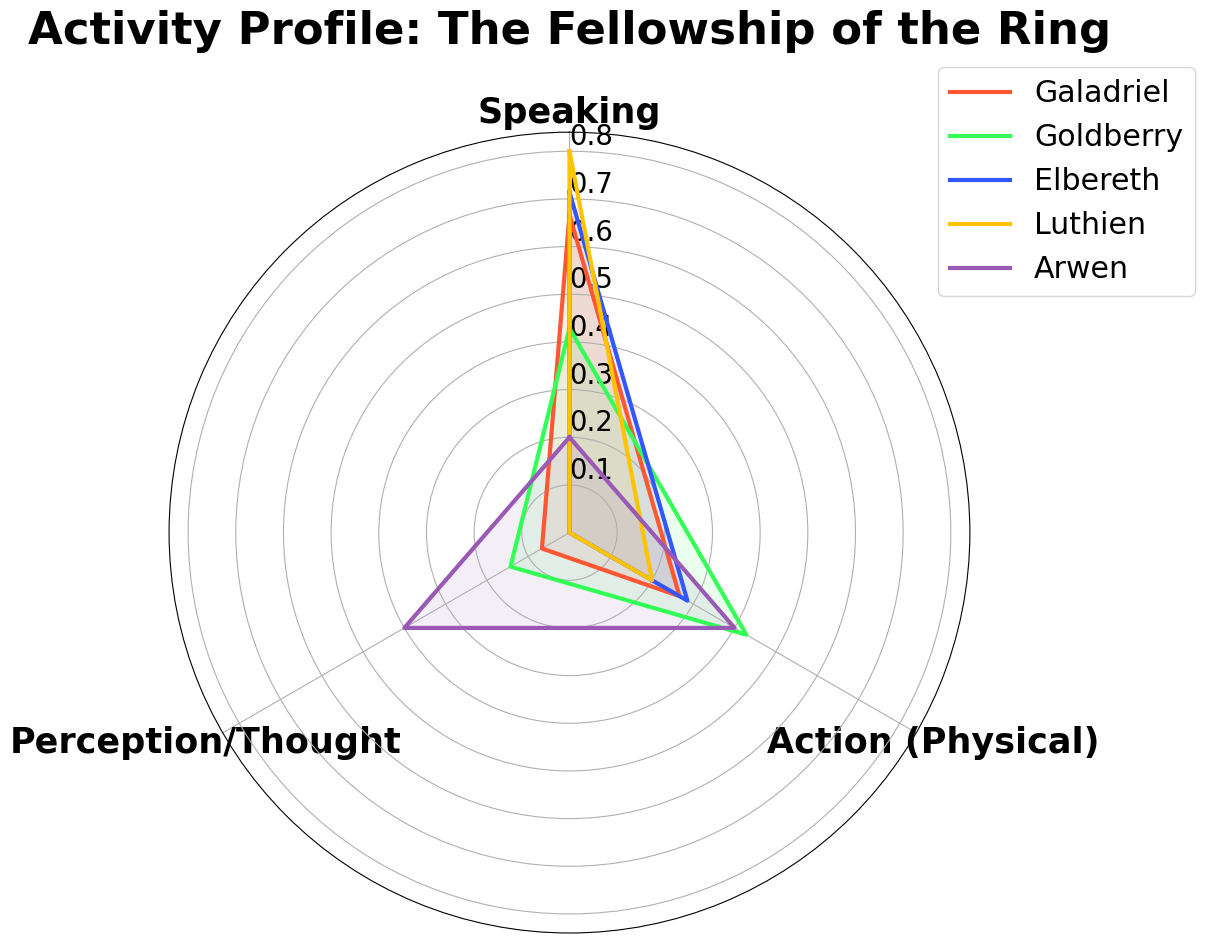


Processing Radar Chart for The Two Towers...


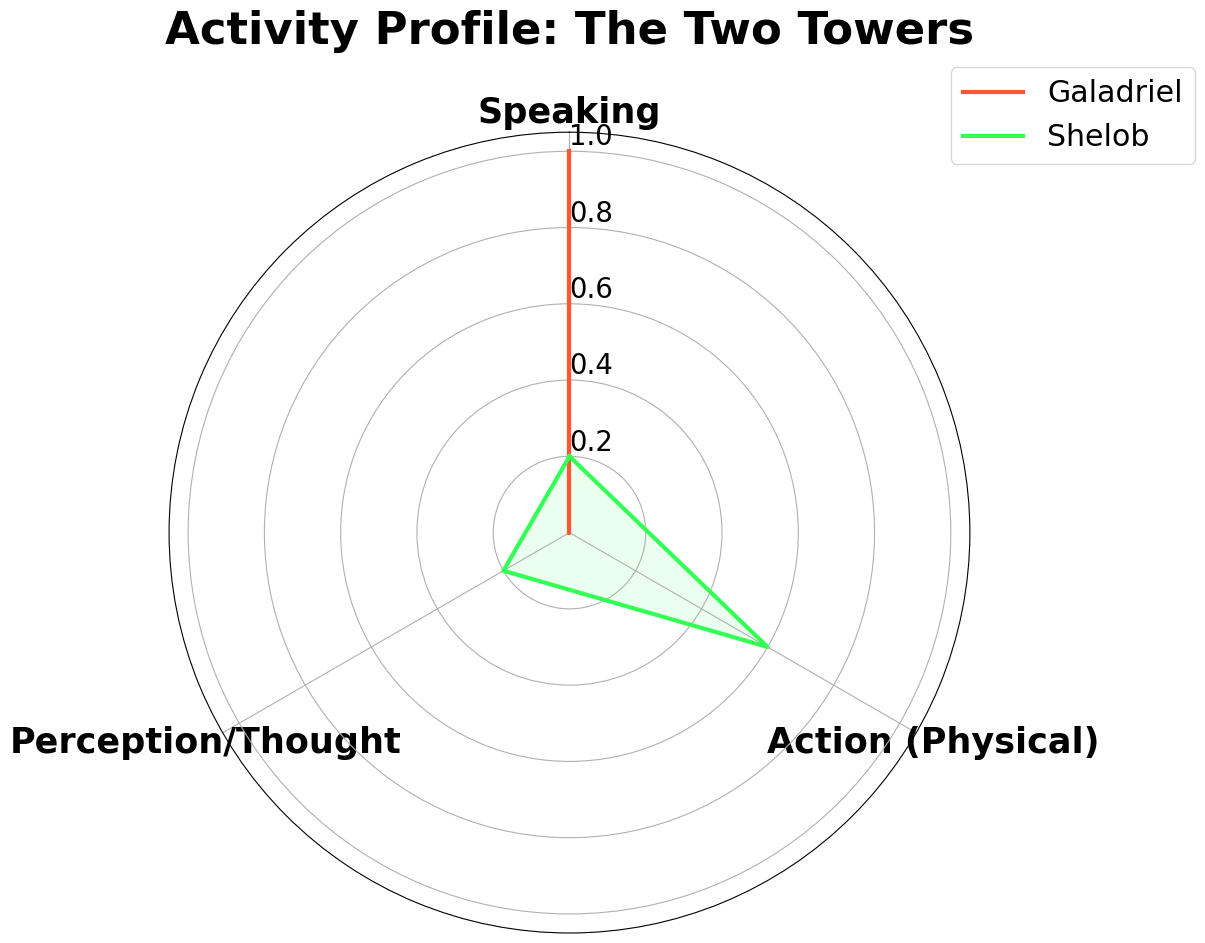


Processing Radar Chart for The Return of the King...


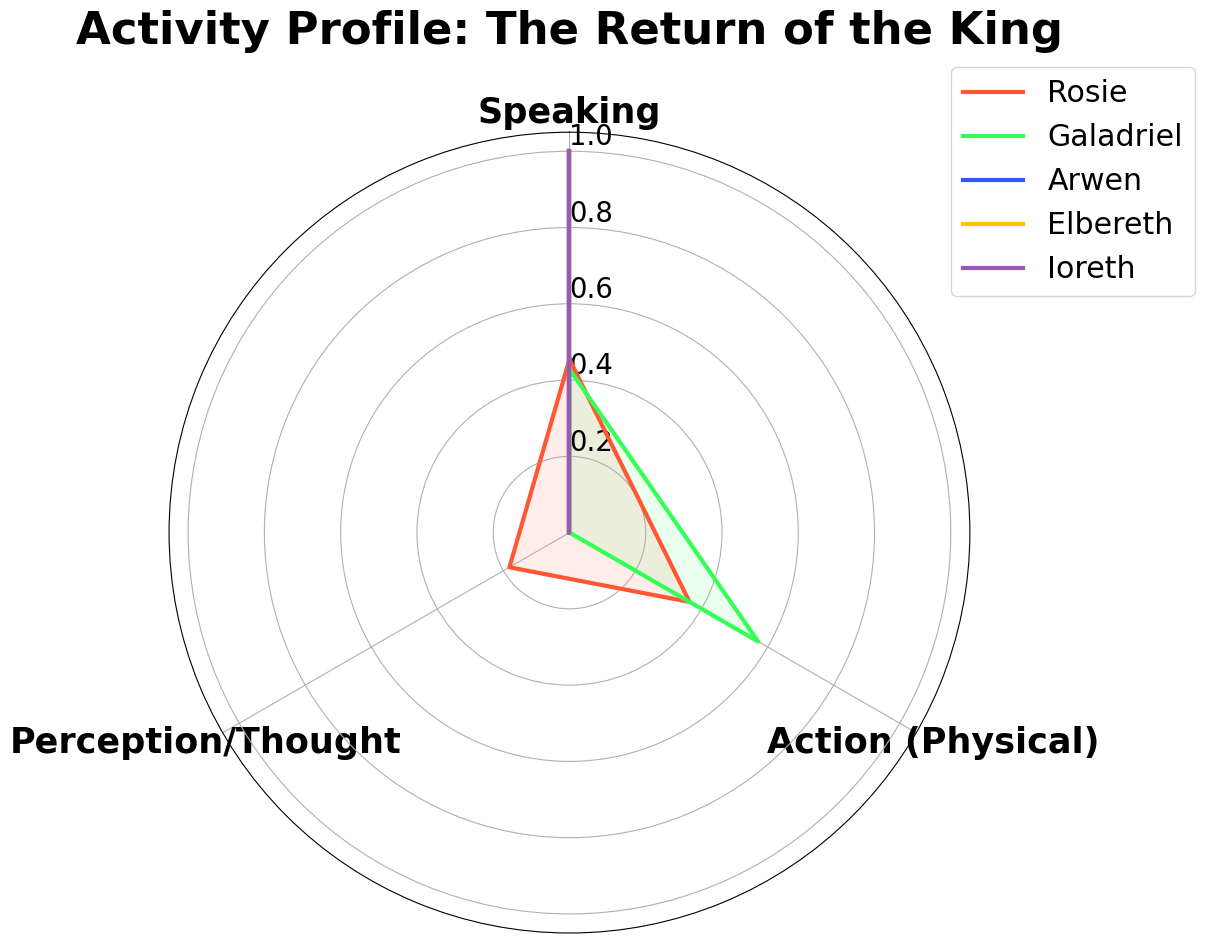

In [8]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
# (Duplicated config for standalone execution if needed, but ideally imported or passed)
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}


# --- MASTER CHARACTER MAPPING ---
FEMALE_CHARACTERS_COMPREHENSIVE = {
    # Major Active
    "Galadriel": ["galadriel", "lady of light", "lady of the wood", "sorceress of the golden wood", "lady of lorien", "white lady"],
    "Eowyn": ["eowyn", "damsel", "shieldmaiden", "dernhelm", "sister-daughter", "lady of rohan", "white lady of rohan"],
    "Arwen": ["arwen", "undomiel", "evenstar", "daughter of elrond", "queen"],
    "Shelob": ["shelob", "spider", "her ladyship"],
    "Goldberry": ["goldberry", "river-daughter", "river-woman's daughter"],

    # Minor / Supporting / Historical / Deities
    "Rosie": ["rosie", "cotton", "rose", "rosie-lass"],
    "Ioreth": ["ioreth", "wise-woman", "old wife"],
    "Lobelia": ["lobelia", "sackville-baggins"],
    "Primula": ["primula"],
    "Belladonna": ["belladonna"],
    "Gilraen": ["gilraen"],
    "Luthien": ["luthien", "tinuviel", "nightingale"],
    "Elbereth": ["elbereth", "gilthoniel", "varda", "star-kindler"],
}

# --- BOOK FILTERS ---
BOOK_FILTERS = {
    "The Fellowship of the Ring": ["Galadriel", "Goldberry", "Arwen", "Lobelia", "Luthien", "Elbereth", "Gilraen"],
    "The Two Towers": ["Eowyn", "Shelob", "Galadriel", "Arwen", "Elbereth", "Luthien"],
    "The Return of the King": ["Eowyn", "Arwen", "Rosie", "Ioreth", "Lobelia", "Galadriel", "Elbereth", "Luthien"],
}

# --- EXPANDED VERB DICTIONARIES ---
VERB_CATEGORIES = {
    "Speaking": set(["said", "asked", "replied", "answered", "cried", "shouted", "whispered",
                     "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
                     "commanded", "demanded", "begged", "warned", "laughed", "sighed",
                     "continued", "added", "explained", "agreed", "announced", "greeting", "wept"]),
    "Action (Physical)": set(["ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell",
                              "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held",
                              "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat",
                              "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed",
                              "went", "came", "gave", "took", "put", "set", "lay", "waited", "passed", "crawled", "stung", "bit"]),
    "Perception/Thought": set(["saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched",
                               "noticed", "listened", "wondered", "remembered", "feared", "hoped",
                               "stared", "glanced", "gazed", "perceived", "understood", "believed",
                               "realized", "guessed", "loved", "wished"])
}

SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again", "and", "but", "so", "very"])

# --- DATA LOADING AND ANALYSIS (Copied for standalone functionality) ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

def analyze_activity(tokens, alias_map, window_after=6):
    activity_stats = defaultdict(lambda: defaultdict(int))
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: continue
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        activity_stats[char_name][category] += 1
                        found_verb = True
                        break
                if found_verb: break
    return activity_stats


# --- RADAR CHART FUNCTION (Per Book) ---
def plot_book_radar_profiles(stats, title, text_scaling=1.5, fig_size_scale=1.2):
    """
    Plots a radar chart for the top 5 active characters in a specific book.
    Args:
        stats: Activity stats dictionary for the book.
        title: Title of the book.
        text_scaling: Multiplier for font sizes.
        fig_size_scale: Multiplier for figure size.
    """
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 0}
    if not active_chars:
        print(f"No active characters to plot for {title}")
        return

    # Calculate Font Sizes based on scaling
    title_fs = 18 * text_scaling
    label_fs = 14 * text_scaling
    tick_fs = 11 * text_scaling
    legend_fs = 12 * text_scaling

    # Top 5 most active in THIS book
    top_5 = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)[:5]
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]

    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Calculate Figure Size
    fig, ax = plt.subplots(figsize=(8 * fig_size_scale, 8 * fig_size_scale), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, size=label_fs, fontweight='bold')
    ax.set_rlabel_position(0)
    plt.yticks(fontsize=tick_fs)

    colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#9B59B6']

    for i, char in enumerate(top_5):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]

        total = sum(values) if sum(values) > 0 else 1
        norm_values = [v/total for v in values]
        norm_values += norm_values[:1]

        color = colors[i % len(colors)]

        ax.plot(angles, norm_values, linewidth=3, linestyle='solid', label=char, color=color)
        ax.fill(angles, norm_values, color=color, alpha=0.1)

    plt.title(f"Activity Profile: {title}", size=title_fs, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=legend_fs)
    plt.show()

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    books = [
        ("The Fellowship of the Ring", CONFIG["book1_path"]),
        ("The Two Towers", CONFIG["book2_path"]),
        ("The Return of the King", CONFIG["book3_path"])
    ]

    print("Starting Radar Chart Generation (Female Characters)...")

    for title, path in books:
        print(f"\nProcessing Radar Chart for {title}...")
        relevant_names = BOOK_FILTERS.get(title, [])

        book_alias_map = {}
        for name in relevant_names:
            for alias in FEMALE_CHARACTERS_COMPREHENSIVE.get(name, []):
                book_alias_map[alias] = name

        tokens = clean_and_tokenize(path)

        if tokens:
            act_stats = analyze_activity(tokens, book_alias_map, window_after=6)
            
            # Generate Radar Chart for THIS book
            # ADJUST SIZES HERE: text_scaling=1.5 (bigger text), fig_size_scale=1.2 (bigger image)
            plot_book_radar_profiles(act_stats, title, text_scaling=1.8, fig_size_scale=1.3)

        else:
            print(f"Error: No tokens found for {title}.")

Starting Radar Chart Generation (Female Characters)...

Processing Radar Chart for The Fellowship of the Ring...


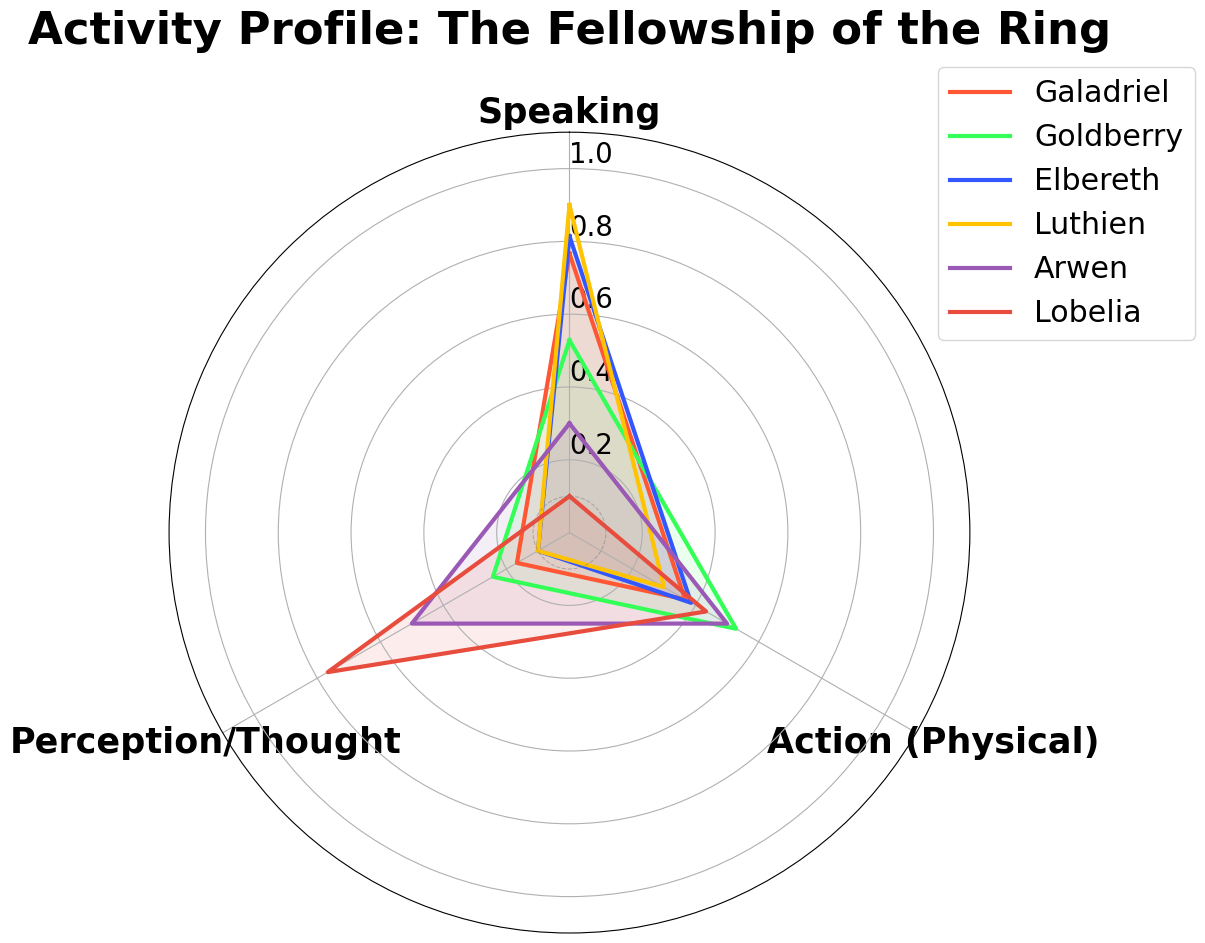


Processing Radar Chart for The Two Towers...
Found Eowyn variants in text (before lowercase): {'Eowyn'}
Found Eowyn variants after lowercase: {'eowyn'}


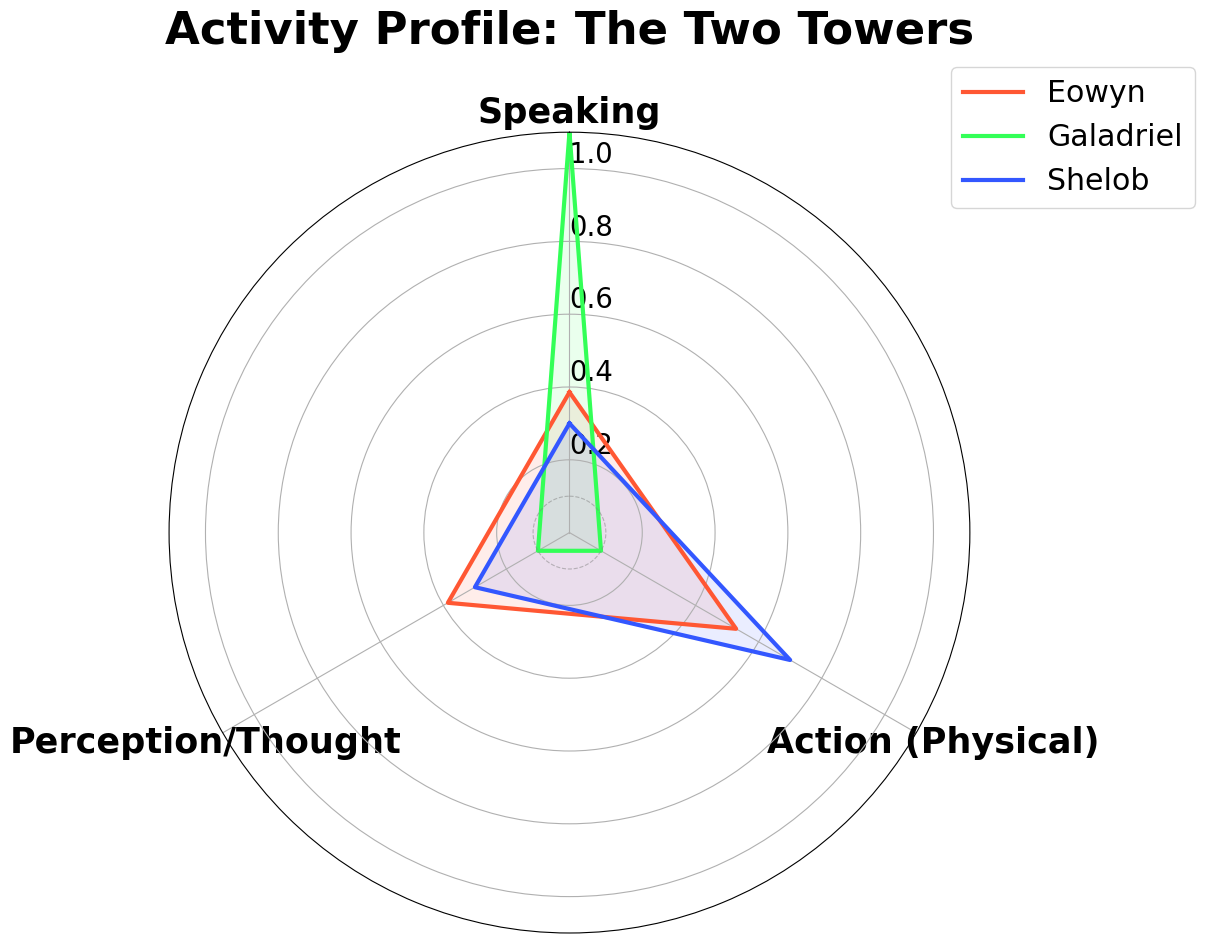


Processing Radar Chart for The Return of the King...
Found Eowyn variants in text (before lowercase): {'Eowyn'}
Found Eowyn variants after lowercase: {'eowyn'}


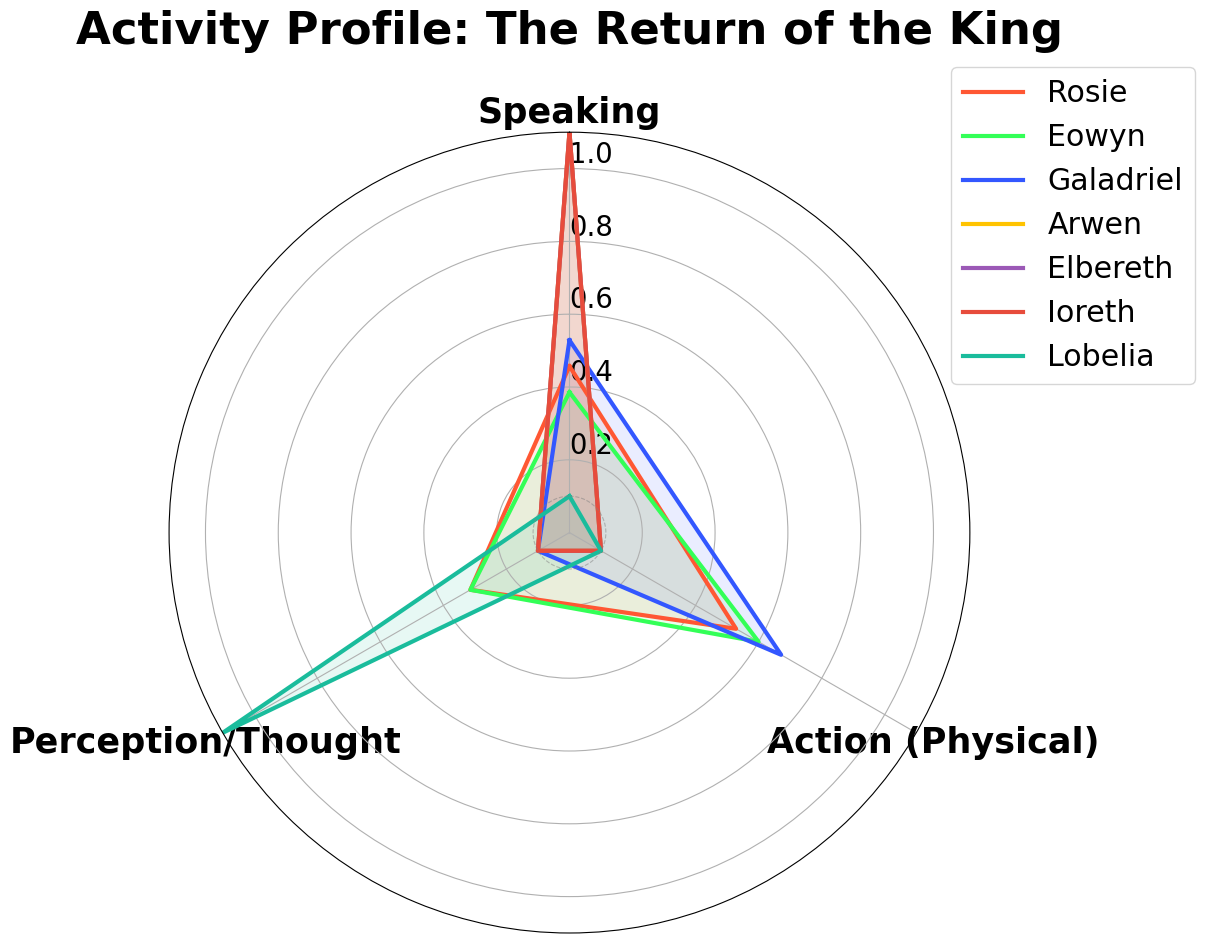

In [6]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
# (Duplicated config for standalone execution if needed, but ideally imported or passed)
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# --- MASTER CHARACTER MAPPING ---
FEMALE_CHARACTERS_COMPREHENSIVE = {
    # Major Active
    "Galadriel": ["galadriel", "lady of light", "lady of the wood", "sorceress of the golden wood", "lady of lorien", "white lady"],
    "Eowyn": ["eowyn", "éowyn", "damsel", "shieldmaiden", "dernhelm", "sister-daughter", "lady of rohan", "white lady of rohan"],
    "Arwen": ["arwen", "undomiel", "evenstar", "daughter of elrond", "queen"],
    "Shelob": ["shelob", "spider", "her ladyship"],
    "Goldberry": ["goldberry", "river-daughter", "river-woman's daughter"],

    # Minor / Supporting / Historical / Deities
    "Rosie": ["rosie", "rose", "rosie-lass"], #"cotton"
    "Ioreth": ["ioreth", "wise-woman", "old wife"],
    "Lobelia": ["lobelia", "sackville-baggins"],
    "Primula": ["primula"],
    "Belladonna": ["belladonna"],
    "Gilraen": ["gilraen"],
    "Luthien": ["luthien", "tinuviel", "nightingale"],
    "Elbereth": ["elbereth", "gilthoniel", "varda", "star-kindler"],
}

# --- BOOK FILTERS ---
BOOK_FILTERS = {
    "The Fellowship of the Ring": ["Galadriel", "Goldberry", "Arwen", "Lobelia", "Luthien", "Elbereth", "Gilraen"],
    "The Two Towers": ["Eowyn", "Shelob", "Galadriel", "Arwen", "Elbereth", "Luthien"],
    "The Return of the King": ["Eowyn", "Arwen", "Rosie", "Ioreth", "Lobelia", "Galadriel", "Elbereth", "Luthien"],
}

# --- EXPANDED VERB DICTIONARIES ---
VERB_CATEGORIES = {
    "Speaking": set(["said", "asked", "replied", "answered", "cried", "shouted", "whispered",
                     "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
                     "commanded", "demanded", "begged", "warned", "laughed", "sighed",
                     "continued", "added", "explained", "agreed", "announced", "greeting", "wept"]),
    "Action (Physical)": set(["ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell",
                              "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held",
                              "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat",
                              "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed",
                              "went", "came", "gave", "took", "put", "set", "lay", "waited", "passed", "crawled", "stung", "bit"]),
    "Perception/Thought": set(["saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched",
                               "noticed", "listened", "wondered", "remembered", "feared", "hoped",
                               "stared", "glanced", "gazed", "perceived", "understood", "believed",
                               "realized", "guessed", "loved", "wished"])
}

SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again", "and", "but", "so", "very"])

# --- DATA LOADING AND ANALYSIS (Copied for standalone functionality) ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
    clean_text = text[start_idx:end_idx]
    
    # DEBUG: Print sample of Eowyn mentions BEFORE lowercasing
    import re as re_debug
    eowyn_matches = re_debug.findall(r'\b\w*[eéEÉ][oóOÓ]wyn\w*\b', clean_text, re_debug.IGNORECASE)
    if eowyn_matches:
        print(f"Found Eowyn variants in text (before lowercase): {set(eowyn_matches[:20])}")
    
    clean_text = clean_text.lower()
    
    # Check again after lowercasing
    eowyn_matches_lower = re_debug.findall(r'\b\w*[eéEÉ][oóOÓ]wyn\w*\b', clean_text, re_debug.IGNORECASE)
    if eowyn_matches_lower:
        print(f"Found Eowyn variants after lowercase: {set(eowyn_matches_lower[:20])}")
    
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

def analyze_activity(tokens, alias_map, window_after=6):
    activity_stats = defaultdict(lambda: defaultdict(int))
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: continue
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        activity_stats[char_name][category] += 1
                        found_verb = True
                        break
                if found_verb: break
    return activity_stats


# --- RADAR CHART FUNCTION (Per Book) - ALL CHARACTERS VERSION ---
def plot_book_radar_profiles(stats, title, text_scaling=1.5, fig_size_scale=1.2):
    """
    Plots a radar chart for ALL active characters in a specific book.
    Args:
        stats: Activity stats dictionary for the book.
        title: Title of the book.
        text_scaling: Multiplier for font sizes.
        fig_size_scale: Multiplier for figure size.
    """
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 0}
    if not active_chars:
        print(f"No active characters to plot for {title}")
        return

    # Calculate Font Sizes based on scaling
    title_fs = 18 * text_scaling
    label_fs = 14 * text_scaling
    tick_fs = 11 * text_scaling
    legend_fs = 12 * text_scaling

    # ALL active characters (sorted by total activity for consistent ordering)
    all_chars = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]

    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Calculate Figure Size
    fig, ax = plt.subplots(figsize=(8 * fig_size_scale, 8 * fig_size_scale), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, size=label_fs, fontweight='bold')
    ax.set_rlabel_position(0)
    plt.yticks(fontsize=tick_fs)
    
    # Set y-axis limit to accommodate the offset
    ax.set_ylim(0, 1.1) 

    colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#9B59B6', '#E74C3C', '#1ABC9C', '#F39C12', '#8E44AD', '#2ECC71', '#E67E22', '#3498DB', '#C0392B']
    
    # DEAD ZONE OFFSET
    dead_zone = 0.1

    for i, char in enumerate(all_chars):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]

        total = sum(values) if sum(values) > 0 else 1
        # Normalize and then ADD DEAD ZONE offset
        norm_values = [(v/total) + dead_zone for v in values]
        norm_values += norm_values[:1]

        color = colors[i % len(colors)]

        ax.plot(angles, norm_values, linewidth=3, linestyle='solid', label=char, color=color)
        ax.fill(angles, norm_values, color=color, alpha=0.1)
        
    # Add a circle to indicate the dead zone
    grid_angles = np.linspace(0, 2*pi, 100)
    ax.plot(grid_angles, [dead_zone]*100, color='grey', linestyle='--', linewidth=0.8, alpha=0.5)

    plt.title(f"Activity Profile: {title}", size=title_fs, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=legend_fs)
    plt.show()

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    books = [
        ("The Fellowship of the Ring", CONFIG["book1_path"]),
        ("The Two Towers", CONFIG["book2_path"]),
        ("The Return of the King", CONFIG["book3_path"])
    ]

    print("Starting Radar Chart Generation (Female Characters)...")

    for title, path in books:
        print(f"\nProcessing Radar Chart for {title}...")
        relevant_names = BOOK_FILTERS.get(title, [])

        book_alias_map = {}
        for name in relevant_names:
            for alias in FEMALE_CHARACTERS_COMPREHENSIVE.get(name, []):
                book_alias_map[alias] = name

        tokens = clean_and_tokenize(path)

        if tokens:
            act_stats = analyze_activity(tokens, book_alias_map, window_after=6)
            
            # Generate Radar Chart for THIS book - ALL CHARACTERS
            # ADJUST SIZES HERE: text_scaling=1.5 (bigger text), fig_size_scale=1.2 (bigger image)
            plot_book_radar_profiles(act_stats, title, text_scaling=1.8, fig_size_scale=1.3)

        else:
            print(f"Error: No tokens found for {title}.")